# Scaling, Training, Testing, and Tuning


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    f1_score,
    roc_auc_score,
    precision_score,
    recall_score,
    precision_recall_curve,
    average_precision_score,

)
import xgboost as xgb
import shap
from sklearn.inspection import permutation_importance
import optuna
import os
import joblib
import warnings
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.cluster import KMeans


final_df = pd.read_csv("final_df.csv")


scaler = StandardScaler()



x = final_df.drop(columns=["at_risk"], axis=1)


y = final_df["at_risk"]



# Check for class imbalance


print(f"Class distribution: \t[  No | Yes ]\n\t\t\t{y.value_counts().values}\n")



print(f"Class ratio: {y.value_counts()[0]/y.value_counts()[1]:.2f}:1\n")



X_scaled = scaler.fit_transform(x)


x_train, x_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)


c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Class distribution: 	[  No | Yes ]
			[88615 22892]

Class ratio: 3.87:1



# Optuna - Single Objective


In [ ]:
warnings.filterwarnings("ignore")
def objective(trial):

    # Define hyperparameters to optimize

    param = {
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # Parameters specific to tree-based boosters
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "eta": trial.suggest_float("eta", 0.01, 0.3, log=True),
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        "grow_policy": trial.suggest_categorical(
            "grow_policy", ["depthwise", "lossguide"]
        ),
        # Sampling parameters
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        # Handle class imbalance - assuming 4:1 ratio from previous information
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1.0, 6.0),
        # Other parameters
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),

        # For dart booster
        "sample_type": trial.suggest_categorical(
            "sample_type", ["uniform", "weighted"]
        ),
        "normalize_type": trial.suggest_categorical(
            "normalize_type", ["tree", "forest"]
        ),
        "rate_drop": trial.suggest_float("rate_drop", 0.0, 0.5),
        "skip_drop": trial.suggest_float("skip_drop", 0.0, 0.5),
    }


    # Remove dart-specific parameters if not using dart booster

    if param["booster"] != "dart":

        param.pop("sample_type")

        param.pop("normalize_type")
        param.pop("rate_drop")

        param.pop("skip_drop")


    # Remove tree-specific parameters if using linear booster

    if param["booster"] == "gblinear":

        param.pop("max_depth")
        param.pop("gamma")

        param.pop("grow_policy")

        param.pop("min_child_weight")

    # Sets upper-limit on the number of boosting rounds
    max_n_estimators = 300

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


    # Store metrics across folds (Hyperband)
    f1_scores = []
    # auc_scores = []
    # precision_scores = []
    # recall_scores = []

    # We need to manually implement cross-validation for Hyperband pruning to track resources, evaluate trial during training,
    # and to include the callback mechanism to report to the pruner - runs after each boosting round
    for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X_scaled, y)):
        X_fold_train = X_scaled[train_idx]
        X_fold_val = X_scaled[val_idx]
        y_fold_train = y.iloc[train_idx]
        y_fold_val = y.iloc[val_idx]

        # Prepare evaluation set
        eval_set = [(X_fold_val, y_fold_val)]

        model = xgb.XGBClassifier(
            **param,
            n_estimators=max_n_estimators,
            random_state=42,
            use_label_encoder=False,
            early_stopping_rounds=20,
            callbacks=[HyperbandCallback(trial, "logloss")],
        )

        try:
            # Train with pruning callback
            model.fit(
                X_fold_train,
                y_fold_train,
                eval_set=eval_set,
                verbose=False,
            )

            # Make predictions
            y_pred = model.predict(X_fold_val)

            # uncomment if you want to test auc
            # y_pred_proba = model.predict_proba(X_fold_val)[:, 1]

            # Calculate metrics for this fold
            fold_f1 = f1_score(y_fold_val, y_pred)
            # fold_auc = roc_auc_score(y_fold_val, y_pred_proba)
            # fold_precision = precision_score(y_fold_val, y_pred)
            # fold_recall = recall_score(y_fold_val, y_pred)

            # Store metrics
            f1_scores.append(fold_f1)
            # auc_scores.append(fold_auc)
            # precision_scores.append(fold_precision)
            # recall_scores.append(fold_recall)

        except optuna.exceptions.TrialPruned:
            # Trial was pruned by Hyperband
            raise

    # Calculate mean scores
    mean_f1 = np.mean(f1_scores) if f1_scores else 0.0
    # mean_auc = np.mean(auc_scores) if auc_scores else 0.0
    # mean_precision = np.mean(precision_scores) if precision_scores else 0.0
    # mean_recall = np.mean(recall_scores) if recall_scores else 0.0

    # Store additional info for analysis
    trial.set_user_attr("mean_f1", mean_f1)
    # trial.set_user_attr("mean_auc", mean_auc)
    # trial.set_user_attr("mean_precision", mean_precision)
    # trial.set_user_attr("mean_recall", mean_recall)

    # Optuna will try to maximize our returned values to improve the model
    return mean_f1


# Only log trials that beat the previous best value
def logging_callback(study, frozen_trial):
    previous_best_value = study.user_attrs.get("previous_best_value", None)

    if study.best_trial.number == frozen_trial.number:
        study.set_user_attr("previous_best_value", study.best_value)

        output = f"""
        \n==========================================================================\n
        New best trial found!\t\t{timestamp}\n
        Trial {frozen_trial.number} finished with best value: {frozen_trial.value}\n
        Parameters: {frozen_trial.params}\n
        Previous best value: {previous_best_value}\n
        ===========================================================================\n\n
        """

        print(output)
        study.set_user_attr("previous_best_value", frozen_trial.value)


# Define callback for Hyperband pruning
class HyperbandCallback(xgb.callback.TrainingCallback):
    def __init__(self, trial, eval_metric):
        self.trial = trial
        self.eval_metric = eval_metric

    def after_iteration(
        self, model, epoch, evals_log
    ):  # Not all variables are used, but XGBoost requires them to use the callback function
        # Get current metric value
        if len(evals_log["validation_0"][self.eval_metric]) > 0:
            score = float(evals_log["validation_0"][self.eval_metric][-1])

            # Report to Hyperband (resource = current boosting round)
            self.trial.report(score, epoch)

            # Check if we should prune
            if self.trial.should_prune():
                return True  # Stop training

        return False


hyperband_pruner = optuna.pruners.HyperbandPruner(
    min_resource=70,  # minimum number of boosting rounds
    max_resource=500,  # maximum number of boosting rounds
    reduction_factor=3,
    bootstrap_count=0,
)

# Create parent and single objective directory for Optuna trial logs
path = "optuna_models_info"
single_opt_dir = os.path.join(path, "single_objective_logs")
recall_dir = os.path.join(single_opt_dir, "recall_logs")
timestamp = datetime.now().strftime("%Y-%m-%d_%H%M%S")

# Uncomment if you want to test these metrics and create their directories
f1_dir = os.path.join(single_opt_dir, "f1_logs")
# precision_dir = os.path.join(single_opt_dir, "precision_logs")
# auc_dir = os.path.join(single_opt_dir, "auc_logs")

os.makedirs(recall_dir, exist_ok=True)
os.makedirs(f1_dir, exist_ok=True)

recall_filepath = os.path.join(recall_dir, "XGBClassifier-single_objective_recall_optimization-hyperband_pruner.db")
f1_filepath = os.path.join(f1_dir, "XGBClassifier-single_objective_f1_optimization-hyperband_pruner.db")

# recall optimization
# study = optuna.create_study(
#     direction="maximize",
#     study_name="MVP-XGBClassifier-single_objective_recall",
#     storage=f"sqlite:///{recall_filepath}?timeout=60.0",
#     load_if_exists=True,
#     pruner=hyperband_pruner,
# )

# f1_score optimization
study = optuna.create_study(
    direction="maximize",
    study_name="MVP-XGBClassifier-single_objective_f1",
    storage=f"sqlite:///{f1_filepath}?timeout=60.0",
    load_if_exists=True,
    pruner=hyperband_pruner,
 )

# start optimization
study.optimize(
    objective,
    n_trials=200,
    n_jobs=-1,
    show_progress_bar=True,
    callbacks=[lambda study, trial: logging_callback(study, trial)],
)

# Modify below for single-objective optimization
print("Best trial:")
trial = study.best_trial

print(f"  F1 Score: {trial.value:.4f}")
print("  Best hyperparameters:")

for key, value in trial.params.items():
    print(f"    {key}: {value}")


# Create a model with the best parameters
best_params = trial.params
best_model = xgb.XGBClassifier(**best_params, random_state=42, use_label_encoder=False)

model_path = os.path.join(path, f"best_model_{study.study_name}-{timestamp}.joblib")


joblib.dump(best_model, model_path)


[I 2025-05-01 01:45:17,799] A new study created in RDB with name: MVP-XGBClassifier-single_objective_f1
  0%|          | 0/200 [03:07<?, ?it/s]

[I 2025-05-01 01:48:25,355] Trial 3 finished with value: 0.49877995301456524 and parameters: {'booster': 'gblinear', 'lambda': 4.385842593663509e-08, 'alpha': 0.14743288464615323, 'max_depth': 9, 'eta': 0.011135429190579901, 'gamma': 1.5090701064818397e-07, 'grow_policy': 'lossguide', 'subsample': 0.5759801903511108, 'colsample_bytree': 0.730363251454719, 'scale_pos_weight': 4.8741837203578555, 'min_child_weight': 6, 'learning_rate': 0.19226015705445, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.09755454890518883, 'skip_drop': 0.383090925146618}. Best is trial 3 with value: 0.49877995301456524.

        

        New best trial found!		2025-05-01_014517

        Trial 3 finished with best value: 0.49877995301456524

        Parameters: {'booster': 'gblinear', 'lambda': 4.385842593663509e-08, 'alpha': 0.14743288464615323, 'max_depth': 9, 'eta': 0.011135429190579901, 'gamma': 1.5090701064818397e-07, 'grow_policy': 'lossguide', 'subsample': 0.5759801903511108, 'colsa

Best trial: 3. Best value: 0.49878:   0%|          | 1/200 [04:39<10:25:04, 188.46s/it]

[I 2025-05-01 01:49:57,259] Trial 8 finished with value: 0.6537629664790388 and parameters: {'booster': 'gblinear', 'lambda': 1.060878821331974e-05, 'alpha': 5.2172802352588266e-06, 'max_depth': 4, 'eta': 0.2316788077648229, 'gamma': 0.6378564440130988, 'grow_policy': 'lossguide', 'subsample': 0.9119377582128978, 'colsample_bytree': 0.7417362097752399, 'scale_pos_weight': 2.7623543052995343, 'min_child_weight': 1, 'learning_rate': 0.020187935774402827, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.44926078597271946, 'skip_drop': 0.4008152011135581}. Best is trial 8 with value: 0.6537629664790388.

        

        New best trial found!		2025-05-01_014517

        Trial 8 finished with best value: 0.6537629664790388

        Parameters: {'booster': 'gblinear', 'lambda': 1.060878821331974e-05, 'alpha': 5.2172802352588266e-06, 'max_depth': 4, 'eta': 0.2316788077648229, 'gamma': 0.6378564440130988, 'grow_policy': 'lossguide', 'subsample': 0.9119377582128978, 'colsa

Best trial: 8. Best value: 0.653763:   1%|          | 2/200 [05:22<7:14:17, 131.60s/it] 

[I 2025-05-01 01:50:39,985] Trial 11 finished with value: 0.595860274158007 and parameters: {'booster': 'gblinear', 'lambda': 0.01552466548319197, 'alpha': 1.4835110171507167e-07, 'max_depth': 7, 'eta': 0.22246508628109696, 'gamma': 0.0031518787628606656, 'grow_policy': 'lossguide', 'subsample': 0.8641928241271668, 'colsample_bytree': 0.6494508952422158, 'scale_pos_weight': 4.598405336828832, 'min_child_weight': 9, 'learning_rate': 0.14427565714749782, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.3865277824165949, 'skip_drop': 0.19359766738901096}. Best is trial 8 with value: 0.6537629664790388.


Best trial: 8. Best value: 0.653763:   2%|▏         | 3/200 [05:45<4:58:48, 91.01s/it] 

[I 2025-05-01 01:51:03,633] Trial 9 finished with value: 0.7108972079351231 and parameters: {'booster': 'gblinear', 'lambda': 2.2968745507695286e-07, 'alpha': 0.00039301120417175185, 'max_depth': 4, 'eta': 0.0823557553899245, 'gamma': 2.3347826667621263e-08, 'grow_policy': 'depthwise', 'subsample': 0.6035376789394199, 'colsample_bytree': 0.6082492547105718, 'scale_pos_weight': 1.9367823835425304, 'min_child_weight': 7, 'learning_rate': 0.09368472183157595, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.31224948887915205, 'skip_drop': 0.16784613311385221}. Best is trial 9 with value: 0.7108972079351231.

        

        New best trial found!		2025-05-01_014517

        Trial 9 finished with best value: 0.7108972079351231

        Parameters: {'booster': 'gblinear', 'lambda': 2.2968745507695286e-07, 'alpha': 0.00039301120417175185, 'max_depth': 4, 'eta': 0.0823557553899245, 'gamma': 2.3347826667621263e-08, 'grow_policy': 'depthwise', 'subsample': 0.6035376789394199,

Best trial: 9. Best value: 0.710897:   2%|▏         | 4/200 [05:52<3:29:59, 64.28s/it]

[I 2025-05-01 01:51:10,632] Trial 0 finished with value: 0.5542360817629144 and parameters: {'booster': 'gblinear', 'lambda': 0.4751726324472222, 'alpha': 4.012355689190619e-06, 'max_depth': 3, 'eta': 0.062260474518737445, 'gamma': 2.86915411051214e-08, 'grow_policy': 'lossguide', 'subsample': 0.8650004207438566, 'colsample_bytree': 0.8163549139027294, 'scale_pos_weight': 4.935379951973822, 'min_child_weight': 10, 'learning_rate': 0.058100458151454114, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.48579209275155405, 'skip_drop': 0.48484552689201477}. Best is trial 9 with value: 0.7108972079351231.


Best trial: 9. Best value: 0.710897:   3%|▎         | 6/200 [06:15<1:56:56, 36.17s/it]

[I 2025-05-01 01:51:32,744] Trial 5 finished with value: 0.5777874903834272 and parameters: {'booster': 'gblinear', 'lambda': 1.5843088883545198e-05, 'alpha': 4.432438616827719e-07, 'max_depth': 10, 'eta': 0.1845417000024582, 'gamma': 0.962896422536034, 'grow_policy': 'depthwise', 'subsample': 0.8749349436541378, 'colsample_bytree': 0.8385677940617198, 'scale_pos_weight': 5.071049657635056, 'min_child_weight': 1, 'learning_rate': 0.13575303752362516, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.05990410016298764, 'skip_drop': 0.3501567595565371}. Best is trial 9 with value: 0.7108972079351231.


Best trial: 9. Best value: 0.710897:   3%|▎         | 6/200 [08:13<1:56:56, 36.17s/it]

[I 2025-05-01 01:53:30,926] Trial 17 finished with value: 0.7433749154046473 and parameters: {'booster': 'gbtree', 'lambda': 0.00012506092499449807, 'alpha': 2.15576008366265e-05, 'max_depth': 5, 'eta': 0.026565520344489807, 'gamma': 0.5144588848136618, 'grow_policy': 'depthwise', 'subsample': 0.5159210762682274, 'colsample_bytree': 0.5543336222788965, 'scale_pos_weight': 3.2710193145537723, 'min_child_weight': 1, 'learning_rate': 0.06181700050024838, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.38239658837368384, 'skip_drop': 0.4056292250191962}. Best is trial 17 with value: 0.7433749154046473.

        

        New best trial found!		2025-05-01_014517

        Trial 17 finished with best value: 0.7433749154046473

        Parameters: {'booster': 'gbtree', 'lambda': 0.00012506092499449807, 'alpha': 2.15576008366265e-05, 'max_depth': 5, 'eta': 0.026565520344489807, 'gamma': 0.5144588848136618, 'grow_policy': 'depthwise', 'subsample': 0.5159210762682274, 'colsam

Best trial: 17. Best value: 0.743375:   4%|▍         | 8/200 [08:14<2:18:53, 43.40s/it]

[I 2025-05-01 01:53:32,554] Trial 7 finished with value: 0.7400933240700485 and parameters: {'booster': 'gbtree', 'lambda': 7.028615902049501e-05, 'alpha': 9.395988305406416e-06, 'max_depth': 9, 'eta': 0.021417528376659955, 'gamma': 1.761339166004382e-05, 'grow_policy': 'depthwise', 'subsample': 0.5036153964706915, 'colsample_bytree': 0.9488217901328317, 'scale_pos_weight': 3.5852552338646917, 'min_child_weight': 6, 'learning_rate': 0.08476150010369604, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.004848430755517497, 'skip_drop': 0.33533252533383145}. Best is trial 17 with value: 0.7433749154046473.


Best trial: 17. Best value: 0.743375:   4%|▍         | 8/200 [08:36<2:18:53, 43.40s/it]

[I 2025-05-01 01:53:54,151] Trial 25 finished with value: 0.5518944223805177 and parameters: {'booster': 'gblinear', 'lambda': 0.47718424083426325, 'alpha': 0.0002934539494132977, 'max_depth': 8, 'eta': 0.05083665143729761, 'gamma': 0.0007911123539627425, 'grow_policy': 'lossguide', 'subsample': 0.5167978704514969, 'colsample_bytree': 0.9781877380917092, 'scale_pos_weight': 5.174207545119915, 'min_child_weight': 1, 'learning_rate': 0.12907676287057648, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.10482693727647585, 'skip_drop': 0.13954469815661458}. Best is trial 17 with value: 0.7433749154046473.


Best trial: 17. Best value: 0.743375:   4%|▍         | 9/200 [08:39<1:56:31, 36.60s/it]

[I 2025-05-01 01:53:57,044] Trial 10 finished with value: 0.734582984364603 and parameters: {'booster': 'gbtree', 'lambda': 2.1082535111560998e-05, 'alpha': 5.167364279934458e-07, 'max_depth': 3, 'eta': 0.11868234075133442, 'gamma': 0.004242672291568778, 'grow_policy': 'depthwise', 'subsample': 0.598020591335158, 'colsample_bytree': 0.5096218978396987, 'scale_pos_weight': 3.6145697387640245, 'min_child_weight': 8, 'learning_rate': 0.016063472311090704, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.05008720327698629, 'skip_drop': 0.059875395702772005}. Best is trial 17 with value: 0.7433749154046473.


Best trial: 17. Best value: 0.743375:   6%|▌         | 11/200 [09:32<1:47:53, 34.25s/it]

[I 2025-05-01 01:54:49,892] Trial 22 finished with value: 0.6012538014922694 and parameters: {'booster': 'gblinear', 'lambda': 2.0791173867435504e-06, 'alpha': 0.02653879322445985, 'max_depth': 10, 'eta': 0.2989647670456981, 'gamma': 2.112601054903276e-08, 'grow_policy': 'lossguide', 'subsample': 0.9647875093683168, 'colsample_bytree': 0.639133010829461, 'scale_pos_weight': 4.143772310670021, 'min_child_weight': 5, 'learning_rate': 0.12134530296791046, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.4506449578440933, 'skip_drop': 0.2700102983156056}. Best is trial 17 with value: 0.7433749154046473.


Best trial: 17. Best value: 0.743375:   6%|▌         | 12/200 [10:00<1:41:31, 32.40s/it]

[I 2025-05-01 01:55:18,100] Trial 24 finished with value: 0.5738674651119082 and parameters: {'booster': 'gblinear', 'lambda': 0.008576831591081425, 'alpha': 5.039275003300976e-05, 'max_depth': 7, 'eta': 0.02178870891624116, 'gamma': 0.0002393557462147547, 'grow_policy': 'depthwise', 'subsample': 0.6184227622864418, 'colsample_bytree': 0.6015747369912464, 'scale_pos_weight': 4.784875067718856, 'min_child_weight': 5, 'learning_rate': 0.020714887202620286, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.22918330370111123, 'skip_drop': 0.04664813483100033}. Best is trial 17 with value: 0.7433749154046473.


Best trial: 19. Best value: 0.766219:   6%|▌         | 12/200 [10:29<1:41:31, 32.40s/it]

[I 2025-05-01 01:55:47,119] Trial 19 finished with value: 0.7662189027056023 and parameters: {'booster': 'gbtree', 'lambda': 0.009559784777293754, 'alpha': 0.0007866396006554963, 'max_depth': 3, 'eta': 0.05543400068184874, 'gamma': 0.0008624566673570278, 'grow_policy': 'lossguide', 'subsample': 0.8604624471510234, 'colsample_bytree': 0.8713240173998289, 'scale_pos_weight': 1.4939008797171585, 'min_child_weight': 9, 'learning_rate': 0.03195092016813229, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.3142760071434236, 'skip_drop': 0.04806568949633028}. Best is trial 19 with value: 0.7662189027056023.

        

        New best trial found!		2025-05-01_014517

        Trial 19 finished with best value: 0.7662189027056023

        Parameters: {'booster': 'gbtree', 'lambda': 0.009559784777293754, 'alpha': 0.0007866396006554963, 'max_depth': 3, 'eta': 0.05543400068184874, 'gamma': 0.0008624566673570278, 'grow_policy': 'lossguide', 'subsample': 0.8604624471510234, 'colsam

Best trial: 19. Best value: 0.766219:   7%|▋         | 14/200 [15:04<5:25:46, 105.09s/it]

[I 2025-05-01 02:00:22,491] Trial 4 finished with value: 0.7211029501372818 and parameters: {'booster': 'gbtree', 'lambda': 0.37187762895330007, 'alpha': 3.011775071014949e-08, 'max_depth': 6, 'eta': 0.03584678599781475, 'gamma': 0.0014709335508446542, 'grow_policy': 'lossguide', 'subsample': 0.621796460172336, 'colsample_bytree': 0.7755381180515597, 'scale_pos_weight': 4.326400362303472, 'min_child_weight': 6, 'learning_rate': 0.23100963589049012, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.4096405941349499, 'skip_drop': 0.05258569388437517}. Best is trial 19 with value: 0.7662189027056023.


Best trial: 19. Best value: 0.766219:   8%|▊         | 15/200 [15:26<4:06:43, 80.02s/it] 

[I 2025-05-01 02:00:44,482] Trial 23 finished with value: 0.7261256251420048 and parameters: {'booster': 'gbtree', 'lambda': 0.006714582829473582, 'alpha': 0.15491512726756337, 'max_depth': 8, 'eta': 0.027194309717347202, 'gamma': 0.8293744261830691, 'grow_policy': 'depthwise', 'subsample': 0.9504863914626003, 'colsample_bytree': 0.6508073732904989, 'scale_pos_weight': 4.39216059047733, 'min_child_weight': 6, 'learning_rate': 0.13817570931430168, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.15852409782078813, 'skip_drop': 0.47841020110078974}. Best is trial 19 with value: 0.7662189027056023.


Best trial: 19. Best value: 0.766219:   8%|▊         | 16/200 [18:37<5:47:22, 113.27s/it]

[I 2025-05-01 02:03:54,966] Trial 26 finished with value: 0.7011345843650435 and parameters: {'booster': 'gbtree', 'lambda': 0.15046812103778895, 'alpha': 0.002095791272380317, 'max_depth': 5, 'eta': 0.09159889720115459, 'gamma': 0.4050191113849332, 'grow_policy': 'depthwise', 'subsample': 0.8356788959530851, 'colsample_bytree': 0.7404732485209073, 'scale_pos_weight': 4.7918504600307585, 'min_child_weight': 1, 'learning_rate': 0.019497104354796815, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.22015355102746448, 'skip_drop': 0.19661000879229584}. Best is trial 19 with value: 0.7662189027056023.


Best trial: 19. Best value: 0.766219:   8%|▊         | 17/200 [18:57<4:20:09, 85.30s/it] 

[I 2025-05-01 02:04:15,227] Trial 32 finished with value: 0.7624697444129793 and parameters: {'booster': 'gbtree', 'lambda': 0.001049521108223606, 'alpha': 0.003610619235889671, 'max_depth': 5, 'eta': 0.03982235530494762, 'gamma': 0.06979700444034406, 'grow_policy': 'depthwise', 'subsample': 0.7390998149182338, 'colsample_bytree': 0.8874354219313246, 'scale_pos_weight': 1.0094407552824876, 'min_child_weight': 3, 'learning_rate': 0.0325477062882, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.2612503667366801, 'skip_drop': 0.4864756064778399}. Best is trial 19 with value: 0.7662189027056023.


Best trial: 19. Best value: 0.766219:   9%|▉         | 18/200 [19:17<3:19:00, 65.60s/it]

[I 2025-05-01 02:04:34,952] Trial 30 finished with value: 0.7521863472384943 and parameters: {'booster': 'gbtree', 'lambda': 0.0012683809203787675, 'alpha': 1.4608045741723312e-08, 'max_depth': 6, 'eta': 0.02347033468351518, 'gamma': 4.528466290501318e-06, 'grow_policy': 'depthwise', 'subsample': 0.7163032126196247, 'colsample_bytree': 0.9983828880794234, 'scale_pos_weight': 2.92611188708503, 'min_child_weight': 4, 'learning_rate': 0.035832914619944055, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.19565946381353072, 'skip_drop': 0.29898331399340605}. Best is trial 19 with value: 0.7662189027056023.


Best trial: 19. Best value: 0.766219:  10%|▉         | 19/200 [20:16<3:12:04, 63.67s/it]

[I 2025-05-01 02:05:34,144] Trial 31 finished with value: 0.7535226424923149 and parameters: {'booster': 'gbtree', 'lambda': 0.0008861342582637938, 'alpha': 0.0040574766072298315, 'max_depth': 5, 'eta': 0.025933913627549692, 'gamma': 5.271387037414462e-06, 'grow_policy': 'depthwise', 'subsample': 0.7048766978209494, 'colsample_bytree': 0.9547327991698253, 'scale_pos_weight': 2.856070530046894, 'min_child_weight': 3, 'learning_rate': 0.0472564154601417, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.1820266479701959, 'skip_drop': 0.2964468042401384}. Best is trial 19 with value: 0.7662189027056023.


Best trial: 19. Best value: 0.766219:  10%|█         | 20/200 [20:57<2:50:42, 56.90s/it]

[I 2025-05-01 02:06:15,243] Trial 21 finished with value: 0.6635315922163949 and parameters: {'booster': 'dart', 'lambda': 0.6842356156048796, 'alpha': 2.449992400709499e-05, 'max_depth': 3, 'eta': 0.19948555779766397, 'gamma': 7.587451368336641e-07, 'grow_policy': 'depthwise', 'subsample': 0.9414479048457489, 'colsample_bytree': 0.9907239848161953, 'scale_pos_weight': 5.7150453984800045, 'min_child_weight': 2, 'learning_rate': 0.19883819279681686, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.15225441072216522, 'skip_drop': 0.13950322543191246}. Best is trial 19 with value: 0.7662189027056023.


Best trial: 19. Best value: 0.766219:  10%|█         | 21/200 [40:35<19:33:25, 393.33s/it]

[I 2025-05-01 02:25:52,975] Trial 13 finished with value: 0.7659506565397107 and parameters: {'booster': 'gbtree', 'lambda': 0.00939995584036111, 'alpha': 1.0548158419656455e-05, 'max_depth': 6, 'eta': 0.14172420199420283, 'gamma': 2.9702954428129545e-07, 'grow_policy': 'lossguide', 'subsample': 0.8948670425014345, 'colsample_bytree': 0.9033236377050289, 'scale_pos_weight': 2.279868945433476, 'min_child_weight': 7, 'learning_rate': 0.021713525991285548, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0436564228005793, 'skip_drop': 0.15715303290206917}. Best is trial 19 with value: 0.7662189027056023.


Best trial: 19. Best value: 0.766219:  11%|█         | 22/200 [59:57<30:51:37, 624.15s/it]

[I 2025-05-01 02:45:15,375] Trial 18 finished with value: 0.7418306727792587 and parameters: {'booster': 'gbtree', 'lambda': 3.613255242077569e-07, 'alpha': 0.29946365385454865, 'max_depth': 7, 'eta': 0.034413636042268596, 'gamma': 0.07164759840261768, 'grow_policy': 'lossguide', 'subsample': 0.8321008139116923, 'colsample_bytree': 0.7673607281891198, 'scale_pos_weight': 3.446366620178519, 'min_child_weight': 4, 'learning_rate': 0.11041591126896745, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.42342634525136036, 'skip_drop': 0.03734427234198978}. Best is trial 19 with value: 0.7662189027056023.


Best trial: 19. Best value: 0.766219:  12%|█▏        | 23/200 [1:08:35<29:07:15, 592.29s/it]

[I 2025-05-01 02:53:53,408] Trial 16 finished with value: 0.6703156949161985 and parameters: {'booster': 'dart', 'lambda': 0.00022044386400271208, 'alpha': 0.7670089658623057, 'max_depth': 3, 'eta': 0.011328827207281405, 'gamma': 0.0018848622471863417, 'grow_policy': 'depthwise', 'subsample': 0.5490302586078641, 'colsample_bytree': 0.779750531317349, 'scale_pos_weight': 5.91428834100175, 'min_child_weight': 2, 'learning_rate': 0.0489291601503663, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.16158896776323278, 'skip_drop': 0.011171190341098092}. Best is trial 19 with value: 0.7662189027056023.


Best trial: 19. Best value: 0.766219:  12%|█▏        | 24/200 [1:14:56<25:50:50, 528.70s/it]

[I 2025-05-01 03:00:13,759] Trial 41 finished with value: 0.7643216631395472 and parameters: {'booster': 'gbtree', 'lambda': 0.042134612989682234, 'alpha': 0.003943503473072144, 'max_depth': 4, 'eta': 0.14043508843075841, 'gamma': 0.02687508720008781, 'grow_policy': 'lossguide', 'subsample': 0.7855360540333525, 'colsample_bytree': 0.9010113760148578, 'scale_pos_weight': 1.1619020168457423, 'min_child_weight': 8, 'learning_rate': 0.030951221925849405, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.29384034897538774, 'skip_drop': 0.11763223527722486}. Best is trial 19 with value: 0.7662189027056023.


Best trial: 19. Best value: 0.766219:  12%|█▎        | 25/200 [1:17:15<20:01:38, 411.99s/it]

[I 2025-05-01 03:02:33,459] Trial 28 finished with value: 0.7352332663773741 and parameters: {'booster': 'dart', 'lambda': 0.5582189086939107, 'alpha': 0.07331027302695918, 'max_depth': 9, 'eta': 0.028840913053805352, 'gamma': 1.2271970070540906e-05, 'grow_policy': 'depthwise', 'subsample': 0.7283284015494609, 'colsample_bytree': 0.5110678895771998, 'scale_pos_weight': 1.0355293940151062, 'min_child_weight': 4, 'learning_rate': 0.025514333060693145, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.23635616222552105, 'skip_drop': 0.2683944467692665}. Best is trial 19 with value: 0.7662189027056023.


Best trial: 19. Best value: 0.766219:  13%|█▎        | 26/200 [1:23:08<19:03:07, 394.18s/it]

[I 2025-05-01 03:08:26,083] Trial 6 finished with value: 0.7618880993849888 and parameters: {'booster': 'gbtree', 'lambda': 8.980359057696801e-07, 'alpha': 3.799915697366254e-08, 'max_depth': 8, 'eta': 0.08536750994730187, 'gamma': 7.64554953587908e-06, 'grow_policy': 'lossguide', 'subsample': 0.536289852779094, 'colsample_bytree': 0.7449099735133358, 'scale_pos_weight': 2.4424286330341394, 'min_child_weight': 8, 'learning_rate': 0.048126146873102675, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.3833655368064206, 'skip_drop': 0.306801610974246}. Best is trial 19 with value: 0.7662189027056023.


Best trial: 19. Best value: 0.766219:  14%|█▎        | 27/200 [1:23:43<13:45:46, 286.40s/it]

[I 2025-05-01 03:09:01,046] Trial 1 finished with value: 0.7660791338123828 and parameters: {'booster': 'dart', 'lambda': 0.004125596142406923, 'alpha': 0.0002421541435973349, 'max_depth': 5, 'eta': 0.28994651012456174, 'gamma': 0.3360115890109243, 'grow_policy': 'depthwise', 'subsample': 0.798814545582037, 'colsample_bytree': 0.8858143875139162, 'scale_pos_weight': 2.1960351463078394, 'min_child_weight': 9, 'learning_rate': 0.18535957460338714, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.01939995274702755, 'skip_drop': 0.3094602422193619}. Best is trial 19 with value: 0.7662189027056023.


Best trial: 19. Best value: 0.766219:  14%|█▎        | 27/200 [1:24:05<13:45:46, 286.40s/it]

[I 2025-05-01 03:09:23,284] Trial 42 finished with value: 0.7479770410448072 and parameters: {'booster': 'gbtree', 'lambda': 0.01819829933358464, 'alpha': 0.0038400274449499052, 'max_depth': 4, 'eta': 0.12425284914139784, 'gamma': 0.020815316943856514, 'grow_policy': 'lossguide', 'subsample': 0.7815000047582626, 'colsample_bytree': 0.8950546703519563, 'scale_pos_weight': 1.2175642726739038, 'min_child_weight': 8, 'learning_rate': 0.010255597545078264, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.2957155762871062, 'skip_drop': 0.09836893503896621}. Best is trial 19 with value: 0.7662189027056023.


Best trial: 19. Best value: 0.766219:  14%|█▍        | 29/200 [1:28:13<10:24:59, 219.30s/it]

[I 2025-05-01 03:13:30,957] Trial 35 finished with value: 0.7534111856420608 and parameters: {'booster': 'dart', 'lambda': 0.0004303558538213922, 'alpha': 0.004818974113584754, 'max_depth': 5, 'eta': 0.012990011479321379, 'gamma': 0.04422125073626427, 'grow_policy': 'depthwise', 'subsample': 0.7175630397429293, 'colsample_bytree': 0.9022670304690844, 'scale_pos_weight': 1.0198938079476791, 'min_child_weight': 3, 'learning_rate': 0.03469872512394407, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.3212761197007289, 'skip_drop': 0.2732088892623278}. Best is trial 19 with value: 0.7662189027056023.


Best trial: 19. Best value: 0.766219:  15%|█▌        | 30/200 [1:35:14<13:12:40, 279.77s/it]

[I 2025-05-01 03:20:31,848] Trial 44 finished with value: 0.7654152506116378 and parameters: {'booster': 'gbtree', 'lambda': 0.0496494692107349, 'alpha': 0.018732921798716294, 'max_depth': 4, 'eta': 0.1376954346213643, 'gamma': 0.01574531888245072, 'grow_policy': 'lossguide', 'subsample': 0.7783368268179643, 'colsample_bytree': 0.9008279908001912, 'scale_pos_weight': 1.6995226516323425, 'min_child_weight': 8, 'learning_rate': 0.011522515287156487, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.33735549834344936, 'skip_drop': 0.09718452577454878}. Best is trial 19 with value: 0.7662189027056023.


Best trial: 19. Best value: 0.766219:  16%|█▌        | 31/200 [1:38:06<11:37:35, 247.66s/it]

[I 2025-05-01 03:23:24,607] Trial 45 finished with value: 0.7610603730879737 and parameters: {'booster': 'gbtree', 'lambda': 0.04097899117281169, 'alpha': 0.00019801064181745328, 'max_depth': 4, 'eta': 0.1390016407538344, 'gamma': 0.016743074900743282, 'grow_policy': 'lossguide', 'subsample': 0.7932430303228765, 'colsample_bytree': 0.8954672046477461, 'scale_pos_weight': 1.667176283536531, 'min_child_weight': 10, 'learning_rate': 0.01178186570741534, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.2892765591511452, 'skip_drop': 0.10083000297102854}. Best is trial 19 with value: 0.7662189027056023.


Best trial: 19. Best value: 0.766219:  16%|█▌        | 32/200 [1:38:26<8:22:09, 179.34s/it] 

[I 2025-05-01 03:23:44,544] Trial 2 finished with value: 0.7469694869985085 and parameters: {'booster': 'gbtree', 'lambda': 0.00047337050185481907, 'alpha': 2.4153312454907643e-06, 'max_depth': 8, 'eta': 0.011486587090152808, 'gamma': 1.2943372909154976e-06, 'grow_policy': 'lossguide', 'subsample': 0.9774539935259134, 'colsample_bytree': 0.6881737806106106, 'scale_pos_weight': 3.1660733495221662, 'min_child_weight': 5, 'learning_rate': 0.10124000776995208, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.4733574580640082, 'skip_drop': 0.12017924481951658}. Best is trial 19 with value: 0.7662189027056023.


Best trial: 19. Best value: 0.766219:  16%|█▋        | 33/200 [1:40:53<7:51:36, 169.44s/it]

[I 2025-05-01 03:26:10,840] Trial 39 finished with value: 0.749286478739237 and parameters: {'booster': 'dart', 'lambda': 0.0009727282895212637, 'alpha': 0.002767959216662023, 'max_depth': 4, 'eta': 0.04478714233159199, 'gamma': 0.040550727710612654, 'grow_policy': 'lossguide', 'subsample': 0.7973000882260736, 'colsample_bytree': 0.8913547276592414, 'scale_pos_weight': 1.000889458844538, 'min_child_weight': 3, 'learning_rate': 0.032241822732399054, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.30206721743404796, 'skip_drop': 0.09379174738136048}. Best is trial 19 with value: 0.7662189027056023.


Best trial: 19. Best value: 0.766219:  17%|█▋        | 34/200 [1:47:52<11:16:18, 244.45s/it]

[I 2025-05-01 03:33:10,332] Trial 34 finished with value: 0.7559488393002127 and parameters: {'booster': 'dart', 'lambda': 0.0006630989239076718, 'alpha': 0.005358863166247061, 'max_depth': 5, 'eta': 0.010118339995060536, 'gamma': 0.04304552255385816, 'grow_policy': 'depthwise', 'subsample': 0.7618051361182511, 'colsample_bytree': 0.8976232411178645, 'scale_pos_weight': 1.0354323156484126, 'min_child_weight': 4, 'learning_rate': 0.03336785740038389, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.3312873456252123, 'skip_drop': 0.26047429486471496}. Best is trial 19 with value: 0.7662189027056023.


Best trial: 19. Best value: 0.766219:  18%|█▊        | 35/200 [1:53:42<12:38:49, 275.94s/it]

[I 2025-05-01 03:38:59,713] Trial 36 finished with value: 0.7598547772832391 and parameters: {'booster': 'dart', 'lambda': 0.0008149178253560658, 'alpha': 0.005165341904420784, 'max_depth': 4, 'eta': 0.04274956550894024, 'gamma': 0.03323662790396322, 'grow_policy': 'lossguide', 'subsample': 0.752220139818971, 'colsample_bytree': 0.9125680302931316, 'scale_pos_weight': 1.1704012872545666, 'min_child_weight': 3, 'learning_rate': 0.03545603348791245, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.30985112934665554, 'skip_drop': 0.2657124587365033}. Best is trial 19 with value: 0.7662189027056023.


Best trial: 19. Best value: 0.766219:  18%|█▊        | 36/200 [1:55:11<10:01:20, 220.00s/it]

[I 2025-05-01 03:40:29,221] Trial 29 finished with value: 0.7509742011051647 and parameters: {'booster': 'dart', 'lambda': 0.0010992521127824006, 'alpha': 0.02794492875511414, 'max_depth': 6, 'eta': 0.03135684478803282, 'gamma': 2.738362000297803e-05, 'grow_policy': 'depthwise', 'subsample': 0.7329624604308881, 'colsample_bytree': 0.5001748414785453, 'scale_pos_weight': 1.0674116894559584, 'min_child_weight': 4, 'learning_rate': 0.029683860574977128, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.20515445284804765, 'skip_drop': 0.49653106716054674}. Best is trial 19 with value: 0.7662189027056023.


Best trial: 19. Best value: 0.766219:  18%|█▊        | 37/200 [1:56:58<8:25:56, 186.24s/it] 

[I 2025-05-01 03:42:16,675] Trial 37 finished with value: 0.757107757745375 and parameters: {'booster': 'dart', 'lambda': 0.0007845959945811089, 'alpha': 0.006053187396967508, 'max_depth': 4, 'eta': 0.04642933746972719, 'gamma': 0.03463980973113061, 'grow_policy': 'lossguide', 'subsample': 0.7697055804317025, 'colsample_bytree': 0.8870892325666244, 'scale_pos_weight': 1.0937448879792975, 'min_child_weight': 3, 'learning_rate': 0.031070489977437946, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.29429355554934233, 'skip_drop': 0.1176376588096571}. Best is trial 19 with value: 0.7662189027056023.


Best trial: 19. Best value: 0.766219:  18%|█▊        | 37/200 [2:02:23<8:25:56, 186.24s/it]

[I 2025-05-01 03:47:41,593] Trial 55 finished with value: 0.7668791584678052 and parameters: {'booster': 'gbtree', 'lambda': 0.0031345462549360902, 'alpha': 0.0008199880412220285, 'max_depth': 3, 'eta': 0.06637245606992406, 'gamma': 2.0461367228518245e-07, 'grow_policy': 'lossguide', 'subsample': 0.8967784470733016, 'colsample_bytree': 0.8365641913900681, 'scale_pos_weight': 1.9337509817487746, 'min_child_weight': 9, 'learning_rate': 0.29883175542250434, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.029064028550546475, 'skip_drop': 0.215411950310154}. Best is trial 55 with value: 0.7668791584678052.

        

        New best trial found!		2025-05-01_014517

        Trial 55 finished with best value: 0.7668791584678052

        Parameters: {'booster': 'gbtree', 'lambda': 0.0031345462549360902, 'alpha': 0.0008199880412220285, 'max_depth': 3, 'eta': 0.06637245606992406, 'gamma': 2.0461367228518245e-07, 'grow_policy': 'lossguide', 'subsample': 0.8967784470733016, 'co

Best trial: 55. Best value: 0.766879:  20%|█▉        | 39/200 [2:07:51<11:31:23, 257.66s/it]

[I 2025-05-01 03:53:08,907] Trial 54 finished with value: 0.7646285543936057 and parameters: {'booster': 'gbtree', 'lambda': 0.003949934620681629, 'alpha': 0.0008041036524357939, 'max_depth': 6, 'eta': 0.06171475811485614, 'gamma': 0.00011202430578688863, 'grow_policy': 'lossguide', 'subsample': 0.6578081878644827, 'colsample_bytree': 0.845317914592701, 'scale_pos_weight': 2.161515632930584, 'min_child_weight': 9, 'learning_rate': 0.2809859988309101, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.006811579324855231, 'skip_drop': 0.22336310137287216}. Best is trial 55 with value: 0.7668791584678052.


Best trial: 55. Best value: 0.766879:  20%|██        | 40/200 [2:10:24<10:03:22, 226.27s/it]

[I 2025-05-01 03:55:41,919] Trial 57 finished with value: 0.761583408761747 and parameters: {'booster': 'gbtree', 'lambda': 0.003431642076231467, 'alpha': 1.5792938443343959e-06, 'max_depth': 3, 'eta': 0.061450747301888944, 'gamma': 1.0451013308612232e-07, 'grow_policy': 'lossguide', 'subsample': 0.9946953372554721, 'colsample_bytree': 0.8337282292803326, 'scale_pos_weight': 2.279425706364081, 'min_child_weight': 9, 'learning_rate': 0.27779120783855654, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.011458986574151307, 'skip_drop': 0.21301855474768264}. Best is trial 55 with value: 0.7668791584678052.


Best trial: 55. Best value: 0.766879:  20%|██        | 41/200 [2:16:22<11:44:44, 265.94s/it]

[I 2025-05-01 04:01:40,450] Trial 58 finished with value: 0.7592511213947614 and parameters: {'booster': 'gbtree', 'lambda': 0.11172074282446644, 'alpha': 7.66981476354447e-05, 'max_depth': 3, 'eta': 0.07387528578132897, 'gamma': 1.4044229135287168e-07, 'grow_policy': 'lossguide', 'subsample': 0.9051942242625011, 'colsample_bytree': 0.8208950712336992, 'scale_pos_weight': 2.4195291789620335, 'min_child_weight': 9, 'learning_rate': 0.2728789530882735, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.04246753157603367, 'skip_drop': 0.22840232646929415}. Best is trial 55 with value: 0.7668791584678052.


Best trial: 55. Best value: 0.766879:  21%|██        | 42/200 [2:18:08<9:33:45, 217.88s/it] 

[I 2025-05-01 04:03:26,150] Trial 33 finished with value: 0.7638624491962178 and parameters: {'booster': 'dart', 'lambda': 0.0012491823620460185, 'alpha': 0.004807147981535034, 'max_depth': 5, 'eta': 0.0314318344034979, 'gamma': 0.04582489148659449, 'grow_policy': 'depthwise', 'subsample': 0.7610050652193475, 'colsample_bytree': 0.9013287945589581, 'scale_pos_weight': 1.1828997883973655, 'min_child_weight': 3, 'learning_rate': 0.034090269822100804, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.2492395661631936, 'skip_drop': 0.49531988008412037}. Best is trial 55 with value: 0.7668791584678052.


Best trial: 59. Best value: 0.76894:  22%|██▏       | 43/200 [2:20:06<8:11:29, 187.83s/it] 

[I 2025-05-01 04:05:23,827] Trial 59 finished with value: 0.7689396581730719 and parameters: {'booster': 'gbtree', 'lambda': 0.1178117645090556, 'alpha': 0.00012466275399029443, 'max_depth': 3, 'eta': 0.10013864913424002, 'gamma': 5.385073302894008e-07, 'grow_policy': 'lossguide', 'subsample': 0.9060383517358811, 'colsample_bytree': 0.8039820623799291, 'scale_pos_weight': 1.5513900420143285, 'min_child_weight': 7, 'learning_rate': 0.17937802454543061, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.060970680560140544, 'skip_drop': 0.3525668066681059}. Best is trial 59 with value: 0.7689396581730719.

        

        New best trial found!		2025-05-01_014517

        Trial 59 finished with best value: 0.7689396581730719

        Parameters: {'booster': 'gbtree', 'lambda': 0.1178117645090556, 'alpha': 0.00012466275399029443, 'max_depth': 3, 'eta': 0.10013864913424002, 'gamma': 5.385073302894008e-07, 'grow_policy': 'lossguide', 'subsample': 0.9060383517358811, 'colsamp

Best trial: 59. Best value: 0.76894:  22%|██▏       | 44/200 [2:24:54<9:26:31, 217.89s/it]

[I 2025-05-01 04:10:11,934] Trial 60 finished with value: 0.7622524872645134 and parameters: {'booster': 'gbtree', 'lambda': 0.06849984540307927, 'alpha': 0.0007048519810894495, 'max_depth': 3, 'eta': 0.2916877628748597, 'gamma': 9.975008728721585e-07, 'grow_policy': 'lossguide', 'subsample': 0.834900123797707, 'colsample_bytree': 0.8597394529789244, 'scale_pos_weight': 1.6440555598274806, 'min_child_weight': 7, 'learning_rate': 0.01641814631697623, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.06870695949620062, 'skip_drop': 0.07300326494214947}. Best is trial 59 with value: 0.7689396581730719.


Best trial: 59. Best value: 0.76894:  22%|██▎       | 45/200 [2:26:38<7:54:40, 183.75s/it]

[I 2025-05-01 04:11:56,001] Trial 61 finished with value: 0.7580896416658537 and parameters: {'booster': 'gbtree', 'lambda': 0.049176360443271915, 'alpha': 0.0008567387743182664, 'max_depth': 3, 'eta': 0.10181850305326659, 'gamma': 4.413643555201697e-07, 'grow_policy': 'lossguide', 'subsample': 0.8894088440810979, 'colsample_bytree': 0.8653596761085823, 'scale_pos_weight': 1.599295435931512, 'min_child_weight': 7, 'learning_rate': 0.012757906091279844, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.08678454261925422, 'skip_drop': 0.07316664552532606}. Best is trial 59 with value: 0.7689396581730719.


Best trial: 59. Best value: 0.76894:  23%|██▎       | 46/200 [2:28:05<6:37:19, 154.80s/it]

[I 2025-05-01 04:13:23,263] Trial 38 finished with value: 0.7377872626202508 and parameters: {'booster': 'dart', 'lambda': 0.03717355142684958, 'alpha': 0.8575954652961469, 'max_depth': 4, 'eta': 0.04369439765574619, 'gamma': 0.032865239179118516, 'grow_policy': 'lossguide', 'subsample': 0.7899933228530656, 'colsample_bytree': 0.8785797580235762, 'scale_pos_weight': 1.039215808578119, 'min_child_weight': 3, 'learning_rate': 0.011295345945831689, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.29855451143642603, 'skip_drop': 0.12115698874436963}. Best is trial 59 with value: 0.7689396581730719.


Best trial: 62. Best value: 0.769837:  24%|██▎       | 47/200 [2:29:44<5:51:39, 137.90s/it]

[I 2025-05-01 04:15:01,682] Trial 62 finished with value: 0.769836611964092 and parameters: {'booster': 'gbtree', 'lambda': 0.1847083301786655, 'alpha': 0.0009919895852401814, 'max_depth': 3, 'eta': 0.16726623410438698, 'gamma': 6.855276194097775e-07, 'grow_policy': 'lossguide', 'subsample': 0.8931051972585922, 'colsample_bytree': 0.7964180570511634, 'scale_pos_weight': 1.5554532398891752, 'min_child_weight': 7, 'learning_rate': 0.17625042346421524, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.08966460664366394, 'skip_drop': 0.3530400315245248}. Best is trial 62 with value: 0.769836611964092.

        

        New best trial found!		2025-05-01_014517

        Trial 62 finished with best value: 0.769836611964092

        Parameters: {'booster': 'gbtree', 'lambda': 0.1847083301786655, 'alpha': 0.0009919895852401814, 'max_depth': 3, 'eta': 0.16726623410438698, 'gamma': 6.855276194097775e-07, 'grow_policy': 'lossguide', 'subsample': 0.8931051972585922, 'colsample_byt

Best trial: 62. Best value: 0.769837:  24%|██▍       | 48/200 [2:30:58<5:01:26, 118.99s/it]

[I 2025-05-01 04:16:16,575] Trial 14 finished with value: 0.7361627456832454 and parameters: {'booster': 'dart', 'lambda': 0.004877085803452962, 'alpha': 0.002088590182812898, 'max_depth': 7, 'eta': 0.27217591713818856, 'gamma': 7.636233458530984e-07, 'grow_policy': 'depthwise', 'subsample': 0.6275519921453909, 'colsample_bytree': 0.9684414740954226, 'scale_pos_weight': 3.7516869280135903, 'min_child_weight': 2, 'learning_rate': 0.013052033359412329, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.46343448751682165, 'skip_drop': 0.44718726893504596}. Best is trial 62 with value: 0.769836611964092.


Best trial: 62. Best value: 0.769837:  24%|██▍       | 49/200 [2:33:12<5:10:11, 123.26s/it]

[I 2025-05-01 04:18:29,805] Trial 63 finished with value: 0.765331707967952 and parameters: {'booster': 'gbtree', 'lambda': 0.17606065212290528, 'alpha': 8.417820090823595e-06, 'max_depth': 3, 'eta': 0.10175116447278418, 'gamma': 3.9898141521283486e-07, 'grow_policy': 'lossguide', 'subsample': 0.8900500384327525, 'colsample_bytree': 0.810682482773814, 'scale_pos_weight': 1.9442770553427309, 'min_child_weight': 7, 'learning_rate': 0.18031087608027263, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.10428793415627453, 'skip_drop': 0.37331996315958027}. Best is trial 62 with value: 0.769836611964092.


Best trial: 62. Best value: 0.769837:  25%|██▌       | 50/200 [2:35:34<5:22:51, 129.15s/it]

[I 2025-05-01 04:20:52,701] Trial 64 finished with value: 0.7656502783131913 and parameters: {'booster': 'gbtree', 'lambda': 0.1987686216800126, 'alpha': 5.904468886366529e-06, 'max_depth': 3, 'eta': 0.17567390049231157, 'gamma': 2.2355331992478616e-06, 'grow_policy': 'lossguide', 'subsample': 0.8596615947813008, 'colsample_bytree': 0.7940105485988431, 'scale_pos_weight': 1.9889895314340744, 'min_child_weight': 10, 'learning_rate': 0.17511845491503567, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0375162147481887, 'skip_drop': 0.32725046565361765}. Best is trial 62 with value: 0.769836611964092.


Best trial: 62. Best value: 0.769837:  26%|██▌       | 51/200 [2:36:08<4:09:38, 100.53s/it]

[I 2025-05-01 04:21:26,387] Trial 20 finished with value: 0.7114524641990174 and parameters: {'booster': 'dart', 'lambda': 0.006612233466805186, 'alpha': 0.2342603743491952, 'max_depth': 7, 'eta': 0.22765506486695, 'gamma': 0.2009606079721237, 'grow_policy': 'depthwise', 'subsample': 0.8237061008074054, 'colsample_bytree': 0.7197233424964188, 'scale_pos_weight': 4.332892385550565, 'min_child_weight': 2, 'learning_rate': 0.024060010736607056, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.4950539088518346, 'skip_drop': 0.44399193024235634}. Best is trial 62 with value: 0.769836611964092.


Best trial: 62. Best value: 0.769837:  26%|██▌       | 52/200 [2:36:54<3:27:31, 84.13s/it] 

[I 2025-05-01 04:22:12,247] Trial 66 finished with value: 0.7663226576767983 and parameters: {'booster': 'gbtree', 'lambda': 1.0792531926423253e-08, 'alpha': 0.00012683573199273102, 'max_depth': 3, 'eta': 0.16838460242900508, 'gamma': 1.1092935173125573e-08, 'grow_policy': 'lossguide', 'subsample': 0.8590781292295788, 'colsample_bytree': 0.7970266549528138, 'scale_pos_weight': 1.91136888229502, 'min_child_weight': 10, 'learning_rate': 0.16942606804076948, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.11021093297218812, 'skip_drop': 0.362809997365075}. Best is trial 62 with value: 0.769836611964092.


Best trial: 62. Best value: 0.769837:  26%|██▋       | 53/200 [2:37:22<2:44:40, 67.21s/it]

[I 2025-05-01 04:22:39,990] Trial 65 finished with value: 0.7664918442056414 and parameters: {'booster': 'gbtree', 'lambda': 0.003188323896726746, 'alpha': 0.0001619417234828389, 'max_depth': 3, 'eta': 0.07515322859453649, 'gamma': 8.412725327268069e-08, 'grow_policy': 'lossguide', 'subsample': 0.9263087621245102, 'colsample_bytree': 0.8020123319147912, 'scale_pos_weight': 2.009950495684371, 'min_child_weight': 10, 'learning_rate': 0.17077205793552425, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.11362684869111411, 'skip_drop': 0.34678536206443866}. Best is trial 62 with value: 0.769836611964092.


Best trial: 62. Best value: 0.769837:  27%|██▋       | 54/200 [2:38:45<2:55:06, 71.96s/it]

[I 2025-05-01 04:24:03,073] Trial 67 finished with value: 0.766054758943288 and parameters: {'booster': 'gbtree', 'lambda': 0.21498207076107387, 'alpha': 0.00017371232476197612, 'max_depth': 3, 'eta': 0.1660694354639293, 'gamma': 5.8006389721509327e-08, 'grow_policy': 'lossguide', 'subsample': 0.9260903911563696, 'colsample_bytree': 0.7967113818543505, 'scale_pos_weight': 1.9617051672066652, 'min_child_weight': 10, 'learning_rate': 0.16424058115801682, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.03013064499016342, 'skip_drop': 0.3437247967926679}. Best is trial 62 with value: 0.769836611964092.


Best trial: 62. Best value: 0.769837:  28%|██▊       | 55/200 [2:42:10<4:30:19, 111.86s/it]

[I 2025-05-01 04:27:28,053] Trial 68 finished with value: 0.7684628936614931 and parameters: {'booster': 'gbtree', 'lambda': 0.23693412010957463, 'alpha': 0.00018609898909298218, 'max_depth': 3, 'eta': 0.16877762329199633, 'gamma': 1.9066775290346597e-06, 'grow_policy': 'lossguide', 'subsample': 0.9249755652535243, 'colsample_bytree': 0.7115655919581059, 'scale_pos_weight': 1.4387073836362367, 'min_child_weight': 10, 'learning_rate': 0.1702559036731963, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.13086879690359174, 'skip_drop': 0.3332383284674157}. Best is trial 62 with value: 0.769836611964092.


Best trial: 62. Best value: 0.769837:  28%|██▊       | 56/200 [2:42:32<3:24:08, 85.06s/it] 

[I 2025-05-01 04:27:50,561] Trial 69 finished with value: 0.7686186488349719 and parameters: {'booster': 'gbtree', 'lambda': 5.1216700093685964e-05, 'alpha': 0.0001670910080965611, 'max_depth': 3, 'eta': 0.07385296532376534, 'gamma': 1.2617687145519793e-08, 'grow_policy': 'lossguide', 'subsample': 0.9321065072510146, 'colsample_bytree': 0.762221356354469, 'scale_pos_weight': 1.4209585247778949, 'min_child_weight': 9, 'learning_rate': 0.23291040015942552, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.12588048039493385, 'skip_drop': 0.36161831044317244}. Best is trial 62 with value: 0.769836611964092.


Best trial: 62. Best value: 0.769837:  28%|██▊       | 57/200 [2:43:33<3:05:23, 77.79s/it]

[I 2025-05-01 04:28:51,397] Trial 70 finished with value: 0.7693298023216586 and parameters: {'booster': 'gbtree', 'lambda': 0.01215971038857248, 'alpha': 0.00015840289193835846, 'max_depth': 3, 'eta': 0.07244848511941038, 'gamma': 5.5291121882208046e-08, 'grow_policy': 'lossguide', 'subsample': 0.9326037988558803, 'colsample_bytree': 0.9355736861296744, 'scale_pos_weight': 1.4221409226877109, 'min_child_weight': 7, 'learning_rate': 0.22024794462292357, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.13159795076825126, 'skip_drop': 0.3776971965979092}. Best is trial 62 with value: 0.769836611964092.


Best trial: 62. Best value: 0.769837:  28%|██▊       | 57/200 [2:43:36<3:05:23, 77.79s/it]

[I 2025-05-01 04:28:54,604] Trial 56 finished with value: 0.7664945955296532 and parameters: {'booster': 'gbtree', 'lambda': 0.003915563056698715, 'alpha': 0.0010219376762186168, 'max_depth': 6, 'eta': 0.29077931010928665, 'gamma': 1.2199370193540718e-07, 'grow_policy': 'lossguide', 'subsample': 0.9056428543058717, 'colsample_bytree': 0.8391249228563576, 'scale_pos_weight': 2.0271553618166593, 'min_child_weight': 9, 'learning_rate': 0.014283995217635815, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.019084880842901587, 'skip_drop': 0.2223930659620118}. Best is trial 62 with value: 0.769836611964092.


Best trial: 62. Best value: 0.769837:  30%|██▉       | 59/200 [2:44:00<1:48:04, 45.99s/it]

[I 2025-05-01 04:29:18,685] Trial 71 finished with value: 0.7684209718920998 and parameters: {'booster': 'gbtree', 'lambda': 1.2429900816775876e-08, 'alpha': 0.00014628132934447403, 'max_depth': 3, 'eta': 0.16402561865127477, 'gamma': 1.244480104127917e-08, 'grow_policy': 'lossguide', 'subsample': 0.9320177140972329, 'colsample_bytree': 0.9316031561233827, 'scale_pos_weight': 1.3768479944467027, 'min_child_weight': 9, 'learning_rate': 0.22191920832993614, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.13544182716683367, 'skip_drop': 0.3573123556985327}. Best is trial 62 with value: 0.769836611964092.


Best trial: 62. Best value: 0.769837:  30%|███       | 60/200 [2:44:13<1:24:11, 36.08s/it]

[I 2025-05-01 04:29:31,646] Trial 15 finished with value: 0.7141327513634581 and parameters: {'booster': 'dart', 'lambda': 1.0414525317534337e-08, 'alpha': 6.072295770232096e-06, 'max_depth': 8, 'eta': 0.06691952714251147, 'gamma': 1.48124955829064e-07, 'grow_policy': 'depthwise', 'subsample': 0.8091560477128051, 'colsample_bytree': 0.9651009081453787, 'scale_pos_weight': 5.359338673172872, 'min_child_weight': 1, 'learning_rate': 0.06020361471749853, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.10702932700445633, 'skip_drop': 0.2857891932387585}. Best is trial 62 with value: 0.769836611964092.


Best trial: 62. Best value: 0.769837:  30%|███       | 61/200 [2:45:31<1:52:19, 48.48s/it]

[I 2025-05-01 04:30:49,055] Trial 72 finished with value: 0.76954306861982 and parameters: {'booster': 'gbtree', 'lambda': 1.2765678936922151e-08, 'alpha': 0.00013971722644246968, 'max_depth': 3, 'eta': 0.07459598980755668, 'gamma': 6.091075699654703e-08, 'grow_policy': 'lossguide', 'subsample': 0.9372240594946419, 'colsample_bytree': 0.7934443053264567, 'scale_pos_weight': 1.4194679640110408, 'min_child_weight': 10, 'learning_rate': 0.23706785524928872, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.13677600051704591, 'skip_drop': 0.37271276982263946}. Best is trial 62 with value: 0.769836611964092.


Best trial: 62. Best value: 0.769837:  31%|███       | 62/200 [2:46:02<1:39:48, 43.40s/it]

[I 2025-05-01 04:31:20,594] Trial 73 finished with value: 0.7693143187240464 and parameters: {'booster': 'gbtree', 'lambda': 4.7679055508060004e-05, 'alpha': 4.48989572347411e-05, 'max_depth': 3, 'eta': 0.0748308525835004, 'gamma': 1.4448096249420722e-08, 'grow_policy': 'lossguide', 'subsample': 0.9316670024242188, 'colsample_bytree': 0.7088831835488351, 'scale_pos_weight': 1.450904389288215, 'min_child_weight': 9, 'learning_rate': 0.21892254326551963, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.07618009588177962, 'skip_drop': 0.384375878584719}. Best is trial 62 with value: 0.769836611964092.


Best trial: 62. Best value: 0.769837:  32%|███▏      | 63/200 [2:48:01<2:30:22, 65.86s/it]

[I 2025-05-01 04:33:18,810] Trial 12 finished with value: 0.7101058212828653 and parameters: {'booster': 'dart', 'lambda': 0.017294409696898265, 'alpha': 0.00015530569319318203, 'max_depth': 8, 'eta': 0.2207654537280305, 'gamma': 0.00027193221489401666, 'grow_policy': 'depthwise', 'subsample': 0.703688996837583, 'colsample_bytree': 0.5058688661931778, 'scale_pos_weight': 3.956494175887068, 'min_child_weight': 6, 'learning_rate': 0.012493312834040423, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.4040935579270009, 'skip_drop': 0.3548751240021801}. Best is trial 62 with value: 0.769836611964092.


Best trial: 62. Best value: 0.769837:  32%|███▏      | 63/200 [2:48:48<2:30:22, 65.86s/it]

[I 2025-05-01 04:34:06,257] Trial 27 finished with value: 0.7582999268013356 and parameters: {'booster': 'dart', 'lambda': 1.4143234708120286e-07, 'alpha': 0.476793729171111, 'max_depth': 3, 'eta': 0.03329384357075577, 'gamma': 0.1825213789806765, 'grow_policy': 'depthwise', 'subsample': 0.5688586187466889, 'colsample_bytree': 0.9036645001288481, 'scale_pos_weight': 2.6852671918175766, 'min_child_weight': 4, 'learning_rate': 0.03170667973400041, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.07109857074255732, 'skip_drop': 0.17420158527288776}. Best is trial 62 with value: 0.769836611964092.


Best trial: 62. Best value: 0.769837:  32%|███▎      | 65/200 [2:50:01<2:24:05, 64.04s/it]

[I 2025-05-01 04:35:19,032] Trial 75 finished with value: 0.7682895779841991 and parameters: {'booster': 'gbtree', 'lambda': 4.644082435069698e-05, 'alpha': 4.302558651755316e-05, 'max_depth': 3, 'eta': 0.0755624304156668, 'gamma': 5.3922778408587784e-08, 'grow_policy': 'lossguide', 'subsample': 0.9284826241900087, 'colsample_bytree': 0.707980917160855, 'scale_pos_weight': 1.3954737290150518, 'min_child_weight': 9, 'learning_rate': 0.2177474435175891, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.13355491608969794, 'skip_drop': 0.3973292158165741}. Best is trial 62 with value: 0.769836611964092.


Best trial: 62. Best value: 0.769837:  32%|███▎      | 65/200 [2:50:22<2:24:05, 64.04s/it]

[I 2025-05-01 04:35:40,204] Trial 74 finished with value: 0.7685378212236132 and parameters: {'booster': 'gbtree', 'lambda': 9.485007470397191e-08, 'alpha': 0.00010289948077186086, 'max_depth': 3, 'eta': 0.0738482735183919, 'gamma': 1.2709131780705727e-08, 'grow_policy': 'lossguide', 'subsample': 0.9227458963749513, 'colsample_bytree': 0.7121356921701368, 'scale_pos_weight': 1.3909060605265255, 'min_child_weight': 10, 'learning_rate': 0.22007181429430123, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.12622779795966038, 'skip_drop': 0.3606852799106563}. Best is trial 62 with value: 0.769836611964092.


Best trial: 62. Best value: 0.769837:  34%|███▎      | 67/200 [2:50:48<1:36:51, 43.70s/it]

[I 2025-05-01 04:36:06,547] Trial 76 finished with value: 0.7686627860531785 and parameters: {'booster': 'gbtree', 'lambda': 5.695174968360112e-05, 'alpha': 2.3459435967857596e-05, 'max_depth': 3, 'eta': 0.11372217007020945, 'gamma': 3.9935544834872024e-08, 'grow_policy': 'lossguide', 'subsample': 0.9693079594907016, 'colsample_bytree': 0.7038849468097175, 'scale_pos_weight': 1.4331536537861604, 'min_child_weight': 6, 'learning_rate': 0.22443468247397852, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.12960616827377128, 'skip_drop': 0.4032871575203494}. Best is trial 62 with value: 0.769836611964092.


Best trial: 62. Best value: 0.769837:  34%|███▎      | 67/200 [2:51:56<1:36:51, 43.70s/it]

[I 2025-05-01 04:37:14,138] Trial 80 finished with value: 0.7678520724614785 and parameters: {'booster': 'gbtree', 'lambda': 1.6460230633388573e-07, 'alpha': 5.834536446175246e-05, 'max_depth': 3, 'eta': 0.11451283466512223, 'gamma': 1.104166390773135e-08, 'grow_policy': 'lossguide', 'subsample': 0.9716462679371805, 'colsample_bytree': 0.7035818219917036, 'scale_pos_weight': 1.3810066862996617, 'min_child_weight': 6, 'learning_rate': 0.21979272619656953, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.12671529194632306, 'skip_drop': 0.39783819629937356}. Best is trial 62 with value: 0.769836611964092.


Best trial: 62. Best value: 0.769837:  34%|███▍      | 68/200 [2:52:10<1:51:59, 50.91s/it]

[I 2025-05-01 04:37:28,081] Trial 77 finished with value: 0.7687250850958536 and parameters: {'booster': 'gbtree', 'lambda': 3.486105190846073e-05, 'alpha': 5.096249410105848e-05, 'max_depth': 3, 'eta': 0.07082552975838696, 'gamma': 4.0335170025375206e-08, 'grow_policy': 'lossguide', 'subsample': 0.9735606006431161, 'colsample_bytree': 0.6925126115587853, 'scale_pos_weight': 1.4800012223553745, 'min_child_weight': 6, 'learning_rate': 0.22282014243205428, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.13671052227297364, 'skip_drop': 0.4071933935991663}. Best is trial 62 with value: 0.769836611964092.


Best trial: 62. Best value: 0.769837:  34%|███▍      | 69/200 [2:52:24<1:26:55, 39.81s/it]

[I 2025-05-01 04:37:42,214] Trial 79 finished with value: 0.768072200392522 and parameters: {'booster': 'gbtree', 'lambda': 0.9445040471860509, 'alpha': 4.430155123830539e-05, 'max_depth': 3, 'eta': 0.10885470812520279, 'gamma': 2.7874917504713353e-08, 'grow_policy': 'lossguide', 'subsample': 0.9792407632614628, 'colsample_bytree': 0.714940797971195, 'scale_pos_weight': 1.31352637967966, 'min_child_weight': 6, 'learning_rate': 0.2216780415249282, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.13128152479106023, 'skip_drop': 0.40003785242516665}. Best is trial 62 with value: 0.769836611964092.


Best trial: 62. Best value: 0.769837:  35%|███▌      | 70/200 [2:52:33<1:09:34, 32.11s/it]

[I 2025-05-01 04:37:51,377] Trial 78 finished with value: 0.7677237613073531 and parameters: {'booster': 'gbtree', 'lambda': 1.2591996557651618e-07, 'alpha': 3.7204602006535007e-05, 'max_depth': 3, 'eta': 0.10337565356873535, 'gamma': 4.3132712090491277e-08, 'grow_policy': 'lossguide', 'subsample': 0.9771937714426888, 'colsample_bytree': 0.7133117444947272, 'scale_pos_weight': 1.3388151639268906, 'min_child_weight': 6, 'learning_rate': 0.22301082822277987, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.13130950009284093, 'skip_drop': 0.4083695375440105}. Best is trial 62 with value: 0.769836611964092.


Best trial: 62. Best value: 0.769837:  36%|███▌      | 71/200 [2:53:08<54:13, 25.22s/it]  

[I 2025-05-01 04:38:26,107] Trial 81 finished with value: 0.7690610610211024 and parameters: {'booster': 'gbtree', 'lambda': 4.573403995062341e-06, 'alpha': 3.406581030144826e-05, 'max_depth': 3, 'eta': 0.09368224448302451, 'gamma': 4.3389631888475045e-08, 'grow_policy': 'lossguide', 'subsample': 0.9646229639433267, 'colsample_bytree': 0.7199678464791136, 'scale_pos_weight': 1.4375056672244313, 'min_child_weight': 6, 'learning_rate': 0.23558593831887806, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0748940461076552, 'skip_drop': 0.39185470169820014}. Best is trial 62 with value: 0.769836611964092.


Best trial: 62. Best value: 0.769837:  36%|███▌      | 72/200 [2:55:17<59:56, 28.10s/it]

[I 2025-05-01 04:40:35,718] Trial 86 finished with value: 0.7049314404375296 and parameters: {'booster': 'gblinear', 'lambda': 7.544369214599604e-06, 'alpha': 1.8673651572949348e-05, 'max_depth': 4, 'eta': 0.09095314627017585, 'gamma': 2.865155712991199e-08, 'grow_policy': 'lossguide', 'subsample': 0.9717212636465168, 'colsample_bytree': 0.763711661822783, 'scale_pos_weight': 1.7660367180815786, 'min_child_weight': 6, 'learning_rate': 0.14842527244453405, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.08407026381475317, 'skip_drop': 0.4321870839418813}. Best is trial 62 with value: 0.769836611964092.


Best trial: 62. Best value: 0.769837:  36%|███▋      | 73/200 [2:56:43<2:03:59, 58.58s/it]

[I 2025-05-01 04:42:01,111] Trial 82 finished with value: 0.7680391981815891 and parameters: {'booster': 'gbtree', 'lambda': 5.591482308263216e-06, 'alpha': 3.8609370597768615e-05, 'max_depth': 3, 'eta': 0.08916045813740267, 'gamma': 3.7127055167092456e-08, 'grow_policy': 'lossguide', 'subsample': 0.966200311790479, 'colsample_bytree': 0.693469806215576, 'scale_pos_weight': 1.3833951072596857, 'min_child_weight': 8, 'learning_rate': 0.239586111078367, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0739963682875378, 'skip_drop': 0.39387576409887004}. Best is trial 62 with value: 0.769836611964092.


Best trial: 62. Best value: 0.769837:  37%|███▋      | 74/200 [2:56:55<2:19:48, 66.57s/it]

[I 2025-05-01 04:42:13,574] Trial 87 finished with value: 0.7079614448423206 and parameters: {'booster': 'gblinear', 'lambda': 1.3641389388052125e-05, 'alpha': 1.577501192482311e-05, 'max_depth': 4, 'eta': 0.08747295930969803, 'gamma': 3.235714180577374e-08, 'grow_policy': 'lossguide', 'subsample': 0.9921348509833008, 'colsample_bytree': 0.7600883110786363, 'scale_pos_weight': 1.8112567017939805, 'min_child_weight': 6, 'learning_rate': 0.24951834007687618, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.08580534655009611, 'skip_drop': 0.4273908148446337}. Best is trial 62 with value: 0.769836611964092.


Best trial: 62. Best value: 0.769837:  38%|███▊      | 75/200 [2:57:12<1:44:53, 50.35s/it]

[I 2025-05-01 04:42:30,566] Trial 88 finished with value: 0.7054898913897073 and parameters: {'booster': 'gblinear', 'lambda': 6.31936393038602e-06, 'alpha': 2.1510294941918022e-05, 'max_depth': 4, 'eta': 0.0875604127786482, 'gamma': 3.224674442748507e-08, 'grow_policy': 'lossguide', 'subsample': 0.9627605161115583, 'colsample_bytree': 0.664962668178771, 'scale_pos_weight': 1.777494496018718, 'min_child_weight': 6, 'learning_rate': 0.1539081256681786, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0869844007210629, 'skip_drop': 0.4406352117328973}. Best is trial 62 with value: 0.769836611964092.


Best trial: 62. Best value: 0.769837:  38%|███▊      | 77/200 [2:57:24<1:05:03, 31.74s/it]

[I 2025-05-01 04:42:42,345] Trial 89 finished with value: 0.7058589516631097 and parameters: {'booster': 'gblinear', 'lambda': 7.413909737479806e-06, 'alpha': 1.7963125438827664e-05, 'max_depth': 4, 'eta': 0.08735783856100167, 'gamma': 3.663700753283299e-08, 'grow_policy': 'lossguide', 'subsample': 0.9565490881452158, 'colsample_bytree': 0.6703808442545275, 'scale_pos_weight': 1.7763088358763837, 'min_child_weight': 5, 'learning_rate': 0.24855942267099182, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.08191627920665209, 'skip_drop': 0.4287337838687504}. Best is trial 62 with value: 0.769836611964092.


Best trial: 62. Best value: 0.769837:  39%|███▉      | 78/200 [2:57:34<50:59, 25.08s/it]  

[I 2025-05-01 04:42:51,879] Trial 90 finished with value: 0.7059078598552885 and parameters: {'booster': 'gblinear', 'lambda': 3.5012778924483694e-06, 'alpha': 1.6164806749331418e-05, 'max_depth': 4, 'eta': 0.08919811203541869, 'gamma': 2.8704927867836028e-08, 'grow_policy': 'lossguide', 'subsample': 0.9513277710266589, 'colsample_bytree': 0.7585582340605128, 'scale_pos_weight': 1.7765913021226247, 'min_child_weight': 7, 'learning_rate': 0.25521676128032483, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0848745977737789, 'skip_drop': 0.4337790638268241}. Best is trial 62 with value: 0.769836611964092.


Best trial: 62. Best value: 0.769837:  40%|███▉      | 79/200 [2:57:56<48:52, 24.23s/it]

[I 2025-05-01 04:43:14,210] Trial 91 finished with value: 0.7054673605092152 and parameters: {'booster': 'gblinear', 'lambda': 6.090717678966026e-06, 'alpha': 1.4503221249487782e-05, 'max_depth': 4, 'eta': 0.09130035173289082, 'gamma': 3.321686703843296e-08, 'grow_policy': 'lossguide', 'subsample': 0.9499010985811863, 'colsample_bytree': 0.6840369613371553, 'scale_pos_weight': 1.7715803033591593, 'min_child_weight': 5, 'learning_rate': 0.15079702592281446, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.08308047330246766, 'skip_drop': 0.4271039915162671}. Best is trial 62 with value: 0.769836611964092.


Best trial: 62. Best value: 0.769837:  40%|████      | 80/200 [2:58:31<54:52, 27.44s/it]

[I 2025-05-01 04:43:49,038] Trial 83 finished with value: 0.7693810885683172 and parameters: {'booster': 'gbtree', 'lambda': 2.6611144988235302e-05, 'alpha': 7.139359845341562e-05, 'max_depth': 4, 'eta': 0.08647495052555645, 'gamma': 3.9510280051681865e-08, 'grow_policy': 'lossguide', 'subsample': 0.9678536417446479, 'colsample_bytree': 0.713160731360872, 'scale_pos_weight': 1.4090117967060891, 'min_child_weight': 8, 'learning_rate': 0.23784108094188686, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.13320337684305628, 'skip_drop': 0.3956058771990459}. Best is trial 62 with value: 0.769836611964092.


Best trial: 62. Best value: 0.769837:  40%|████      | 80/200 [2:59:36<54:52, 27.44s/it]

[I 2025-05-01 04:44:54,515] Trial 84 finished with value: 0.7688677259360872 and parameters: {'booster': 'gbtree', 'lambda': 8.740368440459278e-06, 'alpha': 2.6183572401790212e-05, 'max_depth': 4, 'eta': 0.09690612795872781, 'gamma': 3.296036118000665e-08, 'grow_policy': 'lossguide', 'subsample': 0.9650773150093895, 'colsample_bytree': 0.7572794969256206, 'scale_pos_weight': 1.3792639559510549, 'min_child_weight': 8, 'learning_rate': 0.2449941793027035, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.08701090405760806, 'skip_drop': 0.42679038178385864}. Best is trial 62 with value: 0.769836611964092.


Best trial: 62. Best value: 0.769837:  41%|████      | 82/200 [3:00:06<1:11:07, 36.17s/it]

[I 2025-05-01 04:45:24,530] Trial 85 finished with value: 0.7677090022508359 and parameters: {'booster': 'gbtree', 'lambda': 3.974712421634937e-06, 'alpha': 5.733434797459902e-05, 'max_depth': 4, 'eta': 0.08865524248663426, 'gamma': 2.3526106120234417e-08, 'grow_policy': 'lossguide', 'subsample': 0.9625181435193325, 'colsample_bytree': 0.7597230350814292, 'scale_pos_weight': 1.7363491497681658, 'min_child_weight': 8, 'learning_rate': 0.2510917241969162, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.17216213690580434, 'skip_drop': 0.42364215793339516}. Best is trial 62 with value: 0.769836611964092.


Best trial: 62. Best value: 0.769837:  42%|████▏     | 83/200 [3:03:12<2:38:12, 81.13s/it]

[I 2025-05-01 04:48:30,618] Trial 92 finished with value: 0.768806171850291 and parameters: {'booster': 'gbtree', 'lambda': 4.89861732776878e-06, 'alpha': 3.0364768515957416e-06, 'max_depth': 4, 'eta': 0.05434923421856414, 'gamma': 2.1072783539198098e-07, 'grow_policy': 'lossguide', 'subsample': 0.9492870394349828, 'colsample_bytree': 0.6754960826411603, 'scale_pos_weight': 1.798926451528285, 'min_child_weight': 5, 'learning_rate': 0.257057223416232, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.1724381339720794, 'skip_drop': 0.4218042596174559}. Best is trial 62 with value: 0.769836611964092.


Best trial: 62. Best value: 0.769837:  42%|████▏     | 83/200 [3:03:19<2:38:12, 81.13s/it]

[I 2025-05-01 04:48:37,562] Trial 98 finished with value: 0.767962149727077 and parameters: {'booster': 'gbtree', 'lambda': 0.00012009750833163616, 'alpha': 2.82771547892467e-06, 'max_depth': 3, 'eta': 0.055803710867039016, 'gamma': 2.673676986895524e-07, 'grow_policy': 'lossguide', 'subsample': 0.8730707274306643, 'colsample_bytree': 0.7392187520967973, 'scale_pos_weight': 1.5643825407536824, 'min_child_weight': 7, 'learning_rate': 0.20377645310065004, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.05914006642084517, 'skip_drop': 0.45909821571283377}. Best is trial 62 with value: 0.769836611964092.


Best trial: 62. Best value: 0.769837:  42%|████▎     | 85/200 [3:03:44<1:32:56, 48.49s/it]

[I 2025-05-01 04:49:01,848] Trial 99 finished with value: 0.7670460106098109 and parameters: {'booster': 'gbtree', 'lambda': 0.00012417090701810903, 'alpha': 0.000413284634332553, 'max_depth': 3, 'eta': 0.052361028081265, 'gamma': 1.950227528307955e-07, 'grow_policy': 'lossguide', 'subsample': 0.8747961111112845, 'colsample_bytree': 0.7398165292008734, 'scale_pos_weight': 1.5506832901517096, 'min_child_weight': 7, 'learning_rate': 0.19319354976401645, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.16809857631989414, 'skip_drop': 0.46323525978039876}. Best is trial 62 with value: 0.769836611964092.


Best trial: 62. Best value: 0.769837:  43%|████▎     | 86/200 [3:04:57<1:46:28, 56.04s/it]

[I 2025-05-01 04:50:15,500] Trial 40 finished with value: 0.7602934000235538 and parameters: {'booster': 'dart', 'lambda': 0.053496335622349823, 'alpha': 0.004017121766033727, 'max_depth': 4, 'eta': 0.04496688853422382, 'gamma': 0.03162678771894618, 'grow_policy': 'lossguide', 'subsample': 0.809905104494234, 'colsample_bytree': 0.893362172621925, 'scale_pos_weight': 1.2677034457582042, 'min_child_weight': 8, 'learning_rate': 0.010768098310801513, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.2984700870775529, 'skip_drop': 0.010362242108714725}. Best is trial 62 with value: 0.769836611964092.


Best trial: 62. Best value: 0.769837:  44%|████▎     | 87/200 [3:05:06<1:18:53, 41.89s/it]

[I 2025-05-01 04:50:24,405] Trial 97 finished with value: 0.7689392389867494 and parameters: {'booster': 'gbtree', 'lambda': 2.6084685827894956e-05, 'alpha': 0.00038816354358492183, 'max_depth': 3, 'eta': 0.056302219541117186, 'gamma': 2.781787606840136e-07, 'grow_policy': 'lossguide', 'subsample': 0.9440344185451349, 'colsample_bytree': 0.733701002589269, 'scale_pos_weight': 1.546357999415162, 'min_child_weight': 5, 'learning_rate': 0.19525166012231823, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.05642711352411106, 'skip_drop': 0.38012285106539323}. Best is trial 62 with value: 0.769836611964092.


Best trial: 62. Best value: 0.769837:  44%|████▍     | 88/200 [3:05:12<58:00, 31.08s/it]  

[I 2025-05-01 04:50:30,254] Trial 96 finished with value: 0.7690281974319324 and parameters: {'booster': 'gbtree', 'lambda': 0.00013529163005669047, 'alpha': 0.0003370771918457089, 'max_depth': 3, 'eta': 0.05339921644148479, 'gamma': 2.4607886132463834e-07, 'grow_policy': 'lossguide', 'subsample': 0.9522395888648799, 'colsample_bytree': 0.7307457356420886, 'scale_pos_weight': 1.5304771326197915, 'min_child_weight': 7, 'learning_rate': 0.1995927309018872, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0563294673827855, 'skip_drop': 0.46616138479366054}. Best is trial 62 with value: 0.769836611964092.


Best trial: 62. Best value: 0.769837:  44%|████▍     | 89/200 [3:06:17<1:16:27, 41.33s/it]

[I 2025-05-01 04:51:35,482] Trial 43 finished with value: 0.7369765300180553 and parameters: {'booster': 'dart', 'lambda': 0.07232172233832958, 'alpha': 0.0002826408537022237, 'max_depth': 4, 'eta': 0.12889932716905889, 'gamma': 0.01766076472256099, 'grow_policy': 'lossguide', 'subsample': 0.8058920072066869, 'colsample_bytree': 0.8843790576289873, 'scale_pos_weight': 1.0416496471950658, 'min_child_weight': 8, 'learning_rate': 0.011154744910440216, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.3140597720873435, 'skip_drop': 0.10659249584926805}. Best is trial 62 with value: 0.769836611964092.


Best trial: 62. Best value: 0.769837:  45%|████▌     | 90/200 [3:06:37<1:03:58, 34.90s/it]

[I 2025-05-01 04:51:55,334] Trial 101 finished with value: 0.7680440953969648 and parameters: {'booster': 'gbtree', 'lambda': 9.710297464390968e-07, 'alpha': 0.00039970428127022463, 'max_depth': 3, 'eta': 0.05102149098898846, 'gamma': 2.3823501751759843e-07, 'grow_policy': 'lossguide', 'subsample': 0.9888027922850318, 'colsample_bytree': 0.7407048745323447, 'scale_pos_weight': 1.5427185574351439, 'min_child_weight': 7, 'learning_rate': 0.19518529681800836, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.05514874335845255, 'skip_drop': 0.3790436433722811}. Best is trial 62 with value: 0.769836611964092.


Best trial: 62. Best value: 0.769837:  46%|████▌     | 91/200 [3:06:47<49:45, 27.39s/it]  

[I 2025-05-01 04:52:05,206] Trial 93 finished with value: 0.7681997646668033 and parameters: {'booster': 'gbtree', 'lambda': 0.00013863746102136702, 'alpha': 0.0004010735560953129, 'max_depth': 4, 'eta': 0.05497453957830083, 'gamma': 2.391739174918389e-07, 'grow_policy': 'lossguide', 'subsample': 0.9508880946147212, 'colsample_bytree': 0.731612804148322, 'scale_pos_weight': 1.7930825818869534, 'min_child_weight': 5, 'learning_rate': 0.19400484812012428, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.17952761896531688, 'skip_drop': 0.4229502380616356}. Best is trial 62 with value: 0.769836611964092.


Best trial: 62. Best value: 0.769837:  46%|████▌     | 92/200 [3:07:24<54:39, 30.36s/it]

[I 2025-05-01 04:52:42,548] Trial 100 finished with value: 0.7685105330332007 and parameters: {'booster': 'gbtree', 'lambda': 2.7136688093304973e-05, 'alpha': 0.0004193561443223665, 'max_depth': 3, 'eta': 0.057618850572259864, 'gamma': 2.332645190019227e-07, 'grow_policy': 'lossguide', 'subsample': 0.9995233578203793, 'colsample_bytree': 0.7303429276653589, 'scale_pos_weight': 1.5746984795110504, 'min_child_weight': 8, 'learning_rate': 0.1919692471449869, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.05415225116428722, 'skip_drop': 0.37687412662611797}. Best is trial 62 with value: 0.769836611964092.


Best trial: 62. Best value: 0.769837:  46%|████▋     | 93/200 [3:07:34<43:05, 24.16s/it]

[I 2025-05-01 04:52:52,218] Trial 94 finished with value: 0.7696687352006604 and parameters: {'booster': 'gbtree', 'lambda': 2.594789429905023e-05, 'alpha': 2.7617707647900105e-06, 'max_depth': 4, 'eta': 0.051782264827345936, 'gamma': 2.518183992894026e-07, 'grow_policy': 'lossguide', 'subsample': 0.950609744868669, 'colsample_bytree': 0.6525174202584185, 'scale_pos_weight': 1.5690132844082254, 'min_child_weight': 5, 'learning_rate': 0.15141733502381435, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.05923108839405166, 'skip_drop': 0.4204292922708152}. Best is trial 62 with value: 0.769836611964092.


Best trial: 62. Best value: 0.769837:  47%|████▋     | 94/200 [3:07:56<41:44, 23.63s/it]

[I 2025-05-01 04:53:14,644] Trial 95 finished with value: 0.7694213462093221 and parameters: {'booster': 'gbtree', 'lambda': 0.00020821020962288382, 'alpha': 0.0003943855734452794, 'max_depth': 4, 'eta': 0.05827414233518125, 'gamma': 2.9434325877185897e-07, 'grow_policy': 'lossguide', 'subsample': 0.9471828885160724, 'colsample_bytree': 0.7378875038961026, 'scale_pos_weight': 1.5743064744114557, 'min_child_weight': 5, 'learning_rate': 0.19891985687283653, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.05643344448413122, 'skip_drop': 0.4174967079602116}. Best is trial 62 with value: 0.769836611964092.


Best trial: 62. Best value: 0.769837:  47%|████▋     | 94/200 [3:11:19<41:44, 23.63s/it]

[I 2025-05-01 04:56:37,030] Trial 106 finished with value: 0.7663993060024683 and parameters: {'booster': 'gbtree', 'lambda': 2.559699972361709e-05, 'alpha': 0.0003624111345577468, 'max_depth': 3, 'eta': 0.12670750609387368, 'gamma': 7.435819222647867e-08, 'grow_policy': 'lossguide', 'subsample': 0.9996932518763545, 'colsample_bytree': 0.777729627858962, 'scale_pos_weight': 1.5686250611866492, 'min_child_weight': 7, 'learning_rate': 0.08566534272890994, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.061258962100767686, 'skip_drop': 0.3823751246651022}. Best is trial 62 with value: 0.769836611964092.


Best trial: 62. Best value: 0.769837:  48%|████▊     | 95/200 [3:11:26<2:15:17, 77.31s/it]

[I 2025-05-01 04:56:44,570] Trial 102 finished with value: 0.7699307633240668 and parameters: {'booster': 'gbtree', 'lambda': 1.0325716003619257e-06, 'alpha': 1.9887345466479843e-06, 'max_depth': 4, 'eta': 0.05407792590756353, 'gamma': 2.1727810367901345e-07, 'grow_policy': 'lossguide', 'subsample': 0.8758938288160293, 'colsample_bytree': 0.7313253920303365, 'scale_pos_weight': 1.5800056130656868, 'min_child_weight': 7, 'learning_rate': 0.19097502486732537, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.14896665674418355, 'skip_drop': 0.3187473492246423}. Best is trial 102 with value: 0.7699307633240668.

        

        New best trial found!		2025-05-01_014517

        Trial 102 finished with best value: 0.7699307633240668

        Parameters: {'booster': 'gbtree', 'lambda': 1.0325716003619257e-06, 'alpha': 1.9887345466479843e-06, 'max_depth': 4, 'eta': 0.05407792590756353, 'gamma': 2.1727810367901345e-07, 'grow_policy': 'lossguide', 'subsample': 0.8758938288160

Best trial: 102. Best value: 0.769931:  48%|████▊     | 96/200 [3:12:14<1:37:50, 56.45s/it]

[I 2025-05-01 04:57:31,773] Trial 108 finished with value: 0.7660447963779482 and parameters: {'booster': 'gbtree', 'lambda': 1.1365543958689553e-06, 'alpha': 0.0004277842315463024, 'max_depth': 3, 'eta': 0.05925843938327576, 'gamma': 9.139952827211142e-08, 'grow_policy': 'lossguide', 'subsample': 0.9433423202204247, 'colsample_bytree': 0.7792001722015064, 'scale_pos_weight': 1.2288793396577802, 'min_child_weight': 7, 'learning_rate': 0.10855147261889687, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.05988958219276188, 'skip_drop': 0.30810986575853205}. Best is trial 102 with value: 0.7699307633240668.


Best trial: 102. Best value: 0.769931:  48%|████▊     | 97/200 [3:12:17<1:31:58, 53.58s/it]

[I 2025-05-01 04:57:35,438] Trial 103 finished with value: 0.7686309152734833 and parameters: {'booster': 'gbtree', 'lambda': 1.1034185424870853e-06, 'alpha': 8.72274396247696e-05, 'max_depth': 5, 'eta': 0.12428231155235216, 'gamma': 6.65289777770341e-08, 'grow_policy': 'lossguide', 'subsample': 0.9392274963622843, 'colsample_bytree': 0.732188032696182, 'scale_pos_weight': 1.2164853955226114, 'min_child_weight': 7, 'learning_rate': 0.193428073865589, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.15701412687643115, 'skip_drop': 0.3807195298377758}. Best is trial 102 with value: 0.7699307633240668.


Best trial: 102. Best value: 0.769931:  50%|████▉     | 99/200 [3:12:35<54:12, 32.20s/it]  

[I 2025-05-01 04:57:52,830] Trial 107 finished with value: 0.7634053956061931 and parameters: {'booster': 'gbtree', 'lambda': 0.0002909938092205072, 'alpha': 0.00036111832388476564, 'max_depth': 3, 'eta': 0.08030994225229282, 'gamma': 5.610005825082383e-07, 'grow_policy': 'lossguide', 'subsample': 0.9416803448742215, 'colsample_bytree': 0.78456431995552, 'scale_pos_weight': 2.1504907486887905, 'min_child_weight': 7, 'learning_rate': 0.0717684810587671, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.05736540561754315, 'skip_drop': 0.32160368673180284}. Best is trial 102 with value: 0.7699307633240668.


Best trial: 102. Best value: 0.769931:  50%|█████     | 100/200 [3:12:55<47:32, 28.52s/it]

[I 2025-05-01 04:58:12,746] Trial 109 finished with value: 0.7629667430637057 and parameters: {'booster': 'gbtree', 'lambda': 0.00022998117234605857, 'alpha': 0.0013733278887182755, 'max_depth': 3, 'eta': 0.06490716781032646, 'gamma': 6.513118983843363e-08, 'grow_policy': 'lossguide', 'subsample': 0.9103828136299407, 'colsample_bytree': 0.7233886514427895, 'scale_pos_weight': 2.1270627081099547, 'min_child_weight': 7, 'learning_rate': 0.08229789818116116, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.1479372689199772, 'skip_drop': 0.3221007240340464}. Best is trial 102 with value: 0.7699307633240668.


Best trial: 102. Best value: 0.769931:  50%|█████     | 101/200 [3:13:08<39:47, 24.11s/it]

[I 2025-05-01 04:58:26,534] Trial 110 finished with value: 0.7622841461782133 and parameters: {'booster': 'gbtree', 'lambda': 2.2416736502021026e-05, 'alpha': 0.00010449413279278713, 'max_depth': 3, 'eta': 0.08097086024242447, 'gamma': 7.481828691960586e-08, 'grow_policy': 'lossguide', 'subsample': 0.913806566315851, 'colsample_bytree': 0.7794540328143962, 'scale_pos_weight': 2.145267408060216, 'min_child_weight': 8, 'learning_rate': 0.0875272305986929, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.14643604866574422, 'skip_drop': 0.38271471597497625}. Best is trial 102 with value: 0.7699307633240668.


Best trial: 102. Best value: 0.769931:  51%|█████     | 102/200 [3:13:33<39:36, 24.25s/it]

[I 2025-05-01 04:58:51,075] Trial 112 finished with value: 0.7632578187780311 and parameters: {'booster': 'gbtree', 'lambda': 0.00033989823126813793, 'alpha': 2.445407075475359e-07, 'max_depth': 3, 'eta': 0.037970250065413554, 'gamma': 4.1709465483519284e-07, 'grow_policy': 'lossguide', 'subsample': 0.9141510720630648, 'colsample_bytree': 0.6031630047185965, 'scale_pos_weight': 2.139471569707273, 'min_child_weight': 7, 'learning_rate': 0.12418821250260748, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.14624127381660043, 'skip_drop': 0.3219982153812442}. Best is trial 102 with value: 0.7699307633240668.


Best trial: 102. Best value: 0.769931:  52%|█████▏    | 103/200 [3:14:34<56:58, 35.25s/it]

[I 2025-05-01 04:59:52,094] Trial 111 finished with value: 0.7659427770040496 and parameters: {'booster': 'gbtree', 'lambda': 0.0003034718379140679, 'alpha': 0.001452897197084514, 'max_depth': 3, 'eta': 0.03931032668596931, 'gamma': 7.168875146787011e-08, 'grow_policy': 'lossguide', 'subsample': 0.9399032383848164, 'colsample_bytree': 0.7816803585010176, 'scale_pos_weight': 1.200563470567474, 'min_child_weight': 7, 'learning_rate': 0.08123844306645976, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.152917980489086, 'skip_drop': 0.3151330749154102}. Best is trial 102 with value: 0.7699307633240668.


Best trial: 102. Best value: 0.769931:  52%|█████▏    | 104/200 [3:15:23<1:03:05, 39.44s/it]

[I 2025-05-01 05:00:41,248] Trial 105 finished with value: 0.7650071972732404 and parameters: {'booster': 'gbtree', 'lambda': 8.707071589876192e-07, 'alpha': 0.000440812470978306, 'max_depth': 5, 'eta': 0.24875191726250895, 'gamma': 8.243359289971957e-08, 'grow_policy': 'lossguide', 'subsample': 0.944879534112771, 'colsample_bytree': 0.7835262835362885, 'scale_pos_weight': 2.186084865447187, 'min_child_weight': 8, 'learning_rate': 0.19576289187476928, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.05615212571776207, 'skip_drop': 0.3164559703133325}. Best is trial 102 with value: 0.7699307633240668.


Best trial: 102. Best value: 0.769931:  52%|█████▎    | 105/200 [3:20:33<3:10:47, 120.50s/it]

[I 2025-05-01 05:05:50,923] Trial 104 finished with value: 0.7658916884810772 and parameters: {'booster': 'gbtree', 'lambda': 1.2788443329109016e-06, 'alpha': 9.254452327389024e-07, 'max_depth': 5, 'eta': 0.058339797045822844, 'gamma': 6.540141901064696e-08, 'grow_policy': 'lossguide', 'subsample': 0.9447282924182131, 'colsample_bytree': 0.7828640008901218, 'scale_pos_weight': 2.1895432800738144, 'min_child_weight': 8, 'learning_rate': 0.06875288726970495, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.1529536744220576, 'skip_drop': 0.38008278058869843}. Best is trial 102 with value: 0.7699307633240668.


Best trial: 102. Best value: 0.769931:  53%|█████▎    | 106/200 [3:21:15<2:32:15, 97.18s/it] 

[I 2025-05-01 05:06:33,718] Trial 118 finished with value: 0.7570966596693529 and parameters: {'booster': 'gbtree', 'lambda': 7.36882904181033e-05, 'alpha': 1.092891342465052e-06, 'max_depth': 5, 'eta': 0.0643721902008285, 'gamma': 1.4328375630651263e-06, 'grow_policy': 'lossguide', 'subsample': 0.918602032117083, 'colsample_bytree': 0.6157804884979113, 'scale_pos_weight': 2.550094006235926, 'min_child_weight': 8, 'learning_rate': 0.2946290540484758, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.09726023188733264, 'skip_drop': 0.45532622549851826}. Best is trial 102 with value: 0.7699307633240668.


Best trial: 102. Best value: 0.769931:  54%|█████▎    | 107/200 [3:22:01<2:06:38, 81.70s/it]

[I 2025-05-01 05:07:19,319] Trial 116 finished with value: 0.7685296047408026 and parameters: {'booster': 'gbtree', 'lambda': 0.0003003842728460115, 'alpha': 1.5289425684789488e-07, 'max_depth': 5, 'eta': 0.08080998847455981, 'gamma': 3.739451354012886e-07, 'grow_policy': 'lossguide', 'subsample': 0.9186433375146535, 'colsample_bytree': 0.6030122543446917, 'scale_pos_weight': 1.2709960557367204, 'min_child_weight': 8, 'learning_rate': 0.13735472706027732, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.14846693851188833, 'skip_drop': 0.32182652187793737}. Best is trial 102 with value: 0.7699307633240668.


Best trial: 122. Best value: 0.770237:  54%|█████▍    | 108/200 [3:23:11<1:59:47, 78.12s/it]

[I 2025-05-01 05:08:28,964] Trial 122 finished with value: 0.7702369162881041 and parameters: {'booster': 'gbtree', 'lambda': 2.0129947534528966e-06, 'alpha': 7.294944423489131e-08, 'max_depth': 5, 'eta': 0.047768245572268185, 'gamma': 1.3845038501394015e-06, 'grow_policy': 'lossguide', 'subsample': 0.8929034700883135, 'colsample_bytree': 0.7502686782127042, 'scale_pos_weight': 1.6403946476526685, 'min_child_weight': 5, 'learning_rate': 0.13850567018073132, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.1005783572668146, 'skip_drop': 0.36703304698563305}. Best is trial 122 with value: 0.7702369162881041.

        

        New best trial found!		2025-05-01_014517

        Trial 122 finished with best value: 0.7702369162881041

        Parameters: {'booster': 'gbtree', 'lambda': 2.0129947534528966e-06, 'alpha': 7.294944423489131e-08, 'max_depth': 5, 'eta': 0.047768245572268185, 'gamma': 1.3845038501394015e-06, 'grow_policy': 'lossguide', 'subsample': 0.8929034700883

Best trial: 122. Best value: 0.770237:  54%|█████▍    | 108/200 [3:23:15<1:59:47, 78.12s/it]

[I 2025-05-01 05:08:33,412] Trial 121 finished with value: 0.7710330152158212 and parameters: {'booster': 'gbtree', 'lambda': 4.823967656997441e-07, 'alpha': 1.1182966511637115e-06, 'max_depth': 5, 'eta': 0.04858373813237058, 'gamma': 8.599651874033046e-07, 'grow_policy': 'lossguide', 'subsample': 0.8819895860654782, 'colsample_bytree': 0.7523259069071693, 'scale_pos_weight': 1.649338571950287, 'min_child_weight': 5, 'learning_rate': 0.1585959800397272, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.10060643683558423, 'skip_drop': 0.4604052072972369}. Best is trial 121 with value: 0.7710330152158212.

        

        New best trial found!		2025-05-01_014517

        Trial 121 finished with best value: 0.7710330152158212

        Parameters: {'booster': 'gbtree', 'lambda': 4.823967656997441e-07, 'alpha': 1.1182966511637115e-06, 'max_depth': 5, 'eta': 0.04858373813237058, 'gamma': 8.599651874033046e-07, 'grow_policy': 'lossguide', 'subsample': 0.8819895860654782, '

Best trial: 121. Best value: 0.771033:  55%|█████▌    | 110/200 [3:23:32<1:06:28, 44.32s/it]

[I 2025-05-01 05:08:50,641] Trial 113 finished with value: 0.7661868813663938 and parameters: {'booster': 'gbtree', 'lambda': 0.00025650000598285684, 'alpha': 0.0014520116588760284, 'max_depth': 5, 'eta': 0.037491914956499506, 'gamma': 5.563753973648948e-07, 'grow_policy': 'lossguide', 'subsample': 0.9146307556114531, 'colsample_bytree': 0.6048751865384748, 'scale_pos_weight': 2.195165510390848, 'min_child_weight': 7, 'learning_rate': 0.1114195258882863, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.14940344055609922, 'skip_drop': 0.3166089242343847}. Best is trial 121 with value: 0.7710330152158212.


Best trial: 121. Best value: 0.771033:  56%|█████▌    | 111/200 [3:24:02<59:13, 39.93s/it]  

[I 2025-05-01 05:09:20,303] Trial 123 finished with value: 0.7685334176508265 and parameters: {'booster': 'gbtree', 'lambda': 0.001988361096159109, 'alpha': 6.33263911418138e-07, 'max_depth': 4, 'eta': 0.04909085496610914, 'gamma': 1.3532750667763156e-06, 'grow_policy': 'lossguide', 'subsample': 0.8938494336880575, 'colsample_bytree': 0.6563194437596618, 'scale_pos_weight': 1.2740468385140833, 'min_child_weight': 5, 'learning_rate': 0.13642392945712192, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0979374946578119, 'skip_drop': 0.33857947181666326}. Best is trial 121 with value: 0.7710330152158212.


Best trial: 121. Best value: 0.771033:  56%|█████▌    | 112/200 [3:24:56<1:04:33, 44.02s/it]

[I 2025-05-01 05:10:13,876] Trial 114 finished with value: 0.7678245341890417 and parameters: {'booster': 'gbtree', 'lambda': 0.000290305985844514, 'alpha': 2.3278903531274797e-07, 'max_depth': 5, 'eta': 0.06439621627439865, 'gamma': 5.823440973577185e-07, 'grow_policy': 'lossguide', 'subsample': 0.9117330051362267, 'colsample_bytree': 0.7821536303632897, 'scale_pos_weight': 1.203393130449517, 'min_child_weight': 7, 'learning_rate': 0.11641743423905383, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.1457540037520671, 'skip_drop': 0.31946452259855485}. Best is trial 121 with value: 0.7710330152158212.


Best trial: 121. Best value: 0.771033:  56%|█████▋    | 113/200 [3:25:22<55:56, 38.58s/it]  

[I 2025-05-01 05:10:39,737] Trial 120 finished with value: 0.7678463629945218 and parameters: {'booster': 'gbtree', 'lambda': 3.531049357415327e-07, 'alpha': 5.72726288449538e-07, 'max_depth': 5, 'eta': 0.047754583936625836, 'gamma': 1.4058104915642908e-06, 'grow_policy': 'lossguide', 'subsample': 0.915152322545736, 'colsample_bytree': 0.623929538017632, 'scale_pos_weight': 1.1434808400364285, 'min_child_weight': 7, 'learning_rate': 0.12693979695639235, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.09878407371655609, 'skip_drop': 0.4553340660546371}. Best is trial 121 with value: 0.7710330152158212.


Best trial: 121. Best value: 0.771033:  57%|█████▋    | 114/200 [3:25:59<54:44, 38.19s/it]

[I 2025-05-01 05:11:17,102] Trial 115 finished with value: 0.7683934957889468 and parameters: {'booster': 'gbtree', 'lambda': 0.00037683256693446076, 'alpha': 1.4708266118575116e-06, 'max_depth': 5, 'eta': 0.06701965311978993, 'gamma': 8.379042178062316e-08, 'grow_policy': 'lossguide', 'subsample': 0.9154427479084318, 'colsample_bytree': 0.5957462540522125, 'scale_pos_weight': 1.1881287364307465, 'min_child_weight': 7, 'learning_rate': 0.13464562800632177, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0962428730946189, 'skip_drop': 0.3150417460554181}. Best is trial 121 with value: 0.7710330152158212.


Best trial: 121. Best value: 0.771033:  57%|█████▊    | 115/200 [3:26:43<56:47, 40.09s/it]

[I 2025-05-01 05:12:01,608] Trial 119 finished with value: 0.7612748215018256 and parameters: {'booster': 'gbtree', 'lambda': 1.5300386214730274e-05, 'alpha': 1.3938332558069153e-06, 'max_depth': 5, 'eta': 0.038136565469016934, 'gamma': 1.0558585320905356e-06, 'grow_policy': 'lossguide', 'subsample': 0.9167388449037306, 'colsample_bytree': 0.6406470521208296, 'scale_pos_weight': 2.375271085049262, 'min_child_weight': 8, 'learning_rate': 0.13856391683656327, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.09657261671031278, 'skip_drop': 0.4591912596700215}. Best is trial 121 with value: 0.7710330152158212.


Best trial: 121. Best value: 0.771033:  57%|█████▊    | 115/200 [3:26:45<56:47, 40.09s/it]

[I 2025-05-01 05:12:02,881] Trial 117 finished with value: 0.7656674561213501 and parameters: {'booster': 'gbtree', 'lambda': 8.788671820227857e-05, 'alpha': 1.208407494493386e-06, 'max_depth': 5, 'eta': 0.0801191992220067, 'gamma': 6.900060197455454e-07, 'grow_policy': 'lossguide', 'subsample': 0.9158624141873843, 'colsample_bytree': 0.6173720463383742, 'scale_pos_weight': 2.1004594489988784, 'min_child_weight': 8, 'learning_rate': 0.13495358811161037, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.14464229223279618, 'skip_drop': 0.45920254243283737}. Best is trial 121 with value: 0.7710330152158212.


Best trial: 121. Best value: 0.771033:  58%|█████▊    | 117/200 [3:28:32<1:12:09, 52.17s/it]

[I 2025-05-01 05:13:50,576] Trial 125 finished with value: 0.7693313034169974 and parameters: {'booster': 'gbtree', 'lambda': 1.314797074000864e-05, 'alpha': 9.401111315905704e-08, 'max_depth': 4, 'eta': 0.04877096963238188, 'gamma': 6.827207130099092e-07, 'grow_policy': 'lossguide', 'subsample': 0.8469111651471483, 'colsample_bytree': 0.7511366428165338, 'scale_pos_weight': 1.6483784817123612, 'min_child_weight': 5, 'learning_rate': 0.17841287374410608, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.11541742127635968, 'skip_drop': 0.4711017769511303}. Best is trial 121 with value: 0.7710330152158212.


Best trial: 121. Best value: 0.771033:  59%|█████▉    | 118/200 [3:30:10<1:29:51, 65.76s/it]

[I 2025-05-01 05:15:28,035] Trial 127 finished with value: 0.7689852626611228 and parameters: {'booster': 'gbtree', 'lambda': 4.696972320417086e-07, 'alpha': 2.864415100425625e-08, 'max_depth': 4, 'eta': 0.06781602641868446, 'gamma': 6.815995521188846e-07, 'grow_policy': 'lossguide', 'subsample': 0.888806707263839, 'colsample_bytree': 0.6561767233853619, 'scale_pos_weight': 1.653821193098328, 'min_child_weight': 4, 'learning_rate': 0.1586223771286441, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.11498137044647853, 'skip_drop': 0.4134283652979898}. Best is trial 121 with value: 0.7710330152158212.


Best trial: 121. Best value: 0.771033:  60%|█████▉    | 119/200 [3:32:36<2:01:11, 89.77s/it]

[I 2025-05-01 05:17:53,826] Trial 130 finished with value: 0.7701425260353606 and parameters: {'booster': 'gbtree', 'lambda': 4.5427807489567965e-07, 'alpha': 6.474642074666978e-08, 'max_depth': 4, 'eta': 0.04846134385668308, 'gamma': 3.0647534205679554e-06, 'grow_policy': 'lossguide', 'subsample': 0.8984529470138644, 'colsample_bytree': 0.7453363913527067, 'scale_pos_weight': 1.6735880865047017, 'min_child_weight': 4, 'learning_rate': 0.1622226738953979, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.1123147390663981, 'skip_drop': 0.47143217732678594}. Best is trial 121 with value: 0.7710330152158212.


Best trial: 121. Best value: 0.771033:  60%|██████    | 120/200 [3:33:05<1:35:28, 71.61s/it]

[I 2025-05-01 05:18:23,004] Trial 133 finished with value: 0.7682335817496293 and parameters: {'booster': 'gbtree', 'lambda': 6.262706169021064e-07, 'alpha': 5.881842352890444e-08, 'max_depth': 4, 'eta': 0.04179545707850824, 'gamma': 2.9908316941811107e-06, 'grow_policy': 'lossguide', 'subsample': 0.8421232775199747, 'colsample_bytree': 0.6869837446089997, 'scale_pos_weight': 1.880839794508279, 'min_child_weight': 4, 'learning_rate': 0.16549302811241554, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.11867663883396859, 'skip_drop': 0.4742338574557667}. Best is trial 121 with value: 0.7710330152158212.


Best trial: 121. Best value: 0.771033:  60%|██████    | 121/200 [3:35:37<2:05:56, 95.66s/it]

[I 2025-05-01 05:20:54,828] Trial 136 finished with value: 0.7686484937939807 and parameters: {'booster': 'gbtree', 'lambda': 2.2781603356290404e-08, 'alpha': 2.3846863601708493e-08, 'max_depth': 4, 'eta': 0.043113873252738216, 'gamma': 1.8880460651010937e-08, 'grow_policy': 'lossguide', 'subsample': 0.8500023084552867, 'colsample_bytree': 0.7509100892137507, 'scale_pos_weight': 1.6697397771975677, 'min_child_weight': 4, 'learning_rate': 0.1805012494515235, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.11188467447732534, 'skip_drop': 0.48022249979799014}. Best is trial 121 with value: 0.7710330152158212.


Best trial: 121. Best value: 0.771033:  61%|██████    | 122/200 [3:36:15<1:41:51, 78.36s/it]

[I 2025-05-01 05:21:32,830] Trial 128 finished with value: 0.7701981291539826 and parameters: {'booster': 'gbtree', 'lambda': 6.213527202816746e-07, 'alpha': 4.163681004132336e-07, 'max_depth': 6, 'eta': 0.04635321737842936, 'gamma': 1.0117371746688754e-06, 'grow_policy': 'lossguide', 'subsample': 0.8459498194048708, 'colsample_bytree': 0.5760901337737572, 'scale_pos_weight': 1.6868965478703026, 'min_child_weight': 4, 'learning_rate': 0.15983174442591339, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.09884328942492812, 'skip_drop': 0.36678239462141654}. Best is trial 121 with value: 0.7710330152158212.


Best trial: 121. Best value: 0.771033:  62%|██████▏   | 123/200 [3:36:42<1:21:04, 63.18s/it]

[I 2025-05-01 05:22:00,581] Trial 137 finished with value: 0.767956465326261 and parameters: {'booster': 'gbtree', 'lambda': 3.531966178708352e-08, 'alpha': 1.1435640283524933e-07, 'max_depth': 4, 'eta': 0.04390038144249513, 'gamma': 3.432743824406211e-06, 'grow_policy': 'lossguide', 'subsample': 0.8506378564640324, 'colsample_bytree': 0.6986357232082706, 'scale_pos_weight': 1.8854471428587452, 'min_child_weight': 4, 'learning_rate': 0.2096700883561716, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.11716850522042992, 'skip_drop': 0.37015941000154934}. Best is trial 121 with value: 0.7710330152158212.


Best trial: 121. Best value: 0.771033:  62%|██████▏   | 124/200 [3:37:37<1:16:36, 60.49s/it]

[I 2025-05-01 05:22:54,774] Trial 131 finished with value: 0.7701150061994438 and parameters: {'booster': 'gbtree', 'lambda': 2.6109170971903994e-06, 'alpha': 6.142688390206453e-08, 'max_depth': 6, 'eta': 0.04661229218652223, 'gamma': 1.7618569488989585e-08, 'grow_policy': 'lossguide', 'subsample': 0.8498005717421584, 'colsample_bytree': 0.5552250942194861, 'scale_pos_weight': 1.672624607455044, 'min_child_weight': 5, 'learning_rate': 0.159894273581037, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.11727560361010403, 'skip_drop': 0.47430642995206684}. Best is trial 121 with value: 0.7710330152158212.


Best trial: 121. Best value: 0.771033:  62%|██████▎   | 125/200 [3:38:25<1:11:07, 56.90s/it]

[I 2025-05-01 05:23:43,338] Trial 138 finished with value: 0.7698065672923657 and parameters: {'booster': 'gbtree', 'lambda': 2.414769086527557e-06, 'alpha': 6.521343978016416e-08, 'max_depth': 4, 'eta': 0.043990586594655295, 'gamma': 2.5925519775798014e-06, 'grow_policy': 'lossguide', 'subsample': 0.8482967376282396, 'colsample_bytree': 0.8254618343702105, 'scale_pos_weight': 1.4606070406252554, 'min_child_weight': 4, 'learning_rate': 0.1607584625639785, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.19977425944043864, 'skip_drop': 0.4762157704463206}. Best is trial 121 with value: 0.7710330152158212.


Best trial: 121. Best value: 0.771033:  63%|██████▎   | 126/200 [3:39:41<1:17:22, 62.74s/it]

[I 2025-05-01 05:24:59,659] Trial 134 finished with value: 0.7705004927114033 and parameters: {'booster': 'gbtree', 'lambda': 2.487240366018416e-06, 'alpha': 4.9258235377872266e-08, 'max_depth': 6, 'eta': 0.041817021224848004, 'gamma': 1.893934494191308e-08, 'grow_policy': 'lossguide', 'subsample': 0.883213044668969, 'colsample_bytree': 0.7497632919956113, 'scale_pos_weight': 1.6554680790404976, 'min_child_weight': 4, 'learning_rate': 0.1649658349522285, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.1165310549815205, 'skip_drop': 0.48197625354153556}. Best is trial 121 with value: 0.7710330152158212.


Best trial: 121. Best value: 0.771033:  64%|██████▎   | 127/200 [3:39:53<57:47, 47.50s/it]  

[I 2025-05-01 05:25:11,629] Trial 132 finished with value: 0.7703819535667401 and parameters: {'booster': 'gbtree', 'lambda': 2.345019922835117e-06, 'alpha': 1.799653122527951e-08, 'max_depth': 6, 'eta': 0.04169584333470066, 'gamma': 3.1785034767439936e-06, 'grow_policy': 'lossguide', 'subsample': 0.8847421551219165, 'colsample_bytree': 0.7478898114988091, 'scale_pos_weight': 1.6876704549488868, 'min_child_weight': 4, 'learning_rate': 0.1605381912535608, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.11583245876867262, 'skip_drop': 0.4666731961137759}. Best is trial 121 with value: 0.7710330152158212.


Best trial: 121. Best value: 0.771033:  64%|██████▍   | 128/200 [3:41:16<1:09:31, 57.93s/it]

[I 2025-05-01 05:26:33,904] Trial 135 finished with value: 0.7697624009149354 and parameters: {'booster': 'gbtree', 'lambda': 1.7746000706093152e-06, 'alpha': 4.2719821152677695e-06, 'max_depth': 6, 'eta': 0.042557634370806355, 'gamma': 1.7241364990949902e-08, 'grow_policy': 'lossguide', 'subsample': 0.8800420013028036, 'colsample_bytree': 0.7483623653970812, 'scale_pos_weight': 1.6788849748603407, 'min_child_weight': 4, 'learning_rate': 0.16007650001672194, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.11626189336991927, 'skip_drop': 0.4131547645160654}. Best is trial 121 with value: 0.7710330152158212.


Best trial: 121. Best value: 0.771033:  64%|██████▍   | 129/200 [3:42:54<1:22:58, 70.12s/it]

[I 2025-05-01 05:28:12,447] Trial 48 finished with value: 0.7638494387145476 and parameters: {'booster': 'dart', 'lambda': 0.003855730575344508, 'alpha': 0.0002401120268185198, 'max_depth': 6, 'eta': 0.16701877083572425, 'gamma': 0.0001237615276981257, 'grow_policy': 'lossguide', 'subsample': 0.991676634932102, 'colsample_bytree': 0.8514619688987812, 'scale_pos_weight': 1.6733695949101142, 'min_child_weight': 10, 'learning_rate': 0.012945502767309616, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.006421847640986621, 'skip_drop': 0.19408963892193945}. Best is trial 121 with value: 0.7710330152158212.


Best trial: 121. Best value: 0.771033:  65%|██████▌   | 130/200 [3:43:03<1:00:27, 51.83s/it]

[I 2025-05-01 05:28:21,596] Trial 50 finished with value: 0.7591696493009158 and parameters: {'booster': 'dart', 'lambda': 0.00440721502526599, 'alpha': 0.0006351999844837385, 'max_depth': 3, 'eta': 0.06008827334366524, 'gamma': 8.827594886485792e-05, 'grow_policy': 'lossguide', 'subsample': 0.9970406578935528, 'colsample_bytree': 0.8438569953820886, 'scale_pos_weight': 1.6043613731413382, 'min_child_weight': 9, 'learning_rate': 0.012351691362872117, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.3460019121520155, 'skip_drop': 0.2194607183892501}. Best is trial 121 with value: 0.7710330152158212.


Best trial: 121. Best value: 0.771033:  66%|██████▌   | 131/200 [3:44:05<1:02:56, 54.73s/it]

[I 2025-05-01 05:29:23,131] Trial 129 finished with value: 0.7437748875082218 and parameters: {'booster': 'gbtree', 'lambda': 4.411990198562669e-07, 'alpha': 5.477485999277859e-07, 'max_depth': 6, 'eta': 0.04867896777519166, 'gamma': 3.948930772607268e-06, 'grow_policy': 'lossguide', 'subsample': 0.8472274098375244, 'colsample_bytree': 0.7498802207699642, 'scale_pos_weight': 3.2205694811963723, 'min_child_weight': 4, 'learning_rate': 0.15414341083749752, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.10018195680176431, 'skip_drop': 0.4134085668616166}. Best is trial 121 with value: 0.7710330152158212.


Best trial: 121. Best value: 0.771033:  66%|██████▌   | 132/200 [3:44:24<50:05, 44.19s/it]  

[I 2025-05-01 05:29:42,637] Trial 139 finished with value: 0.769439006079382 and parameters: {'booster': 'gbtree', 'lambda': 2.3366938312995432e-06, 'alpha': 5.9482041032740986e-08, 'max_depth': 6, 'eta': 0.04397450765472339, 'gamma': 1.9913397659006307e-05, 'grow_policy': 'lossguide', 'subsample': 0.879974063858226, 'colsample_bytree': 0.7472081757791343, 'scale_pos_weight': 1.64846979757265, 'min_child_weight': 5, 'learning_rate': 0.20934959681700882, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.11058918930396407, 'skip_drop': 0.3638082611977846}. Best is trial 121 with value: 0.7710330152158212.


Best trial: 121. Best value: 0.771033:  66%|██████▋   | 133/200 [3:44:54<44:18, 39.68s/it]

[I 2025-05-01 05:30:11,858] Trial 140 finished with value: 0.7699626346864662 and parameters: {'booster': 'gbtree', 'lambda': 2.169537646041155e-06, 'alpha': 6.06587209166173e-08, 'max_depth': 6, 'eta': 0.04769523002764223, 'gamma': 1.449686397821934e-07, 'grow_policy': 'lossguide', 'subsample': 0.8825922483631141, 'colsample_bytree': 0.749876683303003, 'scale_pos_weight': 1.4618440605357996, 'min_child_weight': 5, 'learning_rate': 0.21248107538913133, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.07403456143026377, 'skip_drop': 0.3693718824643876}. Best is trial 121 with value: 0.7710330152158212.


Best trial: 121. Best value: 0.771033:  67%|██████▋   | 134/200 [3:46:37<1:04:39, 58.79s/it]

[I 2025-05-01 05:31:55,191] Trial 141 finished with value: 0.7684271580230762 and parameters: {'booster': 'gbtree', 'lambda': 1.8012993040465157e-06, 'alpha': 7.562444597546501e-08, 'max_depth': 6, 'eta': 0.04645748591373248, 'gamma': 3.841275090407632e-06, 'grow_policy': 'lossguide', 'subsample': 0.8843298989616233, 'colsample_bytree': 0.747265798336167, 'scale_pos_weight': 1.8674718752685857, 'min_child_weight': 5, 'learning_rate': 0.20939949288560739, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.12105455334009838, 'skip_drop': 0.36546571585813753}. Best is trial 121 with value: 0.7710330152158212.


Best trial: 121. Best value: 0.771033:  68%|██████▊   | 135/200 [3:46:56<50:43, 46.82s/it]  

[I 2025-05-01 05:32:14,116] Trial 148 finished with value: 0.7659140153597915 and parameters: {'booster': 'gbtree', 'lambda': 2.280125060735933e-06, 'alpha': 1.1660881036281347e-08, 'max_depth': 6, 'eta': 0.032750447970000963, 'gamma': 1.1784965201007599e-05, 'grow_policy': 'depthwise', 'subsample': 0.8234802315109865, 'colsample_bytree': 0.5532788375594184, 'scale_pos_weight': 2.0349610007912977, 'min_child_weight': 4, 'learning_rate': 0.1570458794537365, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.10350568919199665, 'skip_drop': 0.4842443156246401}. Best is trial 121 with value: 0.7710330152158212.


Best trial: 121. Best value: 0.771033:  68%|██████▊   | 135/200 [3:47:01<50:43, 46.82s/it]

[I 2025-05-01 05:32:19,590] Trial 142 finished with value: 0.7699834855321772 and parameters: {'booster': 'gbtree', 'lambda': 2.3576277926847585e-06, 'alpha': 4.856494897017272e-08, 'max_depth': 6, 'eta': 0.04747307825538497, 'gamma': 2.9386788445353083e-05, 'grow_policy': 'lossguide', 'subsample': 0.8188861319846554, 'colsample_bytree': 0.5871171525453114, 'scale_pos_weight': 1.671608109156693, 'min_child_weight': 5, 'learning_rate': 0.1616309567772387, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.07513555255309087, 'skip_drop': 0.49939287814193467}. Best is trial 121 with value: 0.7710330152158212.


Best trial: 121. Best value: 0.771033:  68%|██████▊   | 137/200 [3:47:40<37:20, 35.56s/it]

[I 2025-05-01 05:32:58,063] Trial 149 finished with value: 0.7335037287085864 and parameters: {'booster': 'gbtree', 'lambda': 2.0988042303023167e-06, 'alpha': 5.069765674709123e-08, 'max_depth': 6, 'eta': 0.03423821640257973, 'gamma': 7.438991668145171e-06, 'grow_policy': 'depthwise', 'subsample': 0.8231858141129839, 'colsample_bytree': 0.5489171388676439, 'scale_pos_weight': 3.7314294326319315, 'min_child_weight': 4, 'learning_rate': 0.14559680194993088, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.19698391858779155, 'skip_drop': 0.4904326350982488}. Best is trial 121 with value: 0.7710330152158212.


Best trial: 121. Best value: 0.771033:  69%|██████▉   | 138/200 [3:50:01<1:09:19, 67.08s/it]

[I 2025-05-01 05:35:18,738] Trial 143 finished with value: 0.7671723435727694 and parameters: {'booster': 'gbtree', 'lambda': 1.9563868909606278e-07, 'alpha': 7.45158315739875e-08, 'max_depth': 6, 'eta': 0.048995822444273786, 'gamma': 1.6399625038169866e-05, 'grow_policy': 'lossguide', 'subsample': 0.8842434637565586, 'colsample_bytree': 0.5597528822219984, 'scale_pos_weight': 2.0192088458326203, 'min_child_weight': 5, 'learning_rate': 0.15908591104526965, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.10336928127336294, 'skip_drop': 0.4923049757192173}. Best is trial 121 with value: 0.7710330152158212.


Best trial: 121. Best value: 0.771033:  70%|██████▉   | 139/200 [3:50:14<51:45, 50.91s/it]  

[I 2025-05-01 05:35:31,944] Trial 145 finished with value: 0.7702596860949644 and parameters: {'booster': 'gbtree', 'lambda': 1.7460857778983876e-06, 'alpha': 1.0512712704975037e-08, 'max_depth': 6, 'eta': 0.034187702728455296, 'gamma': 1.0868367329286453e-05, 'grow_policy': 'lossguide', 'subsample': 0.8219469556810679, 'colsample_bytree': 0.8111438640794946, 'scale_pos_weight': 1.6947936415392335, 'min_child_weight': 4, 'learning_rate': 0.15867750343300738, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.20249418001985356, 'skip_drop': 0.4484855889511713}. Best is trial 121 with value: 0.7710330152158212.


Best trial: 121. Best value: 0.771033:  70%|███████   | 140/200 [3:50:29<40:09, 40.16s/it]

[I 2025-05-01 05:35:46,994] Trial 53 finished with value: 0.7656083558674498 and parameters: {'booster': 'dart', 'lambda': 0.002459866263752412, 'alpha': 0.0008532348807129558, 'max_depth': 6, 'eta': 0.29660921614817026, 'gamma': 7.813153081892739e-05, 'grow_policy': 'lossguide', 'subsample': 0.8950824124222608, 'colsample_bytree': 0.8492111401584929, 'scale_pos_weight': 2.0503798080302045, 'min_child_weight': 9, 'learning_rate': 0.013775770674282916, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.016631548888933548, 'skip_drop': 0.22504624578621257}. Best is trial 121 with value: 0.7710330152158212.


Best trial: 121. Best value: 0.771033:  70%|███████   | 141/200 [3:51:36<47:23, 48.19s/it]

[I 2025-05-01 05:36:53,915] Trial 147 finished with value: 0.7697107348279884 and parameters: {'booster': 'gbtree', 'lambda': 2.0922838112417615e-06, 'alpha': 1.530126168288251e-08, 'max_depth': 6, 'eta': 0.03098886521213391, 'gamma': 1.1552148203451983e-05, 'grow_policy': 'lossguide', 'subsample': 0.8197589800608441, 'colsample_bytree': 0.5391109757675012, 'scale_pos_weight': 1.8683569799482067, 'min_child_weight': 4, 'learning_rate': 0.14696943546699004, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.10321199204610472, 'skip_drop': 0.4875469074339437}. Best is trial 121 with value: 0.7710330152158212.


Best trial: 121. Best value: 0.771033:  71%|███████   | 142/200 [3:52:07<41:34, 43.01s/it]

[I 2025-05-01 05:37:24,844] Trial 153 finished with value: 0.7414820988106817 and parameters: {'booster': 'gbtree', 'lambda': 2.6466812749987057e-06, 'alpha': 1.3041719885643793e-08, 'max_depth': 7, 'eta': 0.035025390504336375, 'gamma': 1.890616644371112e-06, 'grow_policy': 'depthwise', 'subsample': 0.8717189848485118, 'colsample_bytree': 0.5474285143021855, 'scale_pos_weight': 3.4056669675939997, 'min_child_weight': 4, 'learning_rate': 0.14663085286316216, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.20842393926633968, 'skip_drop': 0.488280928336727}. Best is trial 121 with value: 0.7710330152158212.


Best trial: 121. Best value: 0.771033:  72%|███████▏  | 143/200 [3:52:20<32:18, 34.01s/it]

[I 2025-05-01 05:37:37,862] Trial 146 finished with value: 0.7686972445831146 and parameters: {'booster': 'gbtree', 'lambda': 1.9738756311795e-06, 'alpha': 1.6125364137357745e-08, 'max_depth': 6, 'eta': 0.033888773281453385, 'gamma': 1.3801667710717606e-05, 'grow_policy': 'lossguide', 'subsample': 0.8675591848533598, 'colsample_bytree': 0.556971410340369, 'scale_pos_weight': 1.8729270615212055, 'min_child_weight': 4, 'learning_rate': 0.15611945205656472, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.19485649910340858, 'skip_drop': 0.4878713520023755}. Best is trial 121 with value: 0.7710330152158212.


Best trial: 121. Best value: 0.771033:  72%|███████▏  | 144/200 [3:53:18<38:40, 41.44s/it]

[I 2025-05-01 05:38:36,651] Trial 126 finished with value: 0.7697618994826605 and parameters: {'booster': 'gbtree', 'lambda': 3.578777038142094e-07, 'alpha': 0.0002482855546825133, 'max_depth': 10, 'eta': 0.048692627302798865, 'gamma': 5.948454879758203e-07, 'grow_policy': 'lossguide', 'subsample': 0.8995414403468653, 'colsample_bytree': 0.8158357914674156, 'scale_pos_weight': 1.6663624486622621, 'min_child_weight': 5, 'learning_rate': 0.15757981978471716, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.09840733529218185, 'skip_drop': 0.3395363451005782}. Best is trial 121 with value: 0.7710330152158212.


Best trial: 121. Best value: 0.771033:  72%|███████▎  | 145/200 [3:53:32<30:17, 33.04s/it]

[I 2025-05-01 05:38:50,076] Trial 151 finished with value: 0.7690080652507438 and parameters: {'booster': 'gbtree', 'lambda': 2.298039229164698e-06, 'alpha': 1.0115125035391278e-08, 'max_depth': 6, 'eta': 0.03249302970940205, 'gamma': 1.0725899836985694e-05, 'grow_policy': 'lossguide', 'subsample': 0.8250813938320236, 'colsample_bytree': 0.5412366880142983, 'scale_pos_weight': 1.8446682636134024, 'min_child_weight': 4, 'learning_rate': 0.16097287876481742, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.19655121761053668, 'skip_drop': 0.4968714325744798}. Best is trial 121 with value: 0.7710330152158212.


Best trial: 121. Best value: 0.771033:  73%|███████▎  | 146/200 [3:54:03<29:10, 32.42s/it]

[I 2025-05-01 05:39:21,057] Trial 150 finished with value: 0.7690487091806755 and parameters: {'booster': 'gbtree', 'lambda': 2.2084699657931086e-06, 'alpha': 1.1039923065313369e-08, 'max_depth': 6, 'eta': 0.03428190162060058, 'gamma': 1.0836864282589576e-05, 'grow_policy': 'lossguide', 'subsample': 0.8849812603013889, 'colsample_bytree': 0.5344474307564813, 'scale_pos_weight': 1.8616317883006954, 'min_child_weight': 4, 'learning_rate': 0.14579019998874584, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.20060590484728605, 'skip_drop': 0.497218890347176}. Best is trial 121 with value: 0.7710330152158212.


Best trial: 121. Best value: 0.771033:  74%|███████▎  | 147/200 [3:54:49<32:19, 36.60s/it]

[I 2025-05-01 05:40:07,389] Trial 124 finished with value: 0.7682809555536325 and parameters: {'booster': 'gbtree', 'lambda': 4.858847925730312e-07, 'alpha': 1.6796933930286617e-06, 'max_depth': 10, 'eta': 0.047970991858197386, 'gamma': 1.4194099459175155e-06, 'grow_policy': 'lossguide', 'subsample': 0.8489327075492299, 'colsample_bytree': 0.7498600281424789, 'scale_pos_weight': 1.1417974449723243, 'min_child_weight': 5, 'learning_rate': 0.13796801135530443, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.10163374691710939, 'skip_drop': 0.414239227935962}. Best is trial 121 with value: 0.7710330152158212.


Best trial: 121. Best value: 0.771033:  74%|███████▍  | 148/200 [3:55:02<25:35, 29.52s/it]

[I 2025-05-01 05:40:20,410] Trial 144 finished with value: 0.731055646512106 and parameters: {'booster': 'gbtree', 'lambda': 1.9424056968693194e-06, 'alpha': 6.451077107825412e-08, 'max_depth': 6, 'eta': 0.04644932696987004, 'gamma': 1.0878419346703234e-05, 'grow_policy': 'lossguide', 'subsample': 0.8206989869674401, 'colsample_bytree': 0.5639652400377112, 'scale_pos_weight': 3.823059961989366, 'min_child_weight': 5, 'learning_rate': 0.15944459106232914, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.10411938962003611, 'skip_drop': 0.446149795493079}. Best is trial 121 with value: 0.7710330152158212.


Best trial: 121. Best value: 0.771033:  74%|███████▍  | 149/200 [3:56:30<39:56, 46.99s/it]

[I 2025-05-01 05:41:48,153] Trial 49 finished with value: 0.7683861850215563 and parameters: {'booster': 'dart', 'lambda': 0.0033094330469834936, 'alpha': 0.00018977556132791386, 'max_depth': 6, 'eta': 0.06443363542004624, 'gamma': 6.213464319736748e-05, 'grow_policy': 'lossguide', 'subsample': 0.988247227647306, 'colsample_bytree': 0.818466127077942, 'scale_pos_weight': 1.945437270806347, 'min_child_weight': 10, 'learning_rate': 0.06994264168938039, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00036570265478812897, 'skip_drop': 0.21515898828093136}. Best is trial 121 with value: 0.7710330152158212.


Best trial: 121. Best value: 0.771033:  75%|███████▌  | 150/200 [3:56:50<32:23, 38.86s/it]

[I 2025-05-01 05:42:07,946] Trial 47 finished with value: 0.7679233213982187 and parameters: {'booster': 'dart', 'lambda': 0.0029690181787231378, 'alpha': 0.000222350222179321, 'max_depth': 6, 'eta': 0.264510571574374, 'gamma': 4.916765781662822e-05, 'grow_policy': 'lossguide', 'subsample': 0.9977233206465626, 'colsample_bytree': 0.8506708362931219, 'scale_pos_weight': 1.8435848697112465, 'min_child_weight': 10, 'learning_rate': 0.012793207639999546, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.015142404094021539, 'skip_drop': 0.22570275629725373}. Best is trial 121 with value: 0.7710330152158212.


Best trial: 121. Best value: 0.771033:  75%|███████▌  | 150/200 [3:57:55<32:23, 38.86s/it]

[I 2025-05-01 05:43:13,699] Trial 46 finished with value: 0.7692661811658258 and parameters: {'booster': 'dart', 'lambda': 0.05818267624072201, 'alpha': 0.0002097639401708274, 'max_depth': 6, 'eta': 0.147226503241632, 'gamma': 5.642393616040673e-05, 'grow_policy': 'lossguide', 'subsample': 0.7921578832914976, 'colsample_bytree': 0.9025341564450475, 'scale_pos_weight': 1.6968090074144837, 'min_child_weight': 10, 'learning_rate': 0.01305103405727558, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.003376052395674456, 'skip_drop': 0.09969785413851226}. Best is trial 121 with value: 0.7710330152158212.


Best trial: 121. Best value: 0.771033:  76%|███████▌  | 151/200 [3:58:08<38:25, 47.05s/it]

[I 2025-05-01 05:43:25,841] Trial 152 finished with value: 0.7672365466915535 and parameters: {'booster': 'gbtree', 'lambda': 1.9320558504102937e-06, 'alpha': 1.7343563029489286e-08, 'max_depth': 7, 'eta': 0.034770977704209956, 'gamma': 6.39877234369062e-06, 'grow_policy': 'lossguide', 'subsample': 0.8265459518924098, 'colsample_bytree': 0.547930083532598, 'scale_pos_weight': 2.0264602113964094, 'min_child_weight': 4, 'learning_rate': 0.16105353468048317, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.10751448146980462, 'skip_drop': 0.4998117821353744}. Best is trial 121 with value: 0.7710330152158212.


Best trial: 121. Best value: 0.771033:  76%|███████▋  | 153/200 [3:59:04<33:13, 42.42s/it]

[I 2025-05-01 05:44:22,352] Trial 155 finished with value: 0.7708441182741806 and parameters: {'booster': 'gbtree', 'lambda': 1.6461827545367645e-06, 'alpha': 1.88579217402108e-08, 'max_depth': 7, 'eta': 0.03493382758746042, 'gamma': 2.0838034990341515e-06, 'grow_policy': 'lossguide', 'subsample': 0.8660376456009583, 'colsample_bytree': 0.5753103822798866, 'scale_pos_weight': 1.7031485786537153, 'min_child_weight': 4, 'learning_rate': 0.14653265264483897, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.1950341168111345, 'skip_drop': 0.49707903639978024}. Best is trial 121 with value: 0.7710330152158212.


Best trial: 121. Best value: 0.771033:  76%|███████▋  | 153/200 [3:59:13<33:13, 42.42s/it]

[I 2025-05-01 05:44:31,103] Trial 154 finished with value: 0.7699810570440329 and parameters: {'booster': 'gbtree', 'lambda': 2.574257818779746e-07, 'alpha': 4.42271694581581e-08, 'max_depth': 7, 'eta': 0.03574860932829896, 'gamma': 6.538507664952703e-06, 'grow_policy': 'lossguide', 'subsample': 0.8682181975574264, 'colsample_bytree': 0.5387917220018302, 'scale_pos_weight': 1.7242167833583406, 'min_child_weight': 4, 'learning_rate': 0.1624158680956587, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.04485900260116352, 'skip_drop': 0.49797685122319524}. Best is trial 121 with value: 0.7710330152158212.


Best trial: 121. Best value: 0.771033:  78%|███████▊  | 155/200 [3:59:27<20:05, 26.78s/it]

[I 2025-05-01 05:44:45,021] Trial 156 finished with value: 0.7709781326131793 and parameters: {'booster': 'gbtree', 'lambda': 2.9435522466892005e-06, 'alpha': 3.9659159965994674e-08, 'max_depth': 7, 'eta': 0.04232618652278927, 'gamma': 2.7683138921981225e-06, 'grow_policy': 'lossguide', 'subsample': 0.8734665909405304, 'colsample_bytree': 0.5788154178775152, 'scale_pos_weight': 1.7036490532025712, 'min_child_weight': 4, 'learning_rate': 0.16048744958303376, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.06798651198542577, 'skip_drop': 0.49755633796149623}. Best is trial 121 with value: 0.7710330152158212.


Best trial: 121. Best value: 0.771033:  78%|███████▊  | 155/200 [3:59:30<20:05, 26.78s/it]

[I 2025-05-01 05:44:48,332] Trial 157 finished with value: 0.7710131291914463 and parameters: {'booster': 'gbtree', 'lambda': 2.814317666466581e-07, 'alpha': 1.9092936557035806e-08, 'max_depth': 7, 'eta': 0.04057529608074674, 'gamma': 2.0730676143289924e-06, 'grow_policy': 'lossguide', 'subsample': 0.8739004493378586, 'colsample_bytree': 0.5723476875519028, 'scale_pos_weight': 1.7098754899207846, 'min_child_weight': 4, 'learning_rate': 0.16745226541617309, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.21076958175103847, 'skip_drop': 0.4472249566385744}. Best is trial 121 with value: 0.7710330152158212.


Best trial: 121. Best value: 0.771033:  78%|███████▊  | 156/200 [3:59:36<14:37, 19.93s/it]

[I 2025-05-01 05:44:54,017] Trial 159 finished with value: 0.7693406820772635 and parameters: {'booster': 'gbtree', 'lambda': 1.533779157030864e-06, 'alpha': 1.7303471309102437e-08, 'max_depth': 7, 'eta': 0.041585498017852066, 'gamma': 6.229880488734574e-06, 'grow_policy': 'lossguide', 'subsample': 0.8634081582787418, 'colsample_bytree': 0.8243885482743, 'scale_pos_weight': 1.7097930066986315, 'min_child_weight': 4, 'learning_rate': 0.1729251484034064, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.06985801213090459, 'skip_drop': 0.4452399759417293}. Best is trial 121 with value: 0.7710330152158212.


Best trial: 121. Best value: 0.771033:  78%|███████▊  | 157/200 [3:59:44<11:07, 15.52s/it]

[I 2025-05-01 05:45:02,631] Trial 52 finished with value: 0.767382450625904 and parameters: {'booster': 'dart', 'lambda': 0.09904579788429994, 'alpha': 0.0007805380299950391, 'max_depth': 6, 'eta': 0.06502492467710473, 'gamma': 0.00019851855965241638, 'grow_policy': 'lossguide', 'subsample': 0.6754683057936218, 'colsample_bytree': 0.8402413349177252, 'scale_pos_weight': 1.988777839548548, 'min_child_weight': 9, 'learning_rate': 0.013840829394594887, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.34902178484550817, 'skip_drop': 0.2211265352260503}. Best is trial 121 with value: 0.7710330152158212.


Best trial: 121. Best value: 0.771033:  79%|███████▉  | 158/200 [4:00:00<09:33, 13.65s/it]

[I 2025-05-01 05:45:18,459] Trial 161 finished with value: 0.770100937571087 and parameters: {'booster': 'gbtree', 'lambda': 1.4601461233995308e-06, 'alpha': 1.880911268344874e-08, 'max_depth': 7, 'eta': 0.030717076962451764, 'gamma': 5.765993900272375e-05, 'grow_policy': 'lossguide', 'subsample': 0.8634208898744989, 'colsample_bytree': 0.5302754454747485, 'scale_pos_weight': 1.7235876933886907, 'min_child_weight': 4, 'learning_rate': 0.17008536042342629, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.07224688322557676, 'skip_drop': 0.4437767996145652}. Best is trial 121 with value: 0.7710330152158212.


Best trial: 121. Best value: 0.771033:  80%|███████▉  | 159/200 [4:00:16<09:39, 14.12s/it]

[I 2025-05-01 05:45:34,773] Trial 162 finished with value: 0.7698580380038827 and parameters: {'booster': 'gbtree', 'lambda': 7.419362236503353e-07, 'alpha': 3.6258635043849466e-08, 'max_depth': 7, 'eta': 0.030984870656031737, 'gamma': 3.1111596536990514e-05, 'grow_policy': 'lossguide', 'subsample': 0.8619992412850884, 'colsample_bytree': 0.5871041790095308, 'scale_pos_weight': 1.7144662671156086, 'min_child_weight': 3, 'learning_rate': 0.1793377777595245, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.07045103814715972, 'skip_drop': 0.4450526723571284}. Best is trial 121 with value: 0.7710330152158212.


Best trial: 121. Best value: 0.771033:  80%|████████  | 160/200 [4:00:30<09:52, 14.82s/it]

[I 2025-05-01 05:45:48,141] Trial 165 finished with value: 0.770142634509546 and parameters: {'booster': 'gbtree', 'lambda': 2.828696732735111e-07, 'alpha': 3.40105360475013e-08, 'max_depth': 7, 'eta': 0.04061677921926541, 'gamma': 5.4695224221346274e-05, 'grow_policy': 'lossguide', 'subsample': 0.8598357583531631, 'colsample_bytree': 0.8183273205642241, 'scale_pos_weight': 1.7068035614517127, 'min_child_weight': 3, 'learning_rate': 0.17799400598541296, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.22434830870947312, 'skip_drop': 0.44574684771759804}. Best is trial 121 with value: 0.7710330152158212.


Best trial: 121. Best value: 0.771033:  80%|████████  | 161/200 [4:00:45<09:23, 14.45s/it]

[I 2025-05-01 05:46:02,853] Trial 160 finished with value: 0.7685214204869287 and parameters: {'booster': 'gbtree', 'lambda': 1.493555782114564e-06, 'alpha': 1.930252575820699e-08, 'max_depth': 7, 'eta': 0.03554140685439236, 'gamma': 5.438867622931e-05, 'grow_policy': 'lossguide', 'subsample': 0.8687884780344381, 'colsample_bytree': 0.5315063778632577, 'scale_pos_weight': 1.7245258948823878, 'min_child_weight': 4, 'learning_rate': 0.16681797332499898, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.21684170100301142, 'skip_drop': 0.44703099461890117}. Best is trial 121 with value: 0.7710330152158212.


Best trial: 121. Best value: 0.771033:  81%|████████  | 162/200 [4:00:48<09:10, 14.49s/it]

[I 2025-05-01 05:46:05,985] Trial 163 finished with value: 0.7701551800908719 and parameters: {'booster': 'gbtree', 'lambda': 2.7227440589926294e-07, 'alpha': 3.471461857788349e-08, 'max_depth': 7, 'eta': 0.04117418939924396, 'gamma': 3.0246429239855182e-05, 'grow_policy': 'lossguide', 'subsample': 0.8584209643535823, 'colsample_bytree': 0.8229546556110762, 'scale_pos_weight': 1.7046534791338404, 'min_child_weight': 4, 'learning_rate': 0.17317295309749295, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.06784115074760068, 'skip_drop': 0.44578181238070075}. Best is trial 121 with value: 0.7710330152158212.


Best trial: 121. Best value: 0.771033:  82%|████████▏ | 164/200 [4:01:03<07:18, 12.17s/it]

[I 2025-05-01 05:46:21,183] Trial 166 finished with value: 0.7701046841672207 and parameters: {'booster': 'gbtree', 'lambda': 2.598073674788129e-07, 'alpha': 2.9323557099414116e-08, 'max_depth': 7, 'eta': 0.04080875586073248, 'gamma': 5.6207872499163486e-05, 'grow_policy': 'lossguide', 'subsample': 0.8605833358751552, 'colsample_bytree': 0.8270617602337741, 'scale_pos_weight': 1.7306358745098362, 'min_child_weight': 3, 'learning_rate': 0.17982417063624676, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.2445468366935259, 'skip_drop': 0.4466740913772388}. Best is trial 121 with value: 0.7710330152158212.


Best trial: 121. Best value: 0.771033:  82%|████████▏ | 164/200 [4:01:11<07:18, 12.17s/it]

[I 2025-05-01 05:46:29,234] Trial 51 finished with value: 0.7672688682308714 and parameters: {'booster': 'dart', 'lambda': 0.002874414804053845, 'alpha': 0.0009278702546476647, 'max_depth': 6, 'eta': 0.0633211056223605, 'gamma': 0.0001502483659948001, 'grow_policy': 'lossguide', 'subsample': 0.9036850524375147, 'colsample_bytree': 0.8335566329424867, 'scale_pos_weight': 2.1945446682875014, 'min_child_weight': 9, 'learning_rate': 0.013895496973104337, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.007333466676113329, 'skip_drop': 0.21036321306450745}. Best is trial 121 with value: 0.7710330152158212.


Best trial: 121. Best value: 0.771033:  82%|████████▎ | 165/200 [4:01:17<06:31, 11.18s/it]

[I 2025-05-01 05:46:35,293] Trial 164 finished with value: 0.7705797525902047 and parameters: {'booster': 'gbtree', 'lambda': 2.649471767139563e-07, 'alpha': 3.863552403667427e-08, 'max_depth': 7, 'eta': 0.04090392114083118, 'gamma': 4.003822123268014e-05, 'grow_policy': 'lossguide', 'subsample': 0.8966659716970029, 'colsample_bytree': 0.812300939140282, 'scale_pos_weight': 1.6958338782556204, 'min_child_weight': 3, 'learning_rate': 0.1739256277107704, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.25130803864644524, 'skip_drop': 0.445828967765569}. Best is trial 121 with value: 0.7710330152158212.


Best trial: 121. Best value: 0.771033:  83%|████████▎ | 166/200 [4:01:29<05:32,  9.78s/it]

[I 2025-05-01 05:46:47,693] Trial 167 finished with value: 0.7711197685465853 and parameters: {'booster': 'gbtree', 'lambda': 2.978281934269686e-07, 'alpha': 3.889430530838881e-08, 'max_depth': 7, 'eta': 0.04042529365709939, 'gamma': 6.53593250218282e-06, 'grow_policy': 'lossguide', 'subsample': 0.8594575850311821, 'colsample_bytree': 0.5853257671500602, 'scale_pos_weight': 1.6978786706472304, 'min_child_weight': 3, 'learning_rate': 0.1738905774155035, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.2705099937904949, 'skip_drop': 0.44138386986601624}. Best is trial 167 with value: 0.7711197685465853.

        

        New best trial found!		2025-05-01_014517

        Trial 167 finished with best value: 0.7711197685465853

        Parameters: {'booster': 'gbtree', 'lambda': 2.978281934269686e-07, 'alpha': 3.889430530838881e-08, 'max_depth': 7, 'eta': 0.04042529365709939, 'gamma': 6.53593250218282e-06, 'grow_policy': 'lossguide', 'subsample': 0.8594575850311821, 'col

Best trial: 167. Best value: 0.77112:  84%|████████▎ | 167/200 [4:02:07<05:47, 10.54s/it] 

[I 2025-05-01 05:47:25,513] Trial 170 finished with value: 0.771414797741258 and parameters: {'booster': 'gbtree', 'lambda': 2.866170257356337e-07, 'alpha': 3.891470823924054e-08, 'max_depth': 7, 'eta': 0.04070065913512258, 'gamma': 3.320945089388676e-05, 'grow_policy': 'lossguide', 'subsample': 0.8980105392108509, 'colsample_bytree': 0.818533042405791, 'scale_pos_weight': 1.4926852761155267, 'min_child_weight': 3, 'learning_rate': 0.1739006168412694, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.07310924436861455, 'skip_drop': 0.4700692808982225}. Best is trial 170 with value: 0.771414797741258.

        

        New best trial found!		2025-05-01_014517

        Trial 170 finished with best value: 0.771414797741258

        Parameters: {'booster': 'gbtree', 'lambda': 2.866170257356337e-07, 'alpha': 3.891470823924054e-08, 'max_depth': 7, 'eta': 0.04070065913512258, 'gamma': 3.320945089388676e-05, 'grow_policy': 'lossguide', 'subsample': 0.8980105392108509, 'colsa

Best trial: 170. Best value: 0.771415:  84%|████████▍ | 168/200 [4:02:42<10:05, 18.91s/it]

[I 2025-05-01 05:48:00,007] Trial 171 finished with value: 0.7708956379068278 and parameters: {'booster': 'gbtree', 'lambda': 7.917420626539997e-07, 'alpha': 3.633752533769716e-08, 'max_depth': 7, 'eta': 0.0408483888924647, 'gamma': 2.43661793099526e-06, 'grow_policy': 'lossguide', 'subsample': 0.859920975256561, 'colsample_bytree': 0.8271995789299644, 'scale_pos_weight': 1.7198887981697577, 'min_child_weight': 3, 'learning_rate': 0.1713079616850533, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0707908401855775, 'skip_drop': 0.47469448415237175}. Best is trial 170 with value: 0.771414797741258.


Best trial: 170. Best value: 0.771415:  84%|████████▍ | 169/200 [4:02:50<12:05, 23.39s/it]

[I 2025-05-01 05:48:08,738] Trial 169 finished with value: 0.7703117819938792 and parameters: {'booster': 'gbtree', 'lambda': 2.9444258062931596e-07, 'alpha': 3.844048390045364e-08, 'max_depth': 7, 'eta': 0.0405133194922009, 'gamma': 2.265653913321677e-06, 'grow_policy': 'lossguide', 'subsample': 0.8665669285413157, 'colsample_bytree': 0.5851358031072008, 'scale_pos_weight': 1.6938695485869755, 'min_child_weight': 3, 'learning_rate': 0.17609042200740993, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.2244868856372636, 'skip_drop': 0.47200142252578825}. Best is trial 170 with value: 0.771414797741258.


Best trial: 170. Best value: 0.771415:  85%|████████▌ | 170/200 [4:02:55<09:32, 19.07s/it]

[I 2025-05-01 05:48:13,336] Trial 158 finished with value: 0.7484374045238875 and parameters: {'booster': 'gbtree', 'lambda': 2.6651085288976427e-07, 'alpha': 1.891219719564687e-08, 'max_depth': 7, 'eta': 0.04130816087853741, 'gamma': 3.728994871152671e-05, 'grow_policy': 'lossguide', 'subsample': 0.8667882536043751, 'colsample_bytree': 0.821725476410621, 'scale_pos_weight': 2.9973946629806507, 'min_child_weight': 4, 'learning_rate': 0.17043014471423432, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.20208651525874685, 'skip_drop': 0.444207114745124}. Best is trial 170 with value: 0.771414797741258.


Best trial: 170. Best value: 0.771415:  86%|████████▌ | 171/200 [4:03:02<07:03, 14.61s/it]

[I 2025-05-01 05:48:19,904] Trial 168 finished with value: 0.7722673391843525 and parameters: {'booster': 'gbtree', 'lambda': 2.845343736447826e-07, 'alpha': 3.552773092606299e-08, 'max_depth': 7, 'eta': 0.04113415674416029, 'gamma': 4.295320897574743e-05, 'grow_policy': 'lossguide', 'subsample': 0.8992853814604209, 'colsample_bytree': 0.5881813794575945, 'scale_pos_weight': 1.7133635098747464, 'min_child_weight': 3, 'learning_rate': 0.1731392583264614, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.23639353536154245, 'skip_drop': 0.47410047899371915}. Best is trial 168 with value: 0.7722673391843525.


Best trial: 168. Best value: 0.772267:  86%|████████▌ | 172/200 [4:03:02<05:36, 12.01s/it]


        

        New best trial found!		2025-05-01_014517

        Trial 168 finished with best value: 0.7722673391843525

        Parameters: {'booster': 'gbtree', 'lambda': 2.845343736447826e-07, 'alpha': 3.552773092606299e-08, 'max_depth': 7, 'eta': 0.04113415674416029, 'gamma': 4.295320897574743e-05, 'grow_policy': 'lossguide', 'subsample': 0.8992853814604209, 'colsample_bytree': 0.5881813794575945, 'scale_pos_weight': 1.7133635098747464, 'min_child_weight': 3, 'learning_rate': 0.1731392583264614, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.23639353536154245, 'skip_drop': 0.47410047899371915}

        Previous best value: 0.771414797741258



        


Best trial: 168. Best value: 0.772267:  86%|████████▌ | 172/200 [4:03:50<05:36, 12.01s/it]

[I 2025-05-01 05:49:07,935] Trial 178 finished with value: 0.7699443829023571 and parameters: {'booster': 'gbtree', 'lambda': 6.898272225242857e-07, 'alpha': 3.3949252267939295e-08, 'max_depth': 7, 'eta': 0.029517551396320372, 'gamma': 2.672196655278319e-05, 'grow_policy': 'lossguide', 'subsample': 0.8570883931053801, 'colsample_bytree': 0.5156596755076129, 'scale_pos_weight': 1.7383512756480661, 'min_child_weight': 4, 'learning_rate': 0.18500637988910318, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.036818124281368, 'skip_drop': 0.2905707933973185}. Best is trial 168 with value: 0.7722673391843525.


Best trial: 168. Best value: 0.772267:  86%|████████▋ | 173/200 [4:04:02<10:18, 22.89s/it]

[I 2025-05-01 05:49:20,428] Trial 177 finished with value: 0.7708448595532755 and parameters: {'booster': 'gbtree', 'lambda': 6.818142185311441e-07, 'alpha': 3.723188137261439e-08, 'max_depth': 7, 'eta': 0.029965403544162113, 'gamma': 2.258571003459872e-06, 'grow_policy': 'lossguide', 'subsample': 0.8596919712606886, 'colsample_bytree': 0.5890343558410123, 'scale_pos_weight': 1.5092073062683036, 'min_child_weight': 3, 'learning_rate': 0.1824907618499945, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.25535941119439515, 'skip_drop': 0.4770714216335541}. Best is trial 168 with value: 0.7722673391843525.


Best trial: 168. Best value: 0.772267:  87%|████████▋ | 174/200 [4:04:25<08:35, 19.84s/it]

[I 2025-05-01 05:49:43,775] Trial 173 finished with value: 0.7695646047338013 and parameters: {'booster': 'gbtree', 'lambda': 2.38160553651094e-07, 'alpha': 3.6615077840383694e-08, 'max_depth': 7, 'eta': 0.040954646803451275, 'gamma': 2.3463895823986287e-06, 'grow_policy': 'lossguide', 'subsample': 0.856753175371502, 'colsample_bytree': 0.5685619306793176, 'scale_pos_weight': 1.7409529988408745, 'min_child_weight': 3, 'learning_rate': 0.17344860139996576, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.07345701203601494, 'skip_drop': 0.47573051257979143}. Best is trial 168 with value: 0.7722673391843525.


Best trial: 168. Best value: 0.772267:  88%|████████▊ | 175/200 [4:04:27<08:44, 20.99s/it]

[I 2025-05-01 05:49:45,334] Trial 174 finished with value: 0.7695536571528856 and parameters: {'booster': 'gbtree', 'lambda': 6.149869572316769e-07, 'alpha': 3.890884580450952e-08, 'max_depth': 7, 'eta': 0.04033890593880309, 'gamma': 3.544527704399879e-05, 'grow_policy': 'lossguide', 'subsample': 0.8612635086104221, 'colsample_bytree': 0.5212235905885925, 'scale_pos_weight': 1.7119790636985637, 'min_child_weight': 3, 'learning_rate': 0.17457504503617927, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.23614050244089124, 'skip_drop': 0.4731475760632717}. Best is trial 168 with value: 0.7722673391843525.


Best trial: 168. Best value: 0.772267:  88%|████████▊ | 176/200 [4:04:35<06:01, 15.06s/it]

[I 2025-05-01 05:49:53,422] Trial 175 finished with value: 0.7696046358178112 and parameters: {'booster': 'gbtree', 'lambda': 7.413293511593031e-08, 'alpha': 3.8196298316623036e-08, 'max_depth': 7, 'eta': 0.029834409651123515, 'gamma': 5.237660248309262e-06, 'grow_policy': 'lossguide', 'subsample': 0.8599820950409144, 'colsample_bytree': 0.5772557256466819, 'scale_pos_weight': 1.739923855851951, 'min_child_weight': 3, 'learning_rate': 0.17815416441655485, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.24261959145255707, 'skip_drop': 0.4712351512412841}. Best is trial 168 with value: 0.7722673391843525.


Best trial: 168. Best value: 0.772267:  88%|████████▊ | 177/200 [4:05:19<04:57, 12.92s/it]

[I 2025-05-01 05:50:37,240] Trial 183 finished with value: 0.7712835234968879 and parameters: {'booster': 'gbtree', 'lambda': 2.022746526637627e-07, 'alpha': 3.499944334302361e-08, 'max_depth': 7, 'eta': 0.04065986049446966, 'gamma': 3.109927928023011e-05, 'grow_policy': 'lossguide', 'subsample': 0.8385000825903008, 'colsample_bytree': 0.5798944872368675, 'scale_pos_weight': 1.7256019686819684, 'min_child_weight': 3, 'learning_rate': 0.18157987474126125, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.24198195849611168, 'skip_drop': 0.46959805941390187}. Best is trial 168 with value: 0.7722673391843525.


Best trial: 168. Best value: 0.772267:  89%|████████▉ | 178/200 [4:05:25<08:11, 22.32s/it]

[I 2025-05-01 05:50:43,244] Trial 184 finished with value: 0.7703386893913247 and parameters: {'booster': 'gbtree', 'lambda': 7.360420705230414e-08, 'alpha': 3.9293951362579417e-08, 'max_depth': 8, 'eta': 0.027830019602027425, 'gamma': 3.0119516590276762e-05, 'grow_policy': 'lossguide', 'subsample': 0.8382133064583646, 'colsample_bytree': 0.5931768721528777, 'scale_pos_weight': 1.783808582730437, 'min_child_weight': 3, 'learning_rate': 0.17937462851063632, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.26108246553707093, 'skip_drop': 0.4682095925091092}. Best is trial 168 with value: 0.7722673391843525.


Best trial: 168. Best value: 0.772267:  90%|████████▉ | 179/200 [4:05:44<06:02, 17.25s/it]

[I 2025-05-01 05:51:02,386] Trial 187 finished with value: 0.7695937402835655 and parameters: {'booster': 'gbtree', 'lambda': 2.705595501326134e-07, 'alpha': 3.2742045977690824e-08, 'max_depth': 8, 'eta': 0.037392618332560676, 'gamma': 3.253895418436862e-05, 'grow_policy': 'lossguide', 'subsample': 0.8993069396740053, 'colsample_bytree': 0.5700826282588473, 'scale_pos_weight': 1.9544492886939298, 'min_child_weight': 3, 'learning_rate': 0.18325315358698663, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.24670154528892727, 'skip_drop': 0.46801929329961744}. Best is trial 168 with value: 0.7722673391843525.


Best trial: 168. Best value: 0.772267:  90%|████████▉ | 179/200 [4:05:45<06:02, 17.25s/it]

[I 2025-05-01 05:51:03,731] Trial 181 finished with value: 0.7708327985475751 and parameters: {'booster': 'gbtree', 'lambda': 2.58551996477772e-07, 'alpha': 3.048400962524725e-08, 'max_depth': 7, 'eta': 0.028606653485096698, 'gamma': 3.067264746911539e-05, 'grow_policy': 'lossguide', 'subsample': 0.8360423429894587, 'colsample_bytree': 0.5766982184058544, 'scale_pos_weight': 1.502986829771398, 'min_child_weight': 3, 'learning_rate': 0.12725483831045986, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.24410197516639237, 'skip_drop': 0.469541378525135}. Best is trial 168 with value: 0.7722673391843525.


Best trial: 168. Best value: 0.772267:  90%|█████████ | 181/200 [4:06:00<04:03, 12.81s/it]

[I 2025-05-01 05:51:18,769] Trial 172 finished with value: 0.7488358551185351 and parameters: {'booster': 'gbtree', 'lambda': 2.9247922588944593e-07, 'alpha': 3.0401384905476155e-08, 'max_depth': 7, 'eta': 0.04090518170716559, 'gamma': 3.363587569137376e-05, 'grow_policy': 'lossguide', 'subsample': 0.8617935430782017, 'colsample_bytree': 0.5782811317958091, 'scale_pos_weight': 3.0462094081409434, 'min_child_weight': 3, 'learning_rate': 0.1759526567169636, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.23582571385094742, 'skip_drop': 0.4477233419340043}. Best is trial 168 with value: 0.7722673391843525.


Best trial: 168. Best value: 0.772267:  91%|█████████ | 182/200 [4:06:06<04:10, 13.92s/it]

[I 2025-05-01 05:51:24,657] Trial 182 finished with value: 0.7709664461036982 and parameters: {'booster': 'gbtree', 'lambda': 8.14403309794154e-08, 'alpha': 3.724338748945929e-08, 'max_depth': 8, 'eta': 0.029091434817451974, 'gamma': 2.4982635188970055e-05, 'grow_policy': 'lossguide', 'subsample': 0.8584566984860182, 'colsample_bytree': 0.5752881575303516, 'scale_pos_weight': 1.4997289024840683, 'min_child_weight': 3, 'learning_rate': 0.12669014730497755, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.23394281008257484, 'skip_drop': 0.4715317344994926}. Best is trial 168 with value: 0.7722673391843525.


Best trial: 168. Best value: 0.772267:  92%|█████████▏| 183/200 [4:06:16<03:08, 11.10s/it]

[I 2025-05-01 05:51:34,732] Trial 176 finished with value: 0.7503253227486238 and parameters: {'booster': 'gbtree', 'lambda': 8.401541738819112e-07, 'alpha': 3.680871651661168e-08, 'max_depth': 7, 'eta': 0.040756010432407924, 'gamma': 2.190663576636519e-06, 'grow_policy': 'lossguide', 'subsample': 0.8598776624059743, 'colsample_bytree': 0.5807045082656288, 'scale_pos_weight': 2.9898374676010206, 'min_child_weight': 3, 'learning_rate': 0.18267905419888897, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.272022784030311, 'skip_drop': 0.4710558197448127}. Best is trial 168 with value: 0.7722673391843525.


Best trial: 168. Best value: 0.772267:  92%|█████████▏| 184/200 [4:06:18<02:50, 10.67s/it]

[I 2025-05-01 05:51:36,126] Trial 185 finished with value: 0.7682402047327453 and parameters: {'booster': 'gbtree', 'lambda': 7.811595348155141e-08, 'alpha': 2.9087746689613195e-08, 'max_depth': 7, 'eta': 0.027423456232557555, 'gamma': 3.1379585421307214e-05, 'grow_policy': 'lossguide', 'subsample': 0.8353371187607079, 'colsample_bytree': 0.5770376539356126, 'scale_pos_weight': 1.9479293368956612, 'min_child_weight': 3, 'learning_rate': 0.17579798181113407, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.249611701237128, 'skip_drop': 0.4369751454861546}. Best is trial 168 with value: 0.7722673391843525.


Best trial: 168. Best value: 0.772267:  92%|█████████▎| 185/200 [4:06:52<02:01,  8.12s/it]

[I 2025-05-01 05:52:09,938] Trial 189 finished with value: 0.7687952537722943 and parameters: {'booster': 'gbtree', 'lambda': 9.419574143415945e-08, 'alpha': 3.4978697100693276e-08, 'max_depth': 7, 'eta': 0.03885722248600699, 'gamma': 2.310235931264235e-06, 'grow_policy': 'lossguide', 'subsample': 0.8996424334543457, 'colsample_bytree': 0.5770522154322705, 'scale_pos_weight': 1.9455032330723618, 'min_child_weight': 3, 'learning_rate': 0.18553831998895207, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.27259519607629457, 'skip_drop': 0.46746660789431915}. Best is trial 168 with value: 0.7722673391843525.


Best trial: 168. Best value: 0.772267:  93%|█████████▎| 186/200 [4:06:56<03:40, 15.78s/it]

[I 2025-05-01 05:52:14,180] Trial 188 finished with value: 0.753321035398568 and parameters: {'booster': 'gbtree', 'lambda': 7.61397382098946e-08, 'alpha': 1.5534507372219823e-07, 'max_depth': 7, 'eta': 0.03950211540494572, 'gamma': 3.5354399943807226e-05, 'grow_policy': 'lossguide', 'subsample': 0.9019244592889497, 'colsample_bytree': 0.5753463384599808, 'scale_pos_weight': 2.946871743956611, 'min_child_weight': 2, 'learning_rate': 0.18272038860794448, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.2647962711557661, 'skip_drop': 0.47627767718401576}. Best is trial 168 with value: 0.7722673391843525.


Best trial: 168. Best value: 0.772267:  94%|█████████▎| 187/200 [4:07:09<02:38, 12.23s/it]

[I 2025-05-01 05:52:26,976] Trial 193 finished with value: 0.7725360708035724 and parameters: {'booster': 'gbtree', 'lambda': 8.717128925590098e-08, 'alpha': 1.4865275840419875e-07, 'max_depth': 8, 'eta': 0.027908508292052173, 'gamma': 2.0900763946498765e-06, 'grow_policy': 'lossguide', 'subsample': 0.900551058615527, 'colsample_bytree': 0.571306296550244, 'scale_pos_weight': 1.51348814987908, 'min_child_weight': 3, 'learning_rate': 0.18206155782700026, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.26742344418278613, 'skip_drop': 0.4664604169203506}. Best is trial 193 with value: 0.7725360708035724.

        

        New best trial found!		2025-05-01_014517

        Trial 193 finished with best value: 0.7725360708035724

        Parameters: {'booster': 'gbtree', 'lambda': 8.717128925590098e-08, 'alpha': 1.4865275840419875e-07, 'max_depth': 8, 'eta': 0.027908508292052173, 'gamma': 2.0900763946498765e-06, 'grow_policy': 'lossguide', 'subsample': 0.900551058615527, 

Best trial: 193. Best value: 0.772536:  94%|█████████▍| 188/200 [4:07:17<02:28, 12.38s/it]

[I 2025-05-01 05:52:35,243] Trial 192 finished with value: 0.7680932589575056 and parameters: {'booster': 'gbtree', 'lambda': 9.214477823569885e-08, 'alpha': 1.4293424947069902e-07, 'max_depth': 8, 'eta': 0.03774471295712076, 'gamma': 2.0480270828687415e-06, 'grow_policy': 'lossguide', 'subsample': 0.9010181591133385, 'colsample_bytree': 0.5701858596519255, 'scale_pos_weight': 1.9559488412504682, 'min_child_weight': 3, 'learning_rate': 0.1768500379774109, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.2696014383568718, 'skip_drop': 0.4699161925604257}. Best is trial 193 with value: 0.7725360708035724.


Best trial: 193. Best value: 0.772536:  94%|█████████▍| 189/200 [4:07:39<02:01, 11.03s/it]

[I 2025-05-01 05:52:57,341] Trial 196 finished with value: 0.7726349689296471 and parameters: {'booster': 'gbtree', 'lambda': 1.208699584090946e-07, 'alpha': 1.2560283042705623e-07, 'max_depth': 8, 'eta': 0.025222328913456885, 'gamma': 8.835999082225314e-05, 'grow_policy': 'lossguide', 'subsample': 0.8375181982853861, 'colsample_bytree': 0.5754453517457866, 'scale_pos_weight': 1.4931184787904948, 'min_child_weight': 2, 'learning_rate': 0.12157307663573992, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.27224598055333865, 'skip_drop': 0.46365041801005374}. Best is trial 196 with value: 0.7726349689296471.

        

        New best trial found!		2025-05-01_014517

        Trial 196 finished with best value: 0.7726349689296471

        Parameters: {'booster': 'gbtree', 'lambda': 1.208699584090946e-07, 'alpha': 1.2560283042705623e-07, 'max_depth': 8, 'eta': 0.025222328913456885, 'gamma': 8.835999082225314e-05, 'grow_policy': 'lossguide', 'subsample': 0.83751819828538

Best trial: 196. Best value: 0.772635:  95%|█████████▌| 190/200 [4:07:59<02:25, 14.57s/it]

[I 2025-05-01 05:53:17,041] Trial 197 finished with value: 0.7720209605721744 and parameters: {'booster': 'gbtree', 'lambda': 1.4028132535743464e-07, 'alpha': 1.4872804440904386e-07, 'max_depth': 8, 'eta': 0.03740503510008346, 'gamma': 0.0004295378027073222, 'grow_policy': 'lossguide', 'subsample': 0.8357329481061346, 'colsample_bytree': 0.5768608145738683, 'scale_pos_weight': 1.5044568489472119, 'min_child_weight': 2, 'learning_rate': 0.13120070188789568, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.26205650242652195, 'skip_drop': 0.4652771165811864}. Best is trial 196 with value: 0.7726349689296471.


Best trial: 196. Best value: 0.772635:  96%|█████████▌| 191/200 [4:08:08<02:22, 15.85s/it]

[I 2025-05-01 05:53:26,282] Trial 195 finished with value: 0.7711803392443376 and parameters: {'booster': 'gbtree', 'lambda': 7.495018484205268e-08, 'alpha': 1.3265022978237156e-07, 'max_depth': 7, 'eta': 0.025856464380573554, 'gamma': 0.0004240396499823424, 'grow_policy': 'lossguide', 'subsample': 0.8388512073065222, 'colsample_bytree': 0.584615604440573, 'scale_pos_weight': 1.4880631052138442, 'min_child_weight': 2, 'learning_rate': 0.12398874648093708, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.2696427424303452, 'skip_drop': 0.4571032560316745}. Best is trial 196 with value: 0.7726349689296471.


Best trial: 196. Best value: 0.772635:  96%|█████████▌| 192/200 [4:08:43<01:50, 13.85s/it]

[I 2025-05-01 05:54:01,477] Trial 180 finished with value: 0.7130035107819135 and parameters: {'booster': 'gbtree', 'lambda': 9.9853070792726e-08, 'alpha': 2.5022123554290757e-08, 'max_depth': 7, 'eta': 0.036698073601165615, 'gamma': 2.5278111927797133e-05, 'grow_policy': 'lossguide', 'subsample': 0.8578443696617586, 'colsample_bytree': 0.5787980656519861, 'scale_pos_weight': 5.4167908757564955, 'min_child_weight': 3, 'learning_rate': 0.18151166603921692, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.23908037621433226, 'skip_drop': 0.4736512760841062}. Best is trial 196 with value: 0.7726349689296471.


Best trial: 196. Best value: 0.772635:  96%|█████████▋| 193/200 [4:09:02<02:22, 20.29s/it]

[I 2025-05-01 05:54:20,565] Trial 179 finished with value: 0.7123587308836605 and parameters: {'booster': 'gbtree', 'lambda': 2.504734901853219e-07, 'alpha': 2.4482052995168968e-08, 'max_depth': 7, 'eta': 0.02688738640183111, 'gamma': 5.138765742007683e-06, 'grow_policy': 'lossguide', 'subsample': 0.8584637122221049, 'colsample_bytree': 0.5724678753536376, 'scale_pos_weight': 5.396677895301863, 'min_child_weight': 3, 'learning_rate': 0.1842062308880795, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.21831791075013765, 'skip_drop': 0.4704886737372584}. Best is trial 196 with value: 0.7726349689296471.


Best trial: 196. Best value: 0.772635:  98%|█████████▊| 195/200 [4:09:05<01:13, 14.74s/it]

[I 2025-05-01 05:54:23,410] Trial 186 finished with value: 0.7699075891047701 and parameters: {'booster': 'gbtree', 'lambda': 1.1316756924826997e-07, 'alpha': 2.90731565329023e-08, 'max_depth': 8, 'eta': 0.02701737560194731, 'gamma': 2.35663665709181e-05, 'grow_policy': 'lossguide', 'subsample': 0.8360060814569517, 'colsample_bytree': 0.571360780030755, 'scale_pos_weight': 1.951670983776466, 'min_child_weight': 3, 'learning_rate': 0.042838391712891395, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.2635085028374979, 'skip_drop': 0.46684620936358595}. Best is trial 196 with value: 0.7726349689296471.


Best trial: 196. Best value: 0.772635:  98%|█████████▊| 196/200 [4:09:24<01:03, 15.90s/it]

[I 2025-05-01 05:54:42,002] Trial 190 finished with value: 0.7118453799958281 and parameters: {'booster': 'gbtree', 'lambda': 8.568291418274244e-08, 'alpha': 3.030712688783941e-08, 'max_depth': 8, 'eta': 0.03863634043769147, 'gamma': 1.9860949716864516e-06, 'grow_policy': 'lossguide', 'subsample': 0.8997279970692313, 'colsample_bytree': 0.5761462734154477, 'scale_pos_weight': 5.593884081114434, 'min_child_weight': 3, 'learning_rate': 0.1832105130582628, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.2632344004024611, 'skip_drop': 0.4671256585592705}. Best is trial 196 with value: 0.7726349689296471.


Best trial: 196. Best value: 0.772635:  98%|█████████▊| 197/200 [4:09:31<00:39, 13.13s/it]

[I 2025-05-01 05:54:48,758] Trial 191 finished with value: 0.703668832543693 and parameters: {'booster': 'gbtree', 'lambda': 7.4346380881463e-08, 'alpha': 3.9515145535009955e-08, 'max_depth': 8, 'eta': 0.03897798080653902, 'gamma': 4.891565621961539e-06, 'grow_policy': 'lossguide', 'subsample': 0.9009645102326733, 'colsample_bytree': 0.5794192721075283, 'scale_pos_weight': 5.648289433570728, 'min_child_weight': 3, 'learning_rate': 0.04278759357654582, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.2741527559514888, 'skip_drop': 0.4677996016873709}. Best is trial 196 with value: 0.7726349689296471.


Best trial: 196. Best value: 0.772635:  99%|█████████▉| 198/200 [4:09:35<00:21, 10.67s/it]

[I 2025-05-01 05:54:53,700] Trial 194 finished with value: 0.7153057214867973 and parameters: {'booster': 'gbtree', 'lambda': 1.0874603869687505e-07, 'alpha': 1.641687608085246e-07, 'max_depth': 8, 'eta': 0.024404755655290666, 'gamma': 1.9457800077073725e-06, 'grow_policy': 'lossguide', 'subsample': 0.837897139365959, 'colsample_bytree': 0.5867972500970274, 'scale_pos_weight': 5.289618442930142, 'min_child_weight': 3, 'learning_rate': 0.12590449792598096, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.2765873759527457, 'skip_drop': 0.4622870964330169}. Best is trial 196 with value: 0.7726349689296471.


Best trial: 196. Best value: 0.772635: 100%|█████████▉| 199/200 [4:09:37<00:07,  7.95s/it]

[I 2025-05-01 05:54:55,315] Trial 199 finished with value: 0.7714014327556509 and parameters: {'booster': 'gbtree', 'lambda': 7.976154525473094e-08, 'alpha': 1.4437504065766908e-07, 'max_depth': 7, 'eta': 0.027063062748317004, 'gamma': 1.9222277338162737e-05, 'grow_policy': 'lossguide', 'subsample': 0.8064072866351911, 'colsample_bytree': 0.5819831521242671, 'scale_pos_weight': 1.5368575617528533, 'min_child_weight': 2, 'learning_rate': 0.03981609147422638, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.2650651885345933, 'skip_drop': 0.46032472664424773}. Best is trial 196 with value: 0.7726349689296471.


Best trial: 196. Best value: 0.772635: 100%|██████████| 200/200 [4:09:45<00:00, 74.93s/it]

[I 2025-05-01 05:55:03,196] Trial 198 finished with value: 0.7083922781039631 and parameters: {'booster': 'gbtree', 'lambda': 1.1123708408766884e-07, 'alpha': 1.1223938122594458e-07, 'max_depth': 8, 'eta': 0.026034829980408753, 'gamma': 9.863315031179254e-07, 'grow_policy': 'lossguide', 'subsample': 0.8355952606669106, 'colsample_bytree': 0.5836493062969796, 'scale_pos_weight': 5.37909513977593, 'min_child_weight': 2, 'learning_rate': 0.0440649001943641, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.2656384953566962, 'skip_drop': 0.4624890701669519}. Best is trial 196 with value: 0.7726349689296471.
Best trial:
  F1 Score: 0.7726
  Best hyperparameters:
    booster: gbtree
    lambda: 1.208699584090946e-07
    alpha: 1.2560283042705623e-07
    max_depth: 8
    eta: 0.025222328913456885
    gamma: 8.835999082225314e-05
    grow_policy: lossguide
    subsample: 0.8375181982853861
    colsample_bytree: 0.5754453517457866
    scale_pos_weight: 1.4931184787904948
    m

['optuna_models_info\\best_model_MVP-XGBClassifier-single_objective_f1-2025-05-01_014517.joblib']

In [7]:
# Train the model on the full training set
best_model.fit(x_train, y_train)

# Make predictions
y_pred = best_model.predict(x_test)
y_pred_proba = best_model.predict_proba(x_test)[:, 1]

# Classification report - detailed metrics per class
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     17688
           1       0.86      0.70      0.77      4614

    accuracy                           0.91     22302
   macro avg       0.89      0.84      0.86     22302
weighted avg       0.91      0.91      0.91     22302



# Confusion Matrix - Single Objective

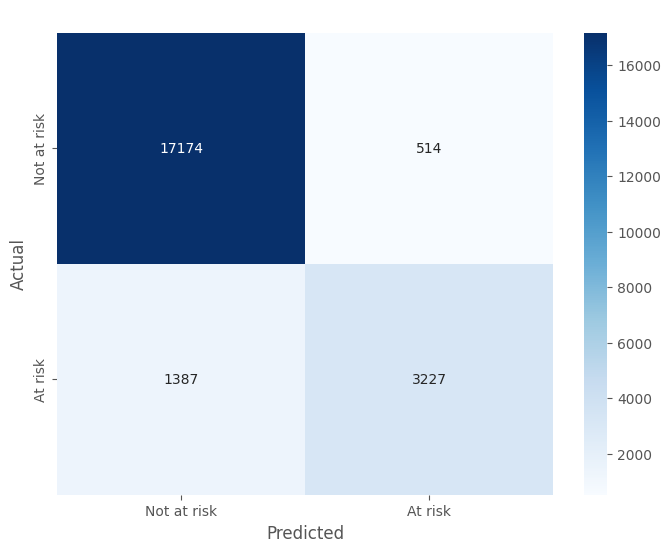

In [6]:
conf_matrix_single = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix_single,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Not at risk", "At risk"],
    yticklabels=["Not at risk", "At risk"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Optimized Model")
plt.show()
plt.close()


# Optuna Single Objective Optimization History


<Figure size 1000x600 with 0 Axes>

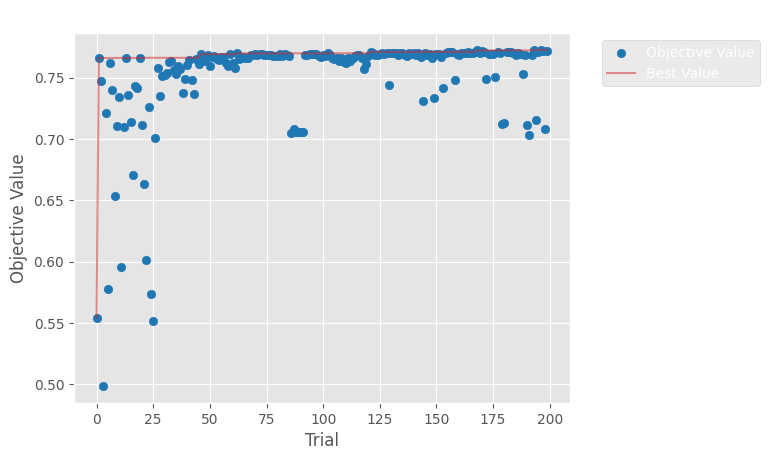

In [ ]:
plt.figure(figsize=(10, 6))
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.title("Optimization History")
plt.savefig("optuna_optimization_history.png")


# ROC & AUC Curve - Single Objective


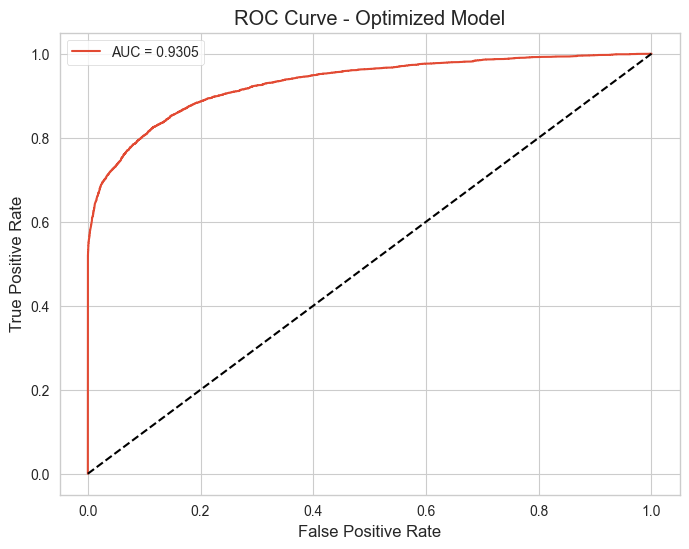

In [13]:
sns.set_style("whitegrid")

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Optimized Model")
plt.legend()
plt.show()
plt.close()


# Precision Recall Curve - Single Objective


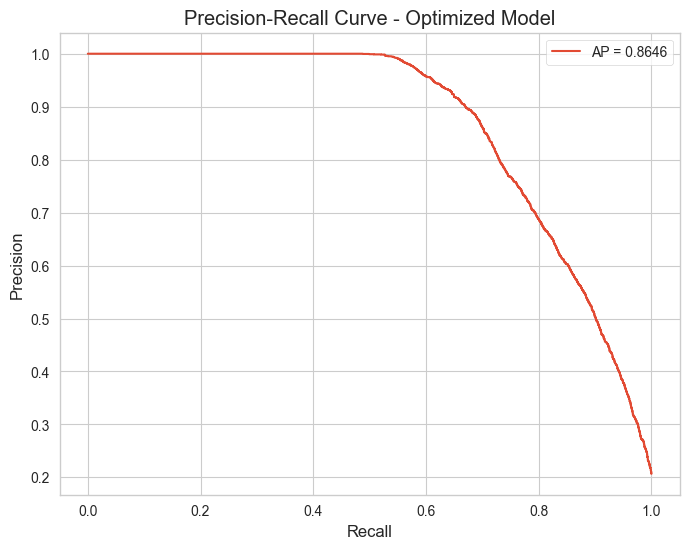

In [14]:
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
ap = average_precision_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall_curve, precision_curve, label=f"AP = {ap:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Optimized Model")
plt.legend()
plt.show()
plt.close()


# Feature Importances - Single Objective


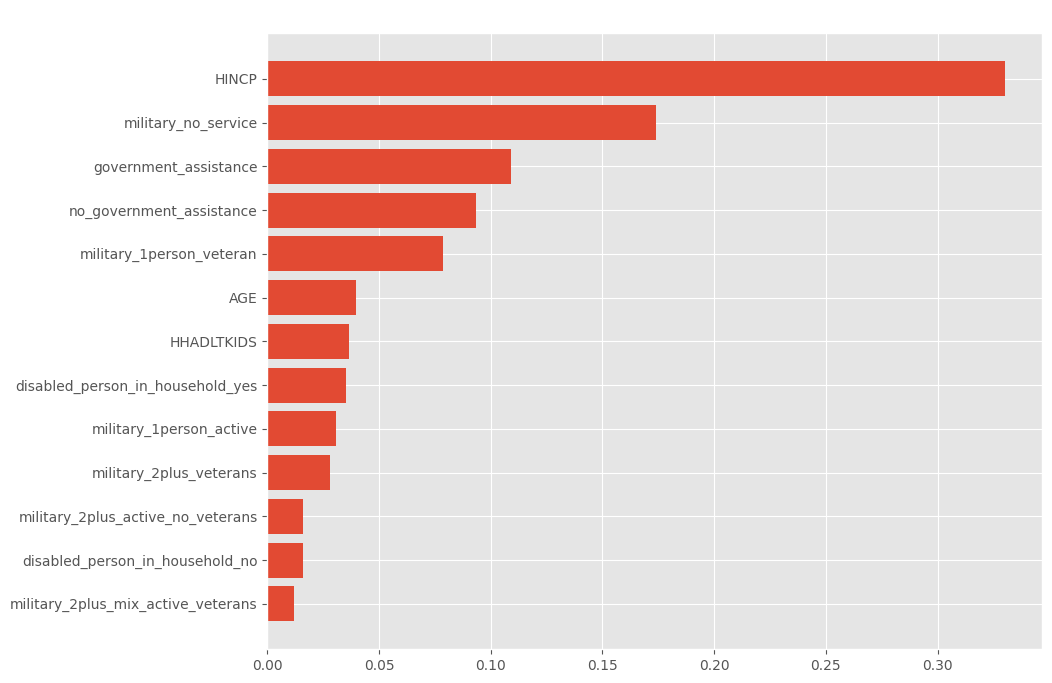

In [10]:
# Built-in XGBoost feature importance - can be biased to high cardinality features
feature_importance = best_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
plt.yticks(range(len(sorted_idx)), np.array(x.columns)[sorted_idx])
plt.title("Optimized XGBoost Feature Importance")
plt.show()
plt.close()


# Permutation Importance - Single Objective


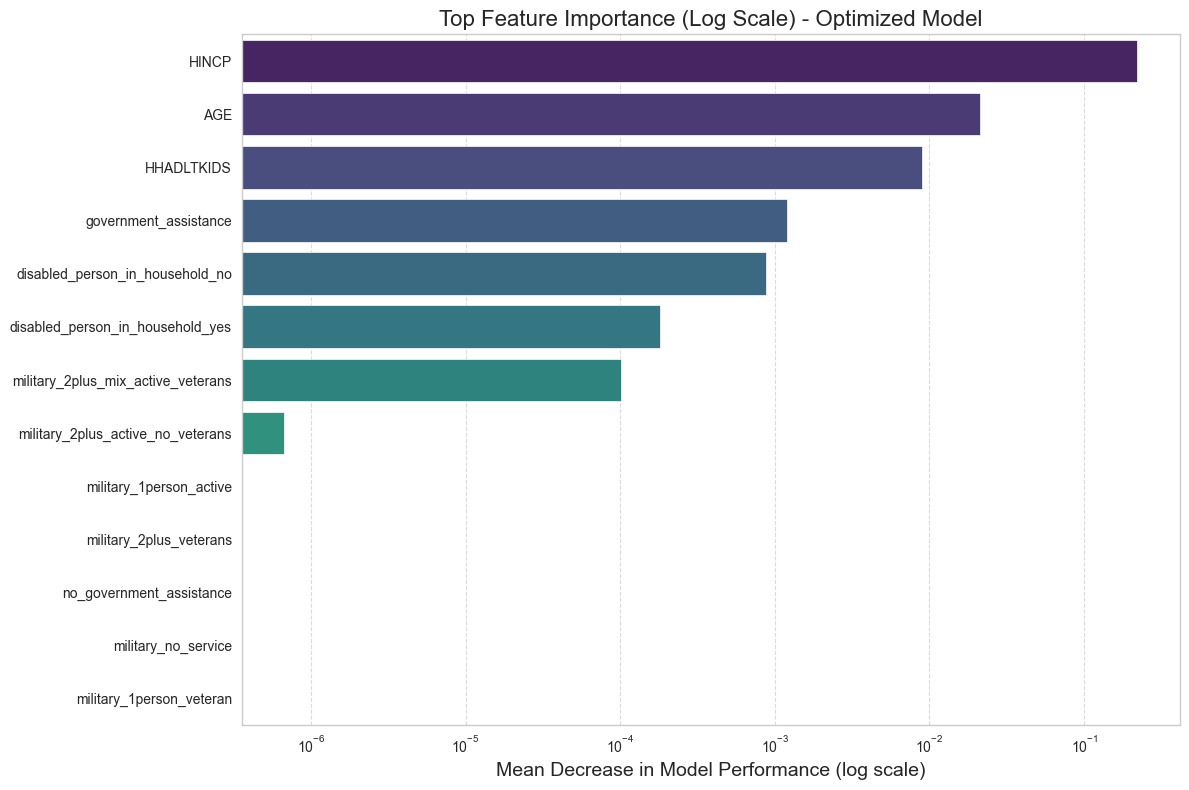

In [15]:
# Needed to use log scale for better visualization of small values
plt.figure(figsize=(12, 8))

result = permutation_importance(
    best_model,
    x_test,
    y_test,
    n_repeats=200,  # Increase for more stable results
    random_state=42,
)

# df for easier manipulation
importance_df = pd.DataFrame(
    {
        "Feature": x.columns,
        "Importance": result.importances_mean,
        "Std": result.importances_std,
    }
)

# add small epsilon to zero values for log scale
importance_df["Importance"] = importance_df["Importance"] + 1e-10  # Prevent log(0)

# Create horizontal bar chart with log scale
sns.barplot(
    x="Importance",
    y="Feature",
    data=importance_df.sort_values(by="Importance", ascending=False),
    palette="viridis",
)

plt.xscale("log")  # Use logarithmic scale for x-axis
plt.title("Top Feature Importance (Log Scale) - Optimized Model", fontsize=16)
plt.xlabel("Mean Decrease in Model Performance (log scale)", fontsize=14)
plt.ylabel("")
plt.tight_layout()
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()
plt.close()


# SHAP - Single Objective


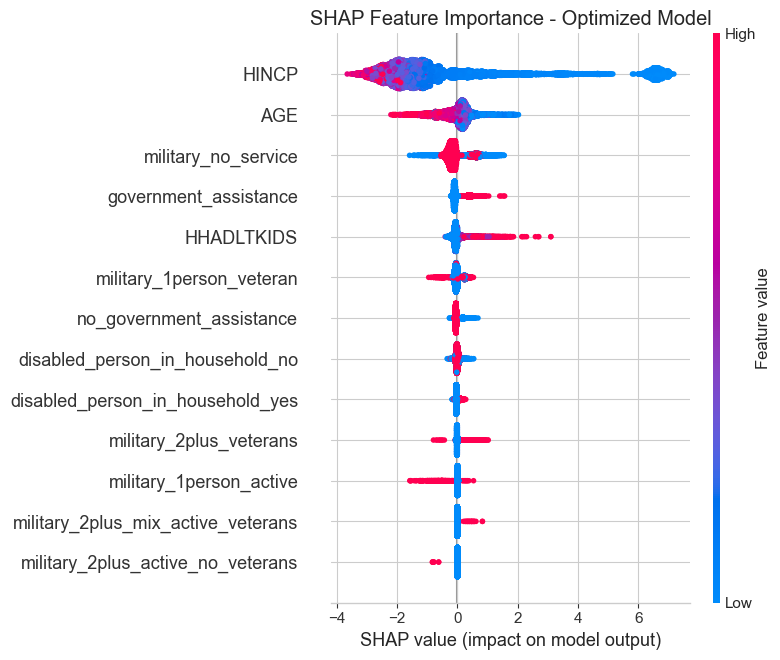

In [ ]:
# X_sample = x_test[:60000]  # Using a sample for visualization if needed
explainer = shap.Explainer(best_model)
shap_values = explainer(x_test)

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, x_test, feature_names=x.columns, show=False)
plt.title("SHAP Feature Importance - Optimized Model")
plt.tight_layout()
plt.show()
plt.close()


# Optuna Multi-Objective


In [ ]:
def objective(trial):

    # Define hyperparameters to optimize

    param = {
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "n-estimators": trial.suggest_int("n_estimators", 50, 300),
        # Parameters specific to tree-based boosters
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "eta": trial.suggest_float("eta", 0.01, 0.3, log=True),
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        "grow_policy": trial.suggest_categorical(
            "grow_policy", ["depthwise", "lossguide"]
        ),
        # Sampling parameters
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        # Handle class imbalance - assuming 4:1 ratio from previous information
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1.0, 6.0),
        # Other parameters
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        # For dart booster
        "sample_type": trial.suggest_categorical(
            "sample_type", ["uniform", "weighted"]
        ),
        "normalize_type": trial.suggest_categorical(
            "normalize_type", ["tree", "forest"]
        ),
        "rate_drop": trial.suggest_float("rate_drop", 0.0, 0.5),
        "skip_drop": trial.suggest_float("skip_drop", 0.0, 0.5),
    }

    # Remove dart-specific parameters if not using dart booster

    if param["booster"] != "dart":

        param.pop("sample_type")

        param.pop("normalize_type")
        param.pop("rate_drop")

        param.pop("skip_drop")

    # Remove tree-specific parameters if using linear booster

    if param["booster"] == "gblinear":

        param.pop("max_depth")
        param.pop("gamma")

        param.pop("grow_policy")

        param.pop("min_child_weight")

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Store metrics across folds to calculate mean values
    f1_scores = []
    auc_scores = []
    precision_scores = []
    recall_scores = []

    # We need to manually implement cross-validation for Hyperband pruning to track resources, evaluate trial during training,
    # and to include the callback mechanism to report to the pruner - runs after each boosting round
    for _, (train_idx, val_idx) in enumerate(cv.split(X_scaled, y)):
        X_fold_train = X_scaled[train_idx]
        X_fold_val = X_scaled[val_idx]
        y_fold_train = y.iloc[train_idx]
        y_fold_val = y.iloc[val_idx]

        # Prepare evaluation set
        eval_set = [(X_fold_val, y_fold_val)]

        model = xgb.XGBClassifier(
            **param,
            random_state=42,
            use_label_encoder=False,
            early_stopping_rounds=15,
        )

        # Train with pruning callback
        model.fit(
            X_fold_train,
            y_fold_train,
            eval_set=eval_set,
            verbose=False,
        )

        # Make predictions
        y_pred = model.predict(X_fold_val)
        y_pred_proba = model.predict_proba(X_fold_val)[:, 1]

        # Calculate metrics for this fold
        fold_f1 = f1_score(y_fold_val, y_pred)
        fold_auc = roc_auc_score(y_fold_val, y_pred_proba)
        fold_precision = precision_score(y_fold_val, y_pred)
        fold_recall = recall_score(y_fold_val, y_pred)

        # Store metrics
        f1_scores.append(fold_f1)
        auc_scores.append(fold_auc)
        precision_scores.append(fold_precision)
        recall_scores.append(fold_recall)

    # Calculate mean scores
    mean_f1 = np.mean(f1_scores) if f1_scores else 0.0
    mean_auc = np.mean(auc_scores) if auc_scores else 0.0
    mean_precision = np.mean(precision_scores) if precision_scores else 0.0
    mean_recall = np.mean(recall_scores) if recall_scores else 0.0

    # Store additional info for analysis
    trial.set_user_attr("mean_f1", mean_f1)
    trial.set_user_attr("mean_auc", mean_auc)
    trial.set_user_attr("mean_precision", mean_precision)
    trial.set_user_attr("mean_recall", mean_recall)

    # Optuna will try to maximize our returned values to improve the model
    return mean_f1, mean_auc, mean_precision, mean_recall

# Hyperband doesn't work with mutli-objective optimization, so we need to remove it

# Making multi-objective directory for optuna trial logs
multi_dir = os.path.join(path, "multi_objective_logs")
os.makedirs(multi_dir, exist_ok=True)

def multi_objective_logging_callback(study, frozen_trial):
    # Get the current, best Pareto front
    pareto_trials = study.best_trials

    # Check if this trial is on the Pareto front
    if frozen_trial.number in [t.number for t in pareto_trials]:
        print(f"\n\nNew Pareto-optimal solution found!")
        print(
            f"\nTrial {frozen_trial.number} finished with values: {frozen_trial.values}"
        )
        print(f"\nParameters: {frozen_trial.params}\n\n")


study = optuna.create_study(
    directions=["maximize", "maximize", "maximize", "maximize"],
    study_name="MVP-XGBClassifier-multi-objective",
    storage=f"sqlite:///{multi_dir}/XGBClassifier-multi_objective_optimization.db",
    load_if_exists=True,
)

study.optimize(
    objective,
    n_trials=100,
    n_jobs=-1,
    show_progress_bar=True,
    callbacks=[multi_objective_logging_callback],
)


# Pareto used for multi-objective optimization
pareto_solutions = study.best_trials

print(f"Found {len(pareto_solutions)} Pareto optimal solutions:")

for i, pareto_trial in enumerate(pareto_solutions):

    print(f"Solution {i+1}:")
    print(f"  F1 Score: {pareto_trial.values[0]:.4f}")
    print(f"  AUC: {pareto_trial.values[1]:.4f}")
    print(f"  Precision: {pareto_trial.values[2]:.4f}")
    print(f"  Recall: {pareto_trial.values[3]:.4f}")

    print("  Parameters:")

    for key, value in pareto_trial.params.items():
        print(f"    {key}: {value}\n\n")

# Create a model with the best parameters
# best_multi_params = pareto_trial.params
# best_multiobj_model = xgb.XGBClassifier(
#     **best_multi_params, random_state=42, use_label_encoder=False
# )

# Train the model on the full training set
# best_multiobj_model.fit(x_train, y_train)

# Make predictions
# y_pred =  best_multiobj_model.predict(x_test)
# y_pred_proba = best_multiobj_model.predict_proba(x_test)[:, 1]

# joblib.dump(
# best_multiobj_model,
#     os.path.join(
#         path,
#         f"best_model_{study.study_name}-{timestamp}.joblib",
#     ),
# )


[I 2025-04-30 11:00:44,797] Using an existing study with name 'MVP-XGBClassifier-multi-objective' instead of creating a new one.
  1%|          | 1/100 [00:11<18:31, 11.22s/it]

[I 2025-04-30 11:00:55,943] Trial 23 finished with values: [0.0, 0.5, 0.0, 0.0] and parameters: {'booster': 'gblinear', 'lambda': 0.005819520956816226, 'alpha': 0.34406149707553957, 'max_depth': 8, 'eta': 0.013008459385877042, 'gamma': 0.00024005671114839337, 'grow_policy': 'depthwise', 'subsample': 0.5536026069971206, 'colsample_bytree': 0.709171369680387, 'scale_pos_weight': 1.4714528261053996, 'min_child_weight': 7, 'learning_rate': 0.25593662936195927, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.3393776421826123, 'skip_drop': 0.4659864520146561}.


New Pareto-optimal solution found!

Trial 23 finished with values: [0.0, 0.5, 0.0, 0.0]

Parameters: {'booster': 'gblinear', 'lambda': 0.005819520956816226, 'alpha': 0.34406149707553957, 'max_depth': 8, 'eta': 0.013008459385877042, 'gamma': 0.00024005671114839337, 'grow_policy': 'depthwise', 'subsample': 0.5536026069971206, 'colsample_bytree': 0.709171369680387, 'scale_pos_weight': 1.4714528261053996, 'min_child_we

  2%|▏         | 2/100 [00:34<30:13, 18.50s/it]

[I 2025-04-30 11:01:19,529] Trial 35 finished with values: [0.47379391499230195, 0.8406564805014443, 0.6521710408621678, 0.37205163161052734] and parameters: {'booster': 'gblinear', 'lambda': 0.0781904920005466, 'alpha': 0.00016915733414210872, 'max_depth': 10, 'eta': 0.015278210276219123, 'gamma': 0.00014582268453208373, 'grow_policy': 'lossguide', 'subsample': 0.8498777573018064, 'colsample_bytree': 0.7369832127834357, 'scale_pos_weight': 1.131514056778106, 'min_child_weight': 3, 'learning_rate': 0.10544335548586585, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.03534142659995809, 'skip_drop': 0.216592938283106}.


New Pareto-optimal solution found!

Trial 35 finished with values: [0.47379391499230195, 0.8406564805014443, 0.6521710408621678, 0.37205163161052734]

Parameters: {'booster': 'gblinear', 'lambda': 0.0781904920005466, 'alpha': 0.00016915733414210872, 'max_depth': 10, 'eta': 0.015278210276219123, 'gamma': 0.00014582268453208373, 'grow_policy': 'lossguide

  3%|▎         | 3/100 [00:46<24:48, 15.35s/it]

[I 2025-04-30 11:01:31,116] Trial 27 finished with values: [0.61947634123839, 0.8818615563986238, 0.4810723115188509, 0.8697361337028665] and parameters: {'booster': 'gblinear', 'lambda': 4.5158534658298804e-07, 'alpha': 3.502062415586881e-07, 'max_depth': 9, 'eta': 0.05109949812841725, 'gamma': 6.72899356844392e-06, 'grow_policy': 'depthwise', 'subsample': 0.8118091191172745, 'colsample_bytree': 0.7708500289316613, 'scale_pos_weight': 4.023749856267418, 'min_child_weight': 6, 'learning_rate': 0.10396524275629448, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.1677029688938918, 'skip_drop': 0.2645669254378157}.


New Pareto-optimal solution found!

Trial 27 finished with values: [0.61947634123839, 0.8818615563986238, 0.4810723115188509, 0.8697361337028665]

Parameters: {'booster': 'gblinear', 'lambda': 4.5158534658298804e-07, 'alpha': 3.502062415586881e-07, 'max_depth': 9, 'eta': 0.05109949812841725, 'gamma': 6.72899356844392e-06, 'grow_policy': 'depthwise', 'subs

  4%|▍         | 4/100 [00:46<15:12,  9.50s/it]

[I 2025-04-30 11:01:31,662] Trial 30 finished with values: [0.6053820102002849, 0.8743207575523855, 0.4675993585334567, 0.8583347000490681] and parameters: {'booster': 'gblinear', 'lambda': 1.729848346530552e-06, 'alpha': 0.053203282233797757, 'max_depth': 8, 'eta': 0.036519755580343996, 'gamma': 0.00011681023138549197, 'grow_policy': 'lossguide', 'subsample': 0.5270967477679752, 'colsample_bytree': 0.5194936649981522, 'scale_pos_weight': 4.054807117417309, 'min_child_weight': 9, 'learning_rate': 0.06165639512933347, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.2136258326975204, 'skip_drop': 0.3891309780092524}.


  5%|▌         | 5/100 [00:47<09:52,  6.24s/it]

[I 2025-04-30 11:01:32,124] Trial 28 finished with values: [0.460434734099762, 0.869688248502257, 0.5733781307541561, 0.38467633547685876] and parameters: {'booster': 'gblinear', 'lambda': 0.2224774577838056, 'alpha': 0.1237061763546599, 'max_depth': 3, 'eta': 0.012070761414844115, 'gamma': 0.0003659906193850061, 'grow_policy': 'lossguide', 'subsample': 0.614493183380032, 'colsample_bytree': 0.9914748557399172, 'scale_pos_weight': 3.1617316511680973, 'min_child_weight': 8, 'learning_rate': 0.0480808159795931, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.33642825689744127, 'skip_drop': 0.014135345490863094}.


New Pareto-optimal solution found!

Trial 28 finished with values: [0.460434734099762, 0.869688248502257, 0.5733781307541561, 0.38467633547685876]

Parameters: {'booster': 'gblinear', 'lambda': 0.2224774577838056, 'alpha': 0.1237061763546599, 'max_depth': 3, 'eta': 0.012070761414844115, 'gamma': 0.0003659906193850061, 'grow_policy': 'lossguide', 'subsample':

  6%|▌         | 6/100 [00:49<07:24,  4.73s/it]

[I 2025-04-30 11:01:33,931] Trial 26 finished with values: [0.5745387318321622, 0.8794271342636837, 0.42315172699772924, 0.894635795778227] and parameters: {'booster': 'gblinear', 'lambda': 0.0010073488828594847, 'alpha': 1.8921531399122654e-08, 'max_depth': 5, 'eta': 0.18011283595126948, 'gamma': 0.00016263511397172944, 'grow_policy': 'depthwise', 'subsample': 0.625986602194937, 'colsample_bytree': 0.7388081715942785, 'scale_pos_weight': 5.1300324599968015, 'min_child_weight': 4, 'learning_rate': 0.16328143118552613, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.29340793937867254, 'skip_drop': 0.3991883559521065}.


New Pareto-optimal solution found!

Trial 26 finished with values: [0.5745387318321622, 0.8794271342636837, 0.42315172699772924, 0.894635795778227]

Parameters: {'booster': 'gblinear', 'lambda': 0.0010073488828594847, 'alpha': 1.8921531399122654e-08, 'max_depth': 5, 'eta': 0.18011283595126948, 'gamma': 0.00016263511397172944, 'grow_policy': 'depthwise'

  7%|▋         | 7/100 [00:50<05:43,  3.70s/it]

[I 2025-04-30 11:01:35,501] Trial 39 finished with values: [0.6280870675165093, 0.8857013847287064, 0.7094442405336723, 0.5635600287787879] and parameters: {'booster': 'gblinear', 'lambda': 7.522812441013223e-08, 'alpha': 0.0005008341894763954, 'max_depth': 9, 'eta': 0.01712465052052758, 'gamma': 0.00019413836108785374, 'grow_policy': 'lossguide', 'subsample': 0.6441948717349291, 'colsample_bytree': 0.9427674906566403, 'scale_pos_weight': 1.4139692599849192, 'min_child_weight': 7, 'learning_rate': 0.05222648974107047, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.09001041296079892, 'skip_drop': 0.10192251320172113}.


New Pareto-optimal solution found!

Trial 39 finished with values: [0.6280870675165093, 0.8857013847287064, 0.7094442405336723, 0.5635600287787879]

Parameters: {'booster': 'gblinear', 'lambda': 7.522812441013223e-08, 'alpha': 0.0005008341894763954, 'max_depth': 9, 'eta': 0.01712465052052758, 'gamma': 0.00019413836108785374, 'grow_policy': 'lossguide

  8%|▊         | 8/100 [00:51<04:24,  2.87s/it]

[I 2025-04-30 11:01:36,617] Trial 31 finished with values: [0.46253419073468993, 0.8247013007854237, 0.5815287093242313, 0.3839774070678619] and parameters: {'booster': 'gblinear', 'lambda': 0.26369319976578526, 'alpha': 1.593679293101147e-07, 'max_depth': 10, 'eta': 0.2852690808397744, 'gamma': 0.011365656076651671, 'grow_policy': 'lossguide', 'subsample': 0.714983825226413, 'colsample_bytree': 0.9701122592521239, 'scale_pos_weight': 1.908236242187241, 'min_child_weight': 6, 'learning_rate': 0.05161891815864154, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.2524672249496551, 'skip_drop': 0.3803452951029983}.


  9%|▉         | 9/100 [00:53<03:45,  2.48s/it]

[I 2025-04-30 11:01:38,223] Trial 36 finished with values: [0.5743724344717918, 0.877640359461469, 0.4244360302639526, 0.8881706531355607] and parameters: {'booster': 'gblinear', 'lambda': 0.00035031708878191384, 'alpha': 0.016772918401153327, 'max_depth': 7, 'eta': 0.039383126597344754, 'gamma': 0.002134624064243313, 'grow_policy': 'lossguide', 'subsample': 0.5007843293075473, 'colsample_bytree': 0.6576541487281247, 'scale_pos_weight': 4.789689766662221, 'min_child_weight': 8, 'learning_rate': 0.12775049066638797, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.4781767007840989, 'skip_drop': 0.4472399052716383}.


New Pareto-optimal solution found!

Trial 36 finished with values: [0.5743724344717918, 0.877640359461469, 0.4244360302639526, 0.8881706531355607]

Parameters: {'booster': 'gblinear', 'lambda': 0.00035031708878191384, 'alpha': 0.016772918401153327, 'max_depth': 7, 'eta': 0.039383126597344754, 'gamma': 0.002134624064243313, 'grow_policy': 'lossguide', 'sub

 10%|█         | 10/100 [01:50<28:47, 19.20s/it]

[I 2025-04-30 11:02:34,847] Trial 44 finished with values: [0.5734262242118922, 0.8712953870797591, 0.6126600866999634, 0.5389664728649444] and parameters: {'booster': 'gblinear', 'lambda': 0.00012470480818432657, 'alpha': 0.000531992904227418, 'max_depth': 3, 'eta': 0.2745562623554981, 'gamma': 4.293897011862689e-08, 'grow_policy': 'lossguide', 'subsample': 0.6117272335484534, 'colsample_bytree': 0.8275617425634645, 'scale_pos_weight': 2.094542407766677, 'min_child_weight': 10, 'learning_rate': 0.010139760341315186, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.40846199834353336, 'skip_drop': 0.40996372586181395}.


 11%|█         | 11/100 [01:54<21:32, 14.52s/it]

[I 2025-04-30 11:02:38,763] Trial 46 finished with values: [0.5700531957426571, 0.8798703252832472, 0.41779996870953334, 0.8969509692996052] and parameters: {'booster': 'gblinear', 'lambda': 1.7793909176599868e-07, 'alpha': 0.0005741743076188082, 'max_depth': 9, 'eta': 0.013707237126204858, 'gamma': 5.4581918756268104e-05, 'grow_policy': 'depthwise', 'subsample': 0.6303521506512781, 'colsample_bytree': 0.7592682782877205, 'scale_pos_weight': 5.272757225375693, 'min_child_weight': 9, 'learning_rate': 0.15922331559497352, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.03221174974149449, 'skip_drop': 0.49764342805292267}.


New Pareto-optimal solution found!

Trial 46 finished with values: [0.5700531957426571, 0.8798703252832472, 0.41779996870953334, 0.8969509692996052]

Parameters: {'booster': 'gblinear', 'lambda': 1.7793909176599868e-07, 'alpha': 0.0005741743076188082, 'max_depth': 9, 'eta': 0.013707237126204858, 'gamma': 5.4581918756268104e-05, 'grow_policy': 'dept

 12%|█▏        | 12/100 [02:01<18:11, 12.41s/it]

[I 2025-04-30 11:02:46,336] Trial 37 finished with values: [0.7177274972513501, 0.9295602737036257, 0.6374574615053585, 0.821290979170489] and parameters: {'booster': 'gbtree', 'lambda': 2.8757102121832403e-05, 'alpha': 1.3242849039372424e-05, 'max_depth': 3, 'eta': 0.02592113391039175, 'gamma': 3.94575594326214e-06, 'grow_policy': 'depthwise', 'subsample': 0.9283210344840613, 'colsample_bytree': 0.9070774081528599, 'scale_pos_weight': 4.141733214630761, 'min_child_weight': 9, 'learning_rate': 0.24663960145119956, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.19112215386861958, 'skip_drop': 0.343914516093761}.


New Pareto-optimal solution found!

Trial 37 finished with values: [0.7177274972513501, 0.9295602737036257, 0.6374574615053585, 0.821290979170489]

Parameters: {'booster': 'gbtree', 'lambda': 2.8757102121832403e-05, 'alpha': 1.3242849039372424e-05, 'max_depth': 3, 'eta': 0.02592113391039175, 'gamma': 3.94575594326214e-06, 'grow_policy': 'depthwise', 'sub

 13%|█▎        | 13/100 [02:15<18:45, 12.93s/it]

[I 2025-04-30 11:03:00,477] Trial 38 finished with values: [0.7084075528297573, 0.9267036937003036, 0.6210438601928802, 0.8244360949959505] and parameters: {'booster': 'gbtree', 'lambda': 0.08542172553205138, 'alpha': 0.2699345308625027, 'max_depth': 9, 'eta': 0.16551042877325792, 'gamma': 0.010900574218541877, 'grow_policy': 'depthwise', 'subsample': 0.533690061502513, 'colsample_bytree': 0.918194592163156, 'scale_pos_weight': 5.624245804970894, 'min_child_weight': 3, 'learning_rate': 0.27474643490728207, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.4260628207226318, 'skip_drop': 0.4906231684168292}.


New Pareto-optimal solution found!

Trial 38 finished with values: [0.7084075528297573, 0.9267036937003036, 0.6210438601928802, 0.8244360949959505]

Parameters: {'booster': 'gbtree', 'lambda': 0.08542172553205138, 'alpha': 0.2699345308625027, 'max_depth': 9, 'eta': 0.16551042877325792, 'gamma': 0.010900574218541877, 'grow_policy': 'depthwise', 'subsample': 0.533

 14%|█▍        | 14/100 [02:48<27:00, 18.84s/it]

[I 2025-04-30 11:03:32,953] Trial 33 finished with values: [0.7440667511149883, 0.9313495173801742, 0.705149049310573, 0.7877417763068449] and parameters: {'booster': 'gbtree', 'lambda': 6.344566980730787e-07, 'alpha': 1.0336590088121464e-07, 'max_depth': 4, 'eta': 0.10938216253198862, 'gamma': 0.00038557035495633815, 'grow_policy': 'depthwise', 'subsample': 0.9007655731181443, 'colsample_bytree': 0.9588824340541175, 'scale_pos_weight': 3.243633933775093, 'min_child_weight': 2, 'learning_rate': 0.2043961298877552, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.020070794135843895, 'skip_drop': 0.2413909397593027}.


New Pareto-optimal solution found!

Trial 33 finished with values: [0.7440667511149883, 0.9313495173801742, 0.705149049310573, 0.7877417763068449]

Parameters: {'booster': 'gbtree', 'lambda': 6.344566980730787e-07, 'alpha': 1.0336590088121464e-07, 'max_depth': 4, 'eta': 0.10938216253198862, 'gamma': 0.00038557035495633815, 'grow_policy': 'depthwise', '

 15%|█▌        | 15/100 [02:56<22:16, 15.73s/it]

[I 2025-04-30 11:03:41,487] Trial 34 finished with values: [0.7646057253159039, 0.9287654021364045, 0.806610531860235, 0.7268471723677079] and parameters: {'booster': 'gbtree', 'lambda': 1.1364248205020983e-07, 'alpha': 5.4652129087024876e-08, 'max_depth': 3, 'eta': 0.22288947481333235, 'gamma': 5.384767876182406e-07, 'grow_policy': 'depthwise', 'subsample': 0.964587255866322, 'colsample_bytree': 0.8512629038027897, 'scale_pos_weight': 2.150170389807263, 'min_child_weight': 10, 'learning_rate': 0.1317000687443684, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.18108704518097002, 'skip_drop': 0.00051552655165088}.


New Pareto-optimal solution found!

Trial 34 finished with values: [0.7646057253159039, 0.9287654021364045, 0.806610531860235, 0.7268471723677079]

Parameters: {'booster': 'gbtree', 'lambda': 1.1364248205020983e-07, 'alpha': 5.4652129087024876e-08, 'max_depth': 3, 'eta': 0.22288947481333235, 'gamma': 5.384767876182406e-07, 'grow_policy': 'depthwise', 'su

 16%|█▌        | 16/100 [03:17<24:03, 17.18s/it]

[I 2025-04-30 11:04:02,032] Trial 53 finished with values: [0.4613685566443242, 0.8446220840664965, 0.5767711055057907, 0.3844579185601523] and parameters: {'booster': 'gblinear', 'lambda': 0.17094748509334845, 'alpha': 0.026253820810351713, 'max_depth': 6, 'eta': 0.25384375262701353, 'gamma': 0.0012543503349345148, 'grow_policy': 'lossguide', 'subsample': 0.9633530922872414, 'colsample_bytree': 0.6358998007480237, 'scale_pos_weight': 2.709957703684137, 'min_child_weight': 2, 'learning_rate': 0.2312756194054131, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.2697358246163536, 'skip_drop': 0.029666453233723022}.


 17%|█▋        | 17/100 [04:29<46:30, 33.62s/it]

[I 2025-04-30 11:05:13,866] Trial 43 finished with values: [0.7646056421728281, 0.9270982265500309, 0.8212855297471269, 0.7153150492051058] and parameters: {'booster': 'gbtree', 'lambda': 0.00917593710420188, 'alpha': 0.000499790595210124, 'max_depth': 3, 'eta': 0.06112551637371046, 'gamma': 3.213356055151967e-07, 'grow_policy': 'depthwise', 'subsample': 0.907153722946143, 'colsample_bytree': 0.7007784458319407, 'scale_pos_weight': 1.9879539698159805, 'min_child_weight': 9, 'learning_rate': 0.04546052972204825, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.4879928433386599, 'skip_drop': 0.4316881832994597}.


New Pareto-optimal solution found!

Trial 43 finished with values: [0.7646056421728281, 0.9270982265500309, 0.8212855297471269, 0.7153150492051058]

Parameters: {'booster': 'gbtree', 'lambda': 0.00917593710420188, 'alpha': 0.000499790595210124, 'max_depth': 3, 'eta': 0.06112551637371046, 'gamma': 3.213356055151967e-07, 'grow_policy': 'depthwise', 'subsample': 

 18%|█▊        | 18/100 [05:10<49:14, 36.03s/it]

[I 2025-04-30 11:05:55,533] Trial 55 finished with values: [0.7651315763870087, 0.9312014391111043, 0.9041150879189802, 0.6632879640953997] and parameters: {'booster': 'gbtree', 'lambda': 4.7255142130293604e-07, 'alpha': 0.004630655923001659, 'max_depth': 9, 'eta': 0.10291724251279225, 'gamma': 0.3865594406058714, 'grow_policy': 'depthwise', 'subsample': 0.9737069606315996, 'colsample_bytree': 0.8458774622029481, 'scale_pos_weight': 1.0074190946141646, 'min_child_weight': 8, 'learning_rate': 0.18530768728132443, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.03926103254841784, 'skip_drop': 0.14238798634520927}.


New Pareto-optimal solution found!

Trial 55 finished with values: [0.7651315763870087, 0.9312014391111043, 0.9041150879189802, 0.6632879640953997]

Parameters: {'booster': 'gbtree', 'lambda': 4.7255142130293604e-07, 'alpha': 0.004630655923001659, 'max_depth': 9, 'eta': 0.10291724251279225, 'gamma': 0.3865594406058714, 'grow_policy': 'depthwise', 'subsample

 19%|█▉        | 19/100 [05:21<38:33, 28.56s/it]

[I 2025-04-30 11:06:06,677] Trial 45 finished with values: [0.7430260391572078, 0.9291561343931181, 0.7056887710633872, 0.7846405957411327] and parameters: {'booster': 'gbtree', 'lambda': 2.714330074414099e-05, 'alpha': 1.3817873632223004e-08, 'max_depth': 4, 'eta': 0.030664596326918928, 'gamma': 0.2354973855934183, 'grow_policy': 'depthwise', 'subsample': 0.890217379019826, 'colsample_bytree': 0.9955744832195531, 'scale_pos_weight': 3.2958715156904757, 'min_child_weight': 6, 'learning_rate': 0.045818400854406, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.43755471161788273, 'skip_drop': 0.13026186664406803}.


New Pareto-optimal solution found!

Trial 45 finished with values: [0.7430260391572078, 0.9291561343931181, 0.7056887710633872, 0.7846405957411327]

Parameters: {'booster': 'gbtree', 'lambda': 2.714330074414099e-05, 'alpha': 1.3817873632223004e-08, 'max_depth': 4, 'eta': 0.030664596326918928, 'gamma': 0.2354973855934183, 'grow_policy': 'depthwise', 'subsampl

 20%|██        | 20/100 [05:28<29:24, 22.05s/it]

[I 2025-04-30 11:06:13,547] Trial 21 finished with values: [0.7542787004891233, 0.933167733035446, 0.7407631032743216, 0.7684773908962516] and parameters: {'booster': 'gbtree', 'lambda': 2.133462700559914e-05, 'alpha': 1.2012634868346455e-06, 'max_depth': 6, 'eta': 0.010472126388845896, 'gamma': 0.000994724892764287, 'grow_policy': 'depthwise', 'subsample': 0.8137740302485996, 'colsample_bytree': 0.9292374160673944, 'scale_pos_weight': 2.8713031581640522, 'min_child_weight': 1, 'learning_rate': 0.08510445085926967, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.309863542447788, 'skip_drop': 0.3613922688339818}.


New Pareto-optimal solution found!

Trial 21 finished with values: [0.7542787004891233, 0.933167733035446, 0.7407631032743216, 0.7684773908962516]

Parameters: {'booster': 'gbtree', 'lambda': 2.133462700559914e-05, 'alpha': 1.2012634868346455e-06, 'max_depth': 6, 'eta': 0.010472126388845896, 'gamma': 0.000994724892764287, 'grow_policy': 'depthwise', 'sub

 21%|██        | 21/100 [06:06<35:16, 26.80s/it]

[I 2025-04-30 11:06:51,401] Trial 56 finished with values: [0.4946252130036397, 0.8798962861807087, 0.6639514671481782, 0.394155475101397] and parameters: {'booster': 'gblinear', 'lambda': 4.256735262522448e-05, 'alpha': 0.00016814723296928712, 'max_depth': 6, 'eta': 0.0903269476045729, 'gamma': 0.02520020059113942, 'grow_policy': 'lossguide', 'subsample': 0.8814737020059951, 'colsample_bytree': 0.9321982048753735, 'scale_pos_weight': 1.1327715518431765, 'min_child_weight': 6, 'learning_rate': 0.01882291307155539, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.45125504246537257, 'skip_drop': 0.25259745303154163}.


 22%|██▏       | 22/100 [06:54<42:56, 33.03s/it]

[I 2025-04-30 11:07:38,979] Trial 57 finished with values: [0.7005259852831606, 0.8833938970953727, 0.6217491252944675, 0.8022450583804671] and parameters: {'booster': 'gblinear', 'lambda': 0.0006466500197277197, 'alpha': 0.0008342590866514122, 'max_depth': 10, 'eta': 0.012843295716444643, 'gamma': 0.262746520394269, 'grow_policy': 'lossguide', 'subsample': 0.7020758512933496, 'colsample_bytree': 0.8732458117478383, 'scale_pos_weight': 2.56318960145346, 'min_child_weight': 3, 'learning_rate': 0.06665959851175245, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.298011091226577, 'skip_drop': 0.32627345631570076}.


 23%|██▎       | 23/100 [07:46<49:51, 38.86s/it]

[I 2025-04-30 11:08:31,406] Trial 41 finished with values: [0.6993578732755505, 0.9319917178571601, 0.5924477779821828, 0.8535295851261638] and parameters: {'booster': 'gbtree', 'lambda': 6.106805737191377e-05, 'alpha': 8.162344745687496e-08, 'max_depth': 6, 'eta': 0.017450599803673944, 'gamma': 5.051185366354765e-06, 'grow_policy': 'depthwise', 'subsample': 0.9789287519956742, 'colsample_bytree': 0.5873250696723307, 'scale_pos_weight': 5.654308291507241, 'min_child_weight': 8, 'learning_rate': 0.12325808999601515, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.011444082238898257, 'skip_drop': 0.44681429844270437}.


New Pareto-optimal solution found!

Trial 41 finished with values: [0.6993578732755505, 0.9319917178571601, 0.5924477779821828, 0.8535295851261638]

Parameters: {'booster': 'gbtree', 'lambda': 6.106805737191377e-05, 'alpha': 8.162344745687496e-08, 'max_depth': 6, 'eta': 0.017450599803673944, 'gamma': 5.051185366354765e-06, 'grow_policy': 'depthwise', '

 24%|██▍       | 24/100 [08:45<56:43, 44.79s/it]

[I 2025-04-30 11:09:30,021] Trial 61 finished with values: [0.4700167285704794, 0.8495963885666878, 0.574139854247311, 0.39786864855236426] and parameters: {'booster': 'gblinear', 'lambda': 0.12516456647611485, 'alpha': 0.022734422863431795, 'max_depth': 5, 'eta': 0.148208469026417, 'gamma': 1.3045714501062558e-05, 'grow_policy': 'lossguide', 'subsample': 0.6414204281268123, 'colsample_bytree': 0.8199709785164622, 'scale_pos_weight': 3.0123439144040143, 'min_child_weight': 4, 'learning_rate': 0.04294750831429617, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.36395904484606106, 'skip_drop': 0.49594020207140427}.


 25%|██▌       | 25/100 [08:57<43:51, 35.09s/it]

[I 2025-04-30 11:09:42,489] Trial 52 finished with values: [0.7701150657047834, 0.9295820350414017, 0.8554108596433105, 0.7003316181885679] and parameters: {'booster': 'dart', 'lambda': 3.4568404453187136e-08, 'alpha': 2.915275981520759e-07, 'max_depth': 8, 'eta': 0.024563484534522943, 'gamma': 0.018184259771758107, 'grow_policy': 'depthwise', 'subsample': 0.8160597637254587, 'colsample_bytree': 0.6600571646741099, 'scale_pos_weight': 2.4270781261429777, 'min_child_weight': 5, 'learning_rate': 0.19038524806277934, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.26336303356024, 'skip_drop': 0.34398271883776177}.


New Pareto-optimal solution found!

Trial 52 finished with values: [0.7701150657047834, 0.9295820350414017, 0.8554108596433105, 0.7003316181885679]

Parameters: {'booster': 'dart', 'lambda': 3.4568404453187136e-08, 'alpha': 2.915275981520759e-07, 'max_depth': 8, 'eta': 0.024563484534522943, 'gamma': 0.018184259771758107, 'grow_policy': 'depthwise', 'subsam

 26%|██▌       | 26/100 [11:31<1:27:09, 70.66s/it]

[I 2025-04-30 11:12:16,163] Trial 24 finished with values: [0.6859955470454087, 0.9293926026324455, 0.5660489146263779, 0.8705659805992196] and parameters: {'booster': 'dart', 'lambda': 0.8539165358083947, 'alpha': 6.11914695149371e-08, 'max_depth': 9, 'eta': 0.10021648490435814, 'gamma': 1.1103884553832459e-08, 'grow_policy': 'depthwise', 'subsample': 0.860047394826926, 'colsample_bytree': 0.6638379677775641, 'scale_pos_weight': 5.036806218909088, 'min_child_weight': 7, 'learning_rate': 0.10902427453913423, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.2791660868514771, 'skip_drop': 0.11157213089124662}.


New Pareto-optimal solution found!

Trial 24 finished with values: [0.6859955470454087, 0.9293926026324455, 0.5660489146263779, 0.8705659805992196]

Parameters: {'booster': 'dart', 'lambda': 0.8539165358083947, 'alpha': 6.11914695149371e-08, 'max_depth': 9, 'eta': 0.10021648490435814, 'gamma': 1.1103884553832459e-08, 'grow_policy': 'depthwise', 'subsample': 0

 27%|██▋       | 27/100 [12:20<1:18:06, 64.19s/it]

[I 2025-04-30 11:13:05,262] Trial 58 finished with values: [0.7099739998314741, 0.9267349533742262, 0.6194737511562931, 0.831643843706491] and parameters: {'booster': 'gbtree', 'lambda': 1.6069538145922802e-06, 'alpha': 1.4393885258519685e-06, 'max_depth': 4, 'eta': 0.01350498296968447, 'gamma': 8.119503918861314e-07, 'grow_policy': 'depthwise', 'subsample': 0.9034031915991477, 'colsample_bytree': 0.6800562454364311, 'scale_pos_weight': 4.314321071851419, 'min_child_weight': 5, 'learning_rate': 0.02088554978792842, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.4947809428599212, 'skip_drop': 0.46732432138671987}.


New Pareto-optimal solution found!

Trial 58 finished with values: [0.7099739998314741, 0.9267349533742262, 0.6194737511562931, 0.831643843706491]

Parameters: {'booster': 'gbtree', 'lambda': 1.6069538145922802e-06, 'alpha': 1.4393885258519685e-06, 'max_depth': 4, 'eta': 0.01350498296968447, 'gamma': 8.119503918861314e-07, 'grow_policy': 'depthwise', 'su

 28%|██▊       | 28/100 [12:52<1:05:20, 54.46s/it]

[I 2025-04-30 11:13:36,986] Trial 66 finished with values: [0.5212651223393074, 0.8194645358643655, 0.5460049777297984, 0.49869018543541854] and parameters: {'booster': 'gblinear', 'lambda': 0.6015630776637668, 'alpha': 0.0014121351752954911, 'max_depth': 10, 'eta': 0.11326940169451882, 'gamma': 0.006867296944189916, 'grow_policy': 'lossguide', 'subsample': 0.7179295663261263, 'colsample_bytree': 0.9277126021390409, 'scale_pos_weight': 3.5916104801882156, 'min_child_weight': 1, 'learning_rate': 0.28330396407614405, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.3559169992530484, 'skip_drop': 0.35753385407974797}.


 29%|██▉       | 29/100 [13:44<1:03:44, 53.87s/it]

[I 2025-04-30 11:14:29,460] Trial 32 finished with values: [0.6564975779694808, 0.92703566547456, 0.5203893130979266, 0.8890878839719878] and parameters: {'booster': 'dart', 'lambda': 0.023156792354428437, 'alpha': 4.856143007839382e-06, 'max_depth': 6, 'eta': 0.029770456336648654, 'gamma': 4.544841746102559e-05, 'grow_policy': 'lossguide', 'subsample': 0.7970061863398149, 'colsample_bytree': 0.5850934922203042, 'scale_pos_weight': 5.853603205281371, 'min_child_weight': 7, 'learning_rate': 0.2330232843187936, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.2397460660931945, 'skip_drop': 0.15395519989660272}.


New Pareto-optimal solution found!

Trial 32 finished with values: [0.6564975779694808, 0.92703566547456, 0.5203893130979266, 0.8890878839719878]

Parameters: {'booster': 'dart', 'lambda': 0.023156792354428437, 'alpha': 4.856143007839382e-06, 'max_depth': 6, 'eta': 0.029770456336648654, 'gamma': 4.544841746102559e-05, 'grow_policy': 'lossguide', 'subsample':

 30%|███       | 30/100 [14:50<1:07:02, 57.46s/it]

[I 2025-04-30 11:15:35,336] Trial 67 finished with values: [0.45353199467795113, 0.8141250005577281, 0.6693532142623311, 0.343045554042707] and parameters: {'booster': 'gblinear', 'lambda': 0.6805148792335202, 'alpha': 0.00010047851988623262, 'max_depth': 3, 'eta': 0.2375295020761186, 'gamma': 0.021694534092161884, 'grow_policy': 'depthwise', 'subsample': 0.5046253924260832, 'colsample_bytree': 0.5651647886877269, 'scale_pos_weight': 1.852273195288296, 'min_child_weight': 10, 'learning_rate': 0.01680479198277354, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.33850408632447077, 'skip_drop': 0.38555538416602464}.


 31%|███       | 31/100 [16:50<1:27:35, 76.16s/it]

[I 2025-04-30 11:17:35,131] Trial 69 finished with values: [0.5492011468323408, 0.8213419843742559, 0.42355722523924716, 0.780884879983277] and parameters: {'booster': 'gblinear', 'lambda': 0.4859156260846515, 'alpha': 2.4184929907042774e-05, 'max_depth': 6, 'eta': 0.04518315066529113, 'gamma': 1.7875634822503108e-08, 'grow_policy': 'lossguide', 'subsample': 0.7595483386436361, 'colsample_bytree': 0.6200462612813025, 'scale_pos_weight': 4.855020885094091, 'min_child_weight': 2, 'learning_rate': 0.010228638690577012, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.029949939812241866, 'skip_drop': 0.13039622655988214}.


 31%|███       | 31/100 [23:32<1:27:35, 76.16s/it]

[I 2025-04-30 11:24:17,401] Trial 62 finished with values: [0.7666499495473439, 0.930175676215572, 0.8958284133416987, 0.6701463774018777] and parameters: {'booster': 'gbtree', 'lambda': 0.003562885807750607, 'alpha': 1.929895817770581e-07, 'max_depth': 6, 'eta': 0.29276920528417516, 'gamma': 0.0004465153475424818, 'grow_policy': 'lossguide', 'subsample': 0.9223445390045556, 'colsample_bytree': 0.5344037850528858, 'scale_pos_weight': 1.0651422837012312, 'min_child_weight': 4, 'learning_rate': 0.22889409782192796, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.4327673789633739, 'skip_drop': 0.4533424755700529}.


 32%|███▏      | 32/100 [23:33<3:17:17, 174.08s/it]



New Pareto-optimal solution found!

Trial 62 finished with values: [0.7666499495473439, 0.930175676215572, 0.8958284133416987, 0.6701463774018777]

Parameters: {'booster': 'gbtree', 'lambda': 0.003562885807750607, 'alpha': 1.929895817770581e-07, 'max_depth': 6, 'eta': 0.29276920528417516, 'gamma': 0.0004465153475424818, 'grow_policy': 'lossguide', 'subsample': 0.9223445390045556, 'colsample_bytree': 0.5344037850528858, 'scale_pos_weight': 1.0651422837012312, 'min_child_weight': 4, 'learning_rate': 0.22889409782192796, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.4327673789633739, 'skip_drop': 0.4533424755700529}




 33%|███▎      | 33/100 [23:39<2:18:16, 123.82s/it]

[I 2025-04-30 11:24:24,227] Trial 65 finished with values: [0.7065354892740096, 0.9290722061018668, 0.6092585435420059, 0.8411232218503548] and parameters: {'booster': 'dart', 'lambda': 0.0006008047841824193, 'alpha': 0.011837999807480449, 'max_depth': 7, 'eta': 0.03729488016193275, 'gamma': 0.0003116793536416674, 'grow_policy': 'depthwise', 'subsample': 0.6104774484608061, 'colsample_bytree': 0.7504968985610676, 'scale_pos_weight': 4.25394650041099, 'min_child_weight': 4, 'learning_rate': 0.23020929812816482, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.26632916842735915, 'skip_drop': 0.05587353398570161}.


New Pareto-optimal solution found!

Trial 65 finished with values: [0.7065354892740096, 0.9290722061018668, 0.6092585435420059, 0.8411232218503548]

Parameters: {'booster': 'dart', 'lambda': 0.0006008047841824193, 'alpha': 0.011837999807480449, 'max_depth': 7, 'eta': 0.03729488016193275, 'gamma': 0.0003116793536416674, 'grow_policy': 'depthwise', 'subsample

 34%|███▍      | 34/100 [25:01<2:02:22, 111.25s/it]

[I 2025-04-30 11:25:46,138] Trial 22 finished with values: [0.7451961526573019, 0.9258493093111735, 0.7226277677294443, 0.7696132103832996] and parameters: {'booster': 'dart', 'lambda': 0.06942188342882677, 'alpha': 0.17450940769209164, 'max_depth': 4, 'eta': 0.026004639137426032, 'gamma': 0.00044473964065575304, 'grow_policy': 'depthwise', 'subsample': 0.7728783437897871, 'colsample_bytree': 0.9993671466522716, 'scale_pos_weight': 3.4785163817734537, 'min_child_weight': 10, 'learning_rate': 0.055591143365037336, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.32437271167485615, 'skip_drop': 0.34689217177553433}.


New Pareto-optimal solution found!

Trial 22 finished with values: [0.7451961526573019, 0.9258493093111735, 0.7226277677294443, 0.7696132103832996]

Parameters: {'booster': 'dart', 'lambda': 0.06942188342882677, 'alpha': 0.17450940769209164, 'max_depth': 4, 'eta': 0.026004639137426032, 'gamma': 0.00044473964065575304, 'grow_policy': 'depthwise', 'subsamp

 35%|███▌      | 35/100 [26:52<2:00:35, 111.31s/it]

[I 2025-04-30 11:27:37,615] Trial 73 finished with values: [0.5251923347169063, 0.8729278170770168, 0.36706307165983854, 0.9227241463894232] and parameters: {'booster': 'gblinear', 'lambda': 4.621459705643478e-06, 'alpha': 2.31676612308429e-08, 'max_depth': 7, 'eta': 0.015833358454259705, 'gamma': 6.520419225807014e-07, 'grow_policy': 'depthwise', 'subsample': 0.8804175388867785, 'colsample_bytree': 0.5395810329136692, 'scale_pos_weight': 5.901256382092829, 'min_child_weight': 1, 'learning_rate': 0.01717166954979445, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.3419822515002739, 'skip_drop': 0.24717384898068445}.


New Pareto-optimal solution found!

Trial 73 finished with values: [0.5251923347169063, 0.8729278170770168, 0.36706307165983854, 0.9227241463894232]

Parameters: {'booster': 'gblinear', 'lambda': 4.621459705643478e-06, 'alpha': 2.31676612308429e-08, 'max_depth': 7, 'eta': 0.015833358454259705, 'gamma': 6.520419225807014e-07, 'grow_policy': 'depthwise',

 36%|███▌      | 36/100 [27:59<1:44:22, 97.86s/it] 

[I 2025-04-30 11:28:44,073] Trial 74 finished with values: [0.5903760073356563, 0.8751411100273074, 0.4453887602879677, 0.8753713626637687] and parameters: {'booster': 'gblinear', 'lambda': 0.0030349018924868045, 'alpha': 0.02690908507704308, 'max_depth': 7, 'eta': 0.12752766576318506, 'gamma': 0.021470933633934777, 'grow_policy': 'lossguide', 'subsample': 0.9274142078789644, 'colsample_bytree': 0.5965700311693536, 'scale_pos_weight': 4.377229810294111, 'min_child_weight': 1, 'learning_rate': 0.24414975463061084, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.2926172906465851, 'skip_drop': 0.17303874507355355}.


 37%|███▋      | 37/100 [30:37<2:01:51, 116.06s/it]

[I 2025-04-30 11:31:22,587] Trial 71 finished with values: [0.7665520283130876, 0.9284134973824651, 0.8287783363078189, 0.7130872882461207] and parameters: {'booster': 'gbtree', 'lambda': 0.005541731799401498, 'alpha': 1.0899171918906625e-05, 'max_depth': 4, 'eta': 0.08518270679233945, 'gamma': 1.2163555960166514e-06, 'grow_policy': 'depthwise', 'subsample': 0.8438196006173386, 'colsample_bytree': 0.812455072069852, 'scale_pos_weight': 1.9099683123846796, 'min_child_weight': 5, 'learning_rate': 0.038425638533990614, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.24627668707282335, 'skip_drop': 0.21148297572754005}.


New Pareto-optimal solution found!

Trial 71 finished with values: [0.7665520283130876, 0.9284134973824651, 0.8287783363078189, 0.7130872882461207]

Parameters: {'booster': 'gbtree', 'lambda': 0.005541731799401498, 'alpha': 1.0899171918906625e-05, 'max_depth': 4, 'eta': 0.08518270679233945, 'gamma': 1.2163555960166514e-06, 'grow_policy': 'depthwise',

 38%|███▊      | 38/100 [33:44<2:21:49, 137.26s/it]

[I 2025-04-30 11:34:29,314] Trial 20 finished with values: [0.7105920981119274, 0.9290971976192683, 0.617221183631689, 0.8373666378821545] and parameters: {'booster': 'dart', 'lambda': 0.21370846934113832, 'alpha': 0.013575354446658009, 'max_depth': 8, 'eta': 0.07917935952809313, 'gamma': 0.0016666010313161677, 'grow_policy': 'lossguide', 'subsample': 0.7529377573024993, 'colsample_bytree': 0.6432980098372718, 'scale_pos_weight': 4.288314507070195, 'min_child_weight': 9, 'learning_rate': 0.11425508031451842, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.1974445797259648, 'skip_drop': 0.19079759646767397}.


New Pareto-optimal solution found!

Trial 20 finished with values: [0.7105920981119274, 0.9290971976192683, 0.617221183631689, 0.8373666378821545]

Parameters: {'booster': 'dart', 'lambda': 0.21370846934113832, 'alpha': 0.013575354446658009, 'max_depth': 8, 'eta': 0.07917935952809313, 'gamma': 0.0016666010313161677, 'grow_policy': 'lossguide', 'subsample': 0.7

 39%|███▉      | 39/100 [33:54<1:40:44, 99.10s/it] 

[I 2025-04-30 11:34:39,344] Trial 76 finished with values: [0.7625577092677969, 0.9321552893500129, 0.7856725429633167, 0.7411314746190154] and parameters: {'booster': 'gbtree', 'lambda': 0.011713067317462024, 'alpha': 0.0007024863986508187, 'max_depth': 8, 'eta': 0.12811901873874385, 'gamma': 3.3675621629153753e-06, 'grow_policy': 'depthwise', 'subsample': 0.7869959083995832, 'colsample_bytree': 0.6715890042309838, 'scale_pos_weight': 2.2608594751839934, 'min_child_weight': 2, 'learning_rate': 0.2687181762085389, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.24456081045452738, 'skip_drop': 0.41738046622245456}.


New Pareto-optimal solution found!

Trial 76 finished with values: [0.7625577092677969, 0.9321552893500129, 0.7856725429633167, 0.7411314746190154]

Parameters: {'booster': 'gbtree', 'lambda': 0.011713067317462024, 'alpha': 0.0007024863986508187, 'max_depth': 8, 'eta': 0.12811901873874385, 'gamma': 3.3675621629153753e-06, 'grow_policy': 'depthwise', 'su

 40%|████      | 40/100 [35:36<1:39:50, 99.84s/it]

[I 2025-04-30 11:36:20,931] Trial 72 finished with values: [0.7646844331148348, 0.932200244571046, 0.7872229087338651, 0.743534270599793] and parameters: {'booster': 'gbtree', 'lambda': 1.1090062163966992e-06, 'alpha': 1.023683687471977e-08, 'max_depth': 8, 'eta': 0.04504955232991801, 'gamma': 2.081688086823296e-08, 'grow_policy': 'depthwise', 'subsample': 0.6705630137780201, 'colsample_bytree': 0.5593042577473539, 'scale_pos_weight': 2.405327294929832, 'min_child_weight': 1, 'learning_rate': 0.03433179936275416, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.17136990403222013, 'skip_drop': 0.48670732130608785}.


New Pareto-optimal solution found!

Trial 72 finished with values: [0.7646844331148348, 0.932200244571046, 0.7872229087338651, 0.743534270599793]

Parameters: {'booster': 'gbtree', 'lambda': 1.1090062163966992e-06, 'alpha': 1.023683687471977e-08, 'max_depth': 8, 'eta': 0.04504955232991801, 'gamma': 2.081688086823296e-08, 'grow_policy': 'depthwise', 'sub

 41%|████      | 41/100 [35:40<1:09:56, 71.13s/it]

[I 2025-04-30 11:36:25,049] Trial 77 finished with values: [0.6384215693643943, 0.8885662363547917, 0.7382138389477165, 0.562467810624433] and parameters: {'booster': 'gblinear', 'lambda': 4.194801004191355e-06, 'alpha': 1.5576012834547374e-08, 'max_depth': 3, 'eta': 0.06804911768081937, 'gamma': 9.067624929004551e-05, 'grow_policy': 'lossguide', 'subsample': 0.7616500314923833, 'colsample_bytree': 0.9788619428915035, 'scale_pos_weight': 1.2229193740780033, 'min_child_weight': 7, 'learning_rate': 0.2822276050184919, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.06365637210817249, 'skip_drop': 0.36004601417606646}.


 42%|████▏     | 42/100 [37:34<1:21:15, 84.06s/it]

[I 2025-04-30 11:38:19,307] Trial 79 finished with values: [0.0, 0.8696182906072603, 0.0, 0.0] and parameters: {'booster': 'gblinear', 'lambda': 1.3404848049258927e-05, 'alpha': 0.11841873599792221, 'max_depth': 7, 'eta': 0.08517742977193107, 'gamma': 0.32722481418814525, 'grow_policy': 'depthwise', 'subsample': 0.651968728448748, 'colsample_bytree': 0.9053009064950734, 'scale_pos_weight': 1.4553128813880454, 'min_child_weight': 9, 'learning_rate': 0.024296392755612187, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.24464793015147018, 'skip_drop': 0.11430056628518831}.


 43%|████▎     | 43/100 [37:41<57:44, 60.79s/it]  

[I 2025-04-30 11:38:25,768] Trial 80 finished with values: [0.712428329999162, 0.885648039268548, 0.6851212898329581, 0.742093327650849] and parameters: {'booster': 'gblinear', 'lambda': 4.830021790839337e-08, 'alpha': 1.7707904661974514e-08, 'max_depth': 5, 'eta': 0.2008823029814565, 'gamma': 4.172491675953612e-08, 'grow_policy': 'lossguide', 'subsample': 0.8151333433543122, 'colsample_bytree': 0.7455772670979259, 'scale_pos_weight': 1.9973907797299004, 'min_child_weight': 3, 'learning_rate': 0.07657233531045575, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.1515190254924681, 'skip_drop': 0.10798967345579619}.


 44%|████▍     | 44/100 [44:30<2:34:19, 165.34s/it]

[I 2025-04-30 11:45:15,114] Trial 25 finished with values: [0.7569498325194954, 0.9315762157672639, 0.7580625225036746, 0.7559403190300927] and parameters: {'booster': 'gbtree', 'lambda': 1.8519953377408876e-06, 'alpha': 1.2550768504961049e-05, 'max_depth': 9, 'eta': 0.21101933573513404, 'gamma': 4.846893901752674e-07, 'grow_policy': 'lossguide', 'subsample': 0.5440252913933952, 'colsample_bytree': 0.8216436049447475, 'scale_pos_weight': 2.5762615349167097, 'min_child_weight': 4, 'learning_rate': 0.15847621240154727, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.44006018672679265, 'skip_drop': 0.39518585584228033}.


New Pareto-optimal solution found!

Trial 25 finished with values: [0.7569498325194954, 0.9315762157672639, 0.7580625225036746, 0.7559403190300927]

Parameters: {'booster': 'gbtree', 'lambda': 1.8519953377408876e-06, 'alpha': 1.2550768504961049e-05, 'max_depth': 9, 'eta': 0.21101933573513404, 'gamma': 4.846893901752674e-07, 'grow_policy': 'lossguide', 

 45%|████▌     | 45/100 [45:46<2:06:58, 138.51s/it]

[I 2025-04-30 11:46:31,014] Trial 81 finished with values: [0.7289748615805006, 0.9281119836149507, 0.663511308846837, 0.8088413198667229] and parameters: {'booster': 'gbtree', 'lambda': 0.0002527769926000762, 'alpha': 2.0486018479098284e-06, 'max_depth': 5, 'eta': 0.03138116138824262, 'gamma': 0.04027508647084118, 'grow_policy': 'depthwise', 'subsample': 0.7991459977033439, 'colsample_bytree': 0.7327459114091184, 'scale_pos_weight': 3.854182134030148, 'min_child_weight': 7, 'learning_rate': 0.020093082555583123, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.1854774673371387, 'skip_drop': 0.32895292014105065}.


New Pareto-optimal solution found!

Trial 81 finished with values: [0.7289748615805006, 0.9281119836149507, 0.663511308846837, 0.8088413198667229]

Parameters: {'booster': 'gbtree', 'lambda': 0.0002527769926000762, 'alpha': 2.0486018479098284e-06, 'max_depth': 5, 'eta': 0.03138116138824262, 'gamma': 0.04027508647084118, 'grow_policy': 'depthwise', 'subsam

 46%|████▌     | 46/100 [48:33<2:12:17, 146.99s/it]

[I 2025-04-30 11:49:17,786] Trial 82 finished with values: [0.7350677508728432, 0.9338074494742277, 0.6748130965563298, 0.8073121820119983] and parameters: {'booster': 'gbtree', 'lambda': 1.781883160112095e-05, 'alpha': 0.07405547078598339, 'max_depth': 7, 'eta': 0.18897095403128764, 'gamma': 9.829927546851494e-05, 'grow_policy': 'depthwise', 'subsample': 0.9450820670019029, 'colsample_bytree': 0.7693563954178015, 'scale_pos_weight': 3.947252468602044, 'min_child_weight': 1, 'learning_rate': 0.07538834990788001, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.2896548363981212, 'skip_drop': 0.1569448919708995}.


New Pareto-optimal solution found!

Trial 82 finished with values: [0.7350677508728432, 0.9338074494742277, 0.6748130965563298, 0.8073121820119983]

Parameters: {'booster': 'gbtree', 'lambda': 1.781883160112095e-05, 'alpha': 0.07405547078598339, 'max_depth': 7, 'eta': 0.18897095403128764, 'gamma': 9.829927546851494e-05, 'grow_policy': 'depthwise', 'subsamp

 47%|████▋     | 47/100 [57:55<3:59:58, 271.66s/it]

[I 2025-04-30 11:58:40,362] Trial 70 finished with values: [0.7016454346703624, 0.9305778711584741, 0.5977761347992085, 0.8494231791744771] and parameters: {'booster': 'gbtree', 'lambda': 2.1624124365401987e-06, 'alpha': 0.007006356698598295, 'max_depth': 6, 'eta': 0.02442162230987218, 'gamma': 0.009135349996110218, 'grow_policy': 'lossguide', 'subsample': 0.9109668635633189, 'colsample_bytree': 0.589421916466697, 'scale_pos_weight': 5.116072400347371, 'min_child_weight': 9, 'learning_rate': 0.05518408190534547, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.19514187053466864, 'skip_drop': 0.11742458168714281}.


New Pareto-optimal solution found!

Trial 70 finished with values: [0.7016454346703624, 0.9305778711584741, 0.5977761347992085, 0.8494231791744771]

Parameters: {'booster': 'gbtree', 'lambda': 2.1624124365401987e-06, 'alpha': 0.007006356698598295, 'max_depth': 6, 'eta': 0.02442162230987218, 'gamma': 0.009135349996110218, 'grow_policy': 'lossguide', 'subsam

 47%|████▋     | 47/100 [59:42<3:59:58, 271.66s/it]

[I 2025-04-30 12:00:27,730] Trial 86 finished with values: [0.7073872346487489, 0.8849420000260828, 0.6372209256028617, 0.7949936129295029] and parameters: {'booster': 'gblinear', 'lambda': 5.047936635316493e-08, 'alpha': 0.0005193882090759136, 'max_depth': 8, 'eta': 0.14841731042726958, 'gamma': 0.00038213831105185394, 'grow_policy': 'lossguide', 'subsample': 0.5664261480233288, 'colsample_bytree': 0.7297733140574383, 'scale_pos_weight': 2.3981081927062187, 'min_child_weight': 7, 'learning_rate': 0.09286398816180037, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.46998690813499683, 'skip_drop': 0.05897883325519071}.


 49%|████▉     | 49/100 [1:00:24<2:22:48, 168.02s/it]

[I 2025-04-30 12:01:08,983] Trial 54 finished with values: [0.7639024245216736, 0.928085802299416, 0.902039312275668, 0.6625454057313904] and parameters: {'booster': 'dart', 'lambda': 6.625442766578011e-06, 'alpha': 0.011277145879032412, 'max_depth': 6, 'eta': 0.23509622159674945, 'gamma': 1.2277131014850057e-07, 'grow_policy': 'lossguide', 'subsample': 0.6503467653327533, 'colsample_bytree': 0.7510102103005751, 'scale_pos_weight': 1.3474940861379494, 'min_child_weight': 6, 'learning_rate': 0.06733460801598412, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.20729075181984674, 'skip_drop': 0.18220592356170434}.


 50%|█████     | 50/100 [1:25:13<7:50:24, 564.50s/it]

[I 2025-04-30 12:25:58,563] Trial 29 finished with values: [0.7289864091587668, 0.9219448385466613, 0.6906864351823533, 0.7720156151923835] and parameters: {'booster': 'dart', 'lambda': 0.11515918828278313, 'alpha': 6.365838543845948e-05, 'max_depth': 3, 'eta': 0.02929209440333179, 'gamma': 6.181664774221192e-05, 'grow_policy': 'lossguide', 'subsample': 0.7009991570985186, 'colsample_bytree': 0.8722842945015774, 'scale_pos_weight': 3.967268157309555, 'min_child_weight': 1, 'learning_rate': 0.023640800766911312, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.3538544711570635, 'skip_drop': 0.3757634491029896}.


 51%|█████     | 51/100 [1:27:51<6:01:19, 442.44s/it]

[I 2025-04-30 12:28:36,181] Trial 85 finished with values: [0.7444768140777185, 0.9249793690251312, 0.7254693165472814, 0.7645899552261063] and parameters: {'booster': 'dart', 'lambda': 1.2755590769534163e-08, 'alpha': 0.6857628269529996, 'max_depth': 3, 'eta': 0.03927178803602464, 'gamma': 1.0144140594509572e-05, 'grow_policy': 'lossguide', 'subsample': 0.7933086347690653, 'colsample_bytree': 0.907551910263573, 'scale_pos_weight': 3.468931518268032, 'min_child_weight': 8, 'learning_rate': 0.1581811610927884, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.1661997742113221, 'skip_drop': 0.17452682038452788}.


 52%|█████▏    | 52/100 [1:32:27<5:14:00, 392.51s/it]

[I 2025-04-30 12:33:12,174] Trial 89 finished with values: [0.7380867037334029, 0.9292101027279965, 0.6901669880579527, 0.7932026476408387] and parameters: {'booster': 'gbtree', 'lambda': 2.98274237099886e-06, 'alpha': 1.3817873632223004e-08, 'max_depth': 4, 'eta': 0.030664596326918928, 'gamma': 0.2354973855934183, 'grow_policy': 'depthwise', 'subsample': 0.890217379019826, 'colsample_bytree': 0.9993671466522716, 'scale_pos_weight': 3.4785163817734537, 'min_child_weight': 6, 'learning_rate': 0.045818400854406, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.32437271167485615, 'skip_drop': 0.13026186664406803}.


New Pareto-optimal solution found!

Trial 89 finished with values: [0.7380867037334029, 0.9292101027279965, 0.6901669880579527, 0.7932026476408387]

Parameters: {'booster': 'gbtree', 'lambda': 2.98274237099886e-06, 'alpha': 1.3817873632223004e-08, 'max_depth': 4, 'eta': 0.030664596326918928, 'gamma': 0.2354973855934183, 'grow_policy': 'depthwise', 'subsampl

 53%|█████▎    | 53/100 [1:32:51<3:40:51, 281.94s/it]

[I 2025-04-30 12:33:36,164] Trial 87 finished with values: [0.6800792654251651, 0.9276206907013904, 0.5575768007341215, 0.8717018668716788] and parameters: {'booster': 'dart', 'lambda': 0.08504184266488816, 'alpha': 0.36414883289638617, 'max_depth': 7, 'eta': 0.015039578232663728, 'gamma': 0.0002060558693109523, 'grow_policy': 'lossguide', 'subsample': 0.9163973838778035, 'colsample_bytree': 0.6583876150911645, 'scale_pos_weight': 5.765748973782551, 'min_child_weight': 6, 'learning_rate': 0.1595366155403418, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.17926214290693337, 'skip_drop': 0.1113317844895198}.


New Pareto-optimal solution found!

Trial 87 finished with values: [0.6800792654251651, 0.9276206907013904, 0.5575768007341215, 0.8717018668716788]

Parameters: {'booster': 'dart', 'lambda': 0.08504184266488816, 'alpha': 0.36414883289638617, 'max_depth': 7, 'eta': 0.015039578232663728, 'gamma': 0.0002060558693109523, 'grow_policy': 'lossguide', 'subsample': 0.91

 54%|█████▍    | 54/100 [1:34:59<3:00:38, 235.63s/it]

[I 2025-04-30 12:35:43,713] Trial 92 finished with values: [0.5809784103468946, 0.8725382357331787, 0.4328095163234602, 0.883452759959589] and parameters: {'booster': 'gblinear', 'lambda': 0.0030349018924868045, 'alpha': 0.02690908507704308, 'max_depth': 6, 'eta': 0.0903269476045729, 'gamma': 0.021470933633934777, 'grow_policy': 'lossguide', 'subsample': 0.8814737020059951, 'colsample_bytree': 0.5965700311693536, 'scale_pos_weight': 4.377229810294111, 'min_child_weight': 4, 'learning_rate': 0.01882291307155539, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.2926172906465851, 'skip_drop': 0.17303874507355355}.


 55%|█████▌    | 55/100 [1:36:12<2:20:11, 186.92s/it]

[I 2025-04-30 12:36:56,979] Trial 83 finished with values: [0.6909461638782209, 0.9282568680414816, 0.5777671512160042, 0.8593831355960422] and parameters: {'booster': 'gbtree', 'lambda': 2.1519633018488857e-07, 'alpha': 1.5205027589454587e-06, 'max_depth': 6, 'eta': 0.011286854903418714, 'gamma': 0.019152005622143465, 'grow_policy': 'lossguide', 'subsample': 0.8848806590589328, 'colsample_bytree': 0.7211086588352345, 'scale_pos_weight': 5.182190758265257, 'min_child_weight': 4, 'learning_rate': 0.011396869374582253, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.4466660554401636, 'skip_drop': 0.4743374467167912}.


New Pareto-optimal solution found!

Trial 83 finished with values: [0.6909461638782209, 0.9282568680414816, 0.5777671512160042, 0.8593831355960422]

Parameters: {'booster': 'gbtree', 'lambda': 2.1519633018488857e-07, 'alpha': 1.5205027589454587e-06, 'max_depth': 6, 'eta': 0.011286854903418714, 'gamma': 0.019152005622143465, 'grow_policy': 'lossguide', '

 56%|█████▌    | 56/100 [1:42:49<3:03:22, 250.05s/it]

[I 2025-04-30 12:43:34,302] Trial 90 finished with values: [0.7639615208635381, 0.9333693884555881, 0.7864138426098702, 0.7428789721458087] and parameters: {'booster': 'gbtree', 'lambda': 1.1364248205020983e-07, 'alpha': 5.4652129087024876e-08, 'max_depth': 8, 'eta': 0.22288947481333235, 'gamma': 2.081688086823296e-08, 'grow_policy': 'depthwise', 'subsample': 0.6705630137780201, 'colsample_bytree': 0.8512629038027897, 'scale_pos_weight': 2.405327294929832, 'min_child_weight': 1, 'learning_rate': 0.03433179936275416, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.17136990403222013, 'skip_drop': 0.48670732130608785}.


New Pareto-optimal solution found!

Trial 90 finished with values: [0.7639615208635381, 0.9333693884555881, 0.7864138426098702, 0.7428789721458087]

Parameters: {'booster': 'gbtree', 'lambda': 1.1364248205020983e-07, 'alpha': 5.4652129087024876e-08, 'max_depth': 8, 'eta': 0.22288947481333235, 'gamma': 2.081688086823296e-08, 'grow_policy': 'depthwise'

 57%|█████▋    | 57/100 [1:48:06<3:13:39, 270.23s/it]

[I 2025-04-30 12:48:51,618] Trial 95 finished with values: [0.7436506220904255, 0.9312445599259382, 0.7068077945479506, 0.7846407960973658] and parameters: {'booster': 'gbtree', 'lambda': 0.08542172553205138, 'alpha': 1.3817873632223004e-08, 'max_depth': 9, 'eta': 0.16551042877325792, 'gamma': 0.010900574218541877, 'grow_policy': 'depthwise', 'subsample': 0.890217379019826, 'colsample_bytree': 0.918194592163156, 'scale_pos_weight': 3.2958715156904757, 'min_child_weight': 6, 'learning_rate': 0.27474643490728207, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.43755471161788273, 'skip_drop': 0.4906231684168292}.


New Pareto-optimal solution found!

Trial 95 finished with values: [0.7436506220904255, 0.9312445599259382, 0.7068077945479506, 0.7846407960973658]

Parameters: {'booster': 'gbtree', 'lambda': 0.08542172553205138, 'alpha': 1.3817873632223004e-08, 'max_depth': 9, 'eta': 0.16551042877325792, 'gamma': 0.010900574218541877, 'grow_policy': 'depthwise', 'subsampl

 57%|█████▋    | 57/100 [1:52:10<3:13:39, 270.23s/it]

[I 2025-04-30 12:52:54,994] Trial 50 finished with values: [0.724141522157214, 0.9309220577772237, 0.6543563477094541, 0.8107195069023199] and parameters: {'booster': 'gbtree', 'lambda': 0.680649915728705, 'alpha': 5.460975763726396e-06, 'max_depth': 10, 'eta': 0.016670842069240886, 'gamma': 0.009834122218039884, 'grow_policy': 'lossguide', 'subsample': 0.752315638844925, 'colsample_bytree': 0.6790038599603041, 'scale_pos_weight': 4.63219551078268, 'min_child_weight': 4, 'learning_rate': 0.1867396335384892, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.4020577965430778, 'skip_drop': 0.4254524772287517}.


 58%|█████▊    | 58/100 [1:52:10<3:03:32, 262.19s/it]



New Pareto-optimal solution found!

Trial 50 finished with values: [0.724141522157214, 0.9309220577772237, 0.6543563477094541, 0.8107195069023199]

Parameters: {'booster': 'gbtree', 'lambda': 0.680649915728705, 'alpha': 5.460975763726396e-06, 'max_depth': 10, 'eta': 0.016670842069240886, 'gamma': 0.009834122218039884, 'grow_policy': 'lossguide', 'subsample': 0.752315638844925, 'colsample_bytree': 0.6790038599603041, 'scale_pos_weight': 4.63219551078268, 'min_child_weight': 4, 'learning_rate': 0.1867396335384892, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.4020577965430778, 'skip_drop': 0.4254524772287517}




 58%|█████▊    | 58/100 [1:54:56<3:03:32, 262.19s/it]

[I 2025-04-30 12:55:41,471] Trial 97 finished with values: [0.5583366652296761, 0.8792854899209221, 0.40397144961782444, 0.9036781874363093] and parameters: {'booster': 'gblinear', 'lambda': 2.213889546901128e-05, 'alpha': 8.162344745687496e-08, 'max_depth': 9, 'eta': 0.017450599803673944, 'gamma': 6.72899356844392e-06, 'grow_policy': 'depthwise', 'subsample': 0.9789287519956742, 'colsample_bytree': 0.8598479884399373, 'scale_pos_weight': 5.654308291507241, 'min_child_weight': 8, 'learning_rate': 0.10396524275629448, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.011444082238898257, 'skip_drop': 0.2645669254378157}.


 59%|█████▉    | 59/100 [1:54:56<2:39:32, 233.47s/it]



New Pareto-optimal solution found!

Trial 97 finished with values: [0.5583366652296761, 0.8792854899209221, 0.40397144961782444, 0.9036781874363093]

Parameters: {'booster': 'gblinear', 'lambda': 2.213889546901128e-05, 'alpha': 8.162344745687496e-08, 'max_depth': 9, 'eta': 0.017450599803673944, 'gamma': 6.72899356844392e-06, 'grow_policy': 'depthwise', 'subsample': 0.9789287519956742, 'colsample_bytree': 0.8598479884399373, 'scale_pos_weight': 5.654308291507241, 'min_child_weight': 8, 'learning_rate': 0.10396524275629448, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.011444082238898257, 'skip_drop': 0.2645669254378157}




 60%|██████    | 60/100 [1:55:38<1:57:16, 175.92s/it]

[I 2025-04-30 12:56:23,142] Trial 60 finished with values: [0.686822042367592, 0.9256107112822806, 0.5719709501721645, 0.8594268132549197] and parameters: {'booster': 'dart', 'lambda': 0.13813795655871194, 'alpha': 0.0007833966149675122, 'max_depth': 3, 'eta': 0.11189889777641694, 'gamma': 0.0001156942420435503, 'grow_policy': 'lossguide', 'subsample': 0.6859901208510699, 'colsample_bytree': 0.8842901174260516, 'scale_pos_weight': 5.4684399749516475, 'min_child_weight': 5, 'learning_rate': 0.08564764380904082, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.12637543184067357, 'skip_drop': 0.25278334298253957}.


New Pareto-optimal solution found!

Trial 60 finished with values: [0.686822042367592, 0.9256107112822806, 0.5719709501721645, 0.8594268132549197]

Parameters: {'booster': 'dart', 'lambda': 0.13813795655871194, 'alpha': 0.0007833966149675122, 'max_depth': 3, 'eta': 0.11189889777641694, 'gamma': 0.0001156942420435503, 'grow_policy': 'lossguide', 'subsample': 

 61%|██████    | 61/100 [1:55:41<1:20:42, 124.18s/it]

[I 2025-04-30 12:56:26,586] Trial 51 finished with values: [0.764210828688357, 0.9293631237971279, 0.7912899197206043, 0.7390784147547673] and parameters: {'booster': 'dart', 'lambda': 0.0019284859048769474, 'alpha': 2.2487358434655522e-05, 'max_depth': 7, 'eta': 0.22446371595882986, 'gamma': 0.004160287080366306, 'grow_policy': 'lossguide', 'subsample': 0.6981565980605582, 'colsample_bytree': 0.6018808754051597, 'scale_pos_weight': 2.391674999273651, 'min_child_weight': 10, 'learning_rate': 0.11873496639358803, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.2579342784475312, 'skip_drop': 0.2748421880724919}.


New Pareto-optimal solution found!

Trial 51 finished with values: [0.764210828688357, 0.9293631237971279, 0.7912899197206043, 0.7390784147547673]

Parameters: {'booster': 'dart', 'lambda': 0.0019284859048769474, 'alpha': 2.2487358434655522e-05, 'max_depth': 7, 'eta': 0.22446371595882986, 'gamma': 0.004160287080366306, 'grow_policy': 'lossguide', 'subsample':

 61%|██████    | 61/100 [2:01:49<1:20:42, 124.18s/it]

[I 2025-04-30 13:02:34,124] Trial 96 finished with values: [0.694251180798716, 0.9288019783402811, 0.5831815513652778, 0.8577232700694216] and parameters: {'booster': 'gbtree', 'lambda': 2.8757102121832403e-05, 'alpha': 1.3242849039372424e-05, 'max_depth': 6, 'eta': 0.011286854903418714, 'gamma': 0.019152005622143465, 'grow_policy': 'depthwise', 'subsample': 0.9283210344840613, 'colsample_bytree': 0.9070774081528599, 'scale_pos_weight': 5.182190758265257, 'min_child_weight': 4, 'learning_rate': 0.011396869374582253, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.19112215386861958, 'skip_drop': 0.343914516093761}.


 62%|██████▏   | 62/100 [2:01:50<2:04:58, 197.33s/it]



New Pareto-optimal solution found!

Trial 96 finished with values: [0.694251180798716, 0.9288019783402811, 0.5831815513652778, 0.8577232700694216]

Parameters: {'booster': 'gbtree', 'lambda': 2.8757102121832403e-05, 'alpha': 1.3242849039372424e-05, 'max_depth': 6, 'eta': 0.011286854903418714, 'gamma': 0.019152005622143465, 'grow_policy': 'depthwise', 'subsample': 0.9283210344840613, 'colsample_bytree': 0.9070774081528599, 'scale_pos_weight': 5.182190758265257, 'min_child_weight': 4, 'learning_rate': 0.011396869374582253, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.19112215386861958, 'skip_drop': 0.343914516093761}




 63%|██████▎   | 63/100 [2:03:55<1:48:23, 175.76s/it]

[I 2025-04-30 13:04:40,030] Trial 98 finished with values: [0.7024410097054676, 0.9302212500073994, 0.6004915675760594, 0.8465401006799613] and parameters: {'booster': 'gbtree', 'lambda': 6.106805737191377e-05, 'alpha': 8.162344745687496e-08, 'max_depth': 6, 'eta': 0.29276920528417516, 'gamma': 0.0004465153475424818, 'grow_policy': 'depthwise', 'subsample': 0.6507970870228268, 'colsample_bytree': 0.5344037850528858, 'scale_pos_weight': 5.1832957678842435, 'min_child_weight': 8, 'learning_rate': 0.12325808999601515, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.011444082238898257, 'skip_drop': 0.44681429844270437}.


New Pareto-optimal solution found!

Trial 98 finished with values: [0.7024410097054676, 0.9302212500073994, 0.6004915675760594, 0.8465401006799613]

Parameters: {'booster': 'gbtree', 'lambda': 6.106805737191377e-05, 'alpha': 8.162344745687496e-08, 'max_depth': 6, 'eta': 0.29276920528417516, 'gamma': 0.0004465153475424818, 'grow_policy': 'depthwise', 's

 64%|██████▍   | 64/100 [2:06:31<1:41:55, 169.88s/it]

[I 2025-04-30 13:07:16,185] Trial 102 finished with values: [0.5737885269988245, 0.8774908633556325, 0.4237789767753849, 0.8882580179940888] and parameters: {'booster': 'gblinear', 'lambda': 0.00035031708878191384, 'alpha': 0.016772918401153327, 'max_depth': 7, 'eta': 0.27825660160511256, 'gamma': 1.2277131014850057e-07, 'grow_policy': 'lossguide', 'subsample': 0.5007843293075473, 'colsample_bytree': 0.6576541487281247, 'scale_pos_weight': 4.789689766662221, 'min_child_weight': 6, 'learning_rate': 0.06733460801598412, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.4781767007840989, 'skip_drop': 0.4472399052716383}.


 65%|██████▌   | 65/100 [2:06:52<1:13:06, 125.33s/it]

[I 2025-04-30 13:07:37,593] Trial 101 finished with values: [0.7660057487211014, 0.9310048219299769, 0.8969863923907168, 0.6685299510148092] and parameters: {'booster': 'gbtree', 'lambda': 0.003562885807750607, 'alpha': 1.929895817770581e-07, 'max_depth': 7, 'eta': 0.03729488016193275, 'gamma': 0.0004465153475424818, 'grow_policy': 'depthwise', 'subsample': 0.9223445390045556, 'colsample_bytree': 0.5344037850528858, 'scale_pos_weight': 1.0651422837012312, 'min_child_weight': 4, 'learning_rate': 0.22889409782192796, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.26632916842735915, 'skip_drop': 0.05587353398570161}.


New Pareto-optimal solution found!

Trial 101 finished with values: [0.7660057487211014, 0.9310048219299769, 0.8969863923907168, 0.6685299510148092]

Parameters: {'booster': 'gbtree', 'lambda': 0.003562885807750607, 'alpha': 1.929895817770581e-07, 'max_depth': 7, 'eta': 0.03729488016193275, 'gamma': 0.0004465153475424818, 'grow_policy': 'depthwise', 's

 65%|██████▌   | 65/100 [2:11:04<1:13:06, 125.33s/it]

[I 2025-04-30 13:11:49,144] Trial 100 finished with values: [0.6740967740821159, 0.9263316763053606, 0.5488718968491371, 0.8734493739392448] and parameters: {'booster': 'dart', 'lambda': 0.0010073488828594847, 'alpha': 0.011277145879032412, 'max_depth': 5, 'eta': 0.18011283595126948, 'gamma': 1.2277131014850057e-07, 'grow_policy': 'lossguide', 'subsample': 0.625986602194937, 'colsample_bytree': 0.7510102103005751, 'scale_pos_weight': 5.1300324599968015, 'min_child_weight': 6, 'learning_rate': 0.16328143118552613, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.3289406732317073, 'skip_drop': 0.18220592356170434}.


 66%|██████▌   | 66/100 [2:11:04<1:32:28, 163.21s/it]



New Pareto-optimal solution found!

Trial 100 finished with values: [0.6740967740821159, 0.9263316763053606, 0.5488718968491371, 0.8734493739392448]

Parameters: {'booster': 'dart', 'lambda': 0.0010073488828594847, 'alpha': 0.011277145879032412, 'max_depth': 5, 'eta': 0.18011283595126948, 'gamma': 1.2277131014850057e-07, 'grow_policy': 'lossguide', 'subsample': 0.625986602194937, 'colsample_bytree': 0.7510102103005751, 'scale_pos_weight': 5.1300324599968015, 'min_child_weight': 6, 'learning_rate': 0.16328143118552613, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.3289406732317073, 'skip_drop': 0.18220592356170434}




 66%|██████▌   | 66/100 [2:13:59<1:32:28, 163.21s/it]

[I 2025-04-30 13:14:44,626] Trial 105 finished with values: [0.46121693291294513, 0.8696095032629989, 0.5763037999791877, 0.3844579185601523] and parameters: {'booster': 'gblinear', 'lambda': 5.047936635316493e-08, 'alpha': 0.17450940769209164, 'max_depth': 4, 'eta': 0.026004639137426032, 'gamma': 0.00038213831105185394, 'grow_policy': 'lossguide', 'subsample': 0.7728783437897871, 'colsample_bytree': 0.9993671466522716, 'scale_pos_weight': 2.3981081927062187, 'min_child_weight': 10, 'learning_rate': 0.055591143365037336, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.32437271167485615, 'skip_drop': 0.22040873739705608}.


 68%|██████▊   | 68/100 [2:18:02<1:41:06, 189.59s/it]

[I 2025-04-30 13:18:47,205] Trial 64 finished with values: [0.7035340275419235, 0.9328995855095992, 0.5977456797646219, 0.8549711291438082] and parameters: {'booster': 'dart', 'lambda': 1.890453865660302e-06, 'alpha': 1.0145001215846876e-05, 'max_depth': 10, 'eta': 0.21233122463144885, 'gamma': 3.8958133904276416e-07, 'grow_policy': 'depthwise', 'subsample': 0.9786404738881052, 'colsample_bytree': 0.6116154604165807, 'scale_pos_weight': 5.723787362893097, 'min_child_weight': 6, 'learning_rate': 0.04319138436926784, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.11896188099506111, 'skip_drop': 0.34066542891631535}.


New Pareto-optimal solution found!

Trial 64 finished with values: [0.7035340275419235, 0.9328995855095992, 0.5977456797646219, 0.8549711291438082]

Parameters: {'booster': 'dart', 'lambda': 1.890453865660302e-06, 'alpha': 1.0145001215846876e-05, 'max_depth': 10, 'eta': 0.21233122463144885, 'gamma': 3.8958133904276416e-07, 'grow_policy': 'depthwise', '

 69%|██████▉   | 69/100 [2:21:41<1:42:28, 198.33s/it]

[I 2025-04-30 13:22:25,941] Trial 107 finished with values: [0.7628897071586335, 0.9321924361381969, 0.7883379857801477, 0.7393405474934434] and parameters: {'booster': 'gbtree', 'lambda': 0.011713067317462024, 'alpha': 1.2550768504961049e-05, 'max_depth': 9, 'eta': 0.21101933573513404, 'gamma': 3.3675621629153753e-06, 'grow_policy': 'depthwise', 'subsample': 0.7869959083995832, 'colsample_bytree': 0.8216436049447475, 'scale_pos_weight': 2.2608594751839934, 'min_child_weight': 4, 'learning_rate': 0.2687181762085389, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.46128165778546654, 'skip_drop': 0.39518585584228033}.


New Pareto-optimal solution found!

Trial 107 finished with values: [0.7628897071586335, 0.9321924361381969, 0.7883379857801477, 0.7393405474934434]

Parameters: {'booster': 'gbtree', 'lambda': 0.011713067317462024, 'alpha': 1.2550768504961049e-05, 'max_depth': 9, 'eta': 0.21101933573513404, 'gamma': 3.3675621629153753e-06, 'grow_policy': 'depthwise',

 70%|███████   | 70/100 [2:29:23<2:18:42, 277.40s/it]

[I 2025-04-30 13:30:07,828] Trial 103 finished with values: [0.7572161800699982, 0.9257960518150261, 0.90300285260981, 0.6520613841887065] and parameters: {'booster': 'dart', 'lambda': 3.4568404453187136e-08, 'alpha': 0.0005008341894763954, 'max_depth': 8, 'eta': 0.024563484534522943, 'gamma': 0.00019413836108785374, 'grow_policy': 'depthwise', 'subsample': 0.8160597637254587, 'colsample_bytree': 0.6600571646741099, 'scale_pos_weight': 1.4139692599849192, 'min_child_weight': 7, 'learning_rate': 0.05222648974107047, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.26336303356024, 'skip_drop': 0.10192251320172113}.


 71%|███████   | 71/100 [2:30:22<1:42:28, 212.00s/it]

[I 2025-04-30 13:31:07,265] Trial 93 finished with values: [0.7636859005028577, 0.9257313805052636, 0.8820423572509132, 0.6734662324851681] and parameters: {'booster': 'dart', 'lambda': 4.194801004191355e-06, 'alpha': 1.5576012834547374e-08, 'max_depth': 3, 'eta': 0.06804911768081937, 'gamma': 9.067624929004551e-05, 'grow_policy': 'lossguide', 'subsample': 0.7933086347690653, 'colsample_bytree': 0.9788619428915035, 'scale_pos_weight': 1.2229193740780033, 'min_child_weight': 7, 'learning_rate': 0.1581811610927884, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.09295277539825009, 'skip_drop': 0.17452682038452788}.


New Pareto-optimal solution found!

Trial 93 finished with values: [0.7636859005028577, 0.9257313805052636, 0.8820423572509132, 0.6734662324851681]

Parameters: {'booster': 'dart', 'lambda': 4.194801004191355e-06, 'alpha': 1.5576012834547374e-08, 'max_depth': 3, 'eta': 0.06804911768081937, 'gamma': 9.067624929004551e-05, 'grow_policy': 'lossguide', 'subsa

 71%|███████   | 71/100 [2:31:53<1:42:28, 212.00s/it]

[I 2025-04-30 13:32:38,739] Trial 109 finished with values: [0.6951548411197611, 0.8791663347270477, 0.6588645610630701, 0.7357594183410485] and parameters: {'booster': 'gblinear', 'lambda': 3.4568404453187136e-08, 'alpha': 0.016772918401153327, 'max_depth': 8, 'eta': 0.010942177803794733, 'gamma': 0.018184259771758107, 'grow_policy': 'depthwise', 'subsample': 0.8160597637254587, 'colsample_bytree': 0.9958997940479242, 'scale_pos_weight': 2.4270781261429777, 'min_child_weight': 5, 'learning_rate': 0.19038524806277934, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.4781767007840989, 'skip_drop': 0.4472399052716383}.


 73%|███████▎  | 73/100 [2:34:20<1:15:05, 166.87s/it]

[I 2025-04-30 13:35:04,636] Trial 111 finished with values: [0.6851478477057215, 0.8783237458529743, 0.638657021074227, 0.7389919658104491] and parameters: {'booster': 'gblinear', 'lambda': 0.005541731799401498, 'alpha': 1.0899171918906625e-05, 'max_depth': 4, 'eta': 0.08518270679233945, 'gamma': 0.262746520394269, 'grow_policy': 'lossguide', 'subsample': 0.7020758512933496, 'colsample_bytree': 0.8732458117478383, 'scale_pos_weight': 2.56318960145346, 'min_child_weight': 3, 'learning_rate': 0.038425638533990614, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.24627668707282335, 'skip_drop': 0.21148297572754005}.


 74%|███████▍  | 74/100 [2:35:37<1:00:43, 140.15s/it]

[I 2025-04-30 13:36:22,496] Trial 108 finished with values: [0.7037296811102021, 0.9313677411061196, 0.6013179964256106, 0.8484619081297977] and parameters: {'booster': 'gbtree', 'lambda': 0.0019284859048769474, 'alpha': 8.162344745687496e-08, 'max_depth': 7, 'eta': 0.017450599803673944, 'gamma': 0.004160287080366306, 'grow_policy': 'depthwise', 'subsample': 0.6981565980605582, 'colsample_bytree': 0.6419538142640485, 'scale_pos_weight': 5.654308291507241, 'min_child_weight': 10, 'learning_rate': 0.11873496639358803, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.011444082238898257, 'skip_drop': 0.44681429844270437}.


New Pareto-optimal solution found!

Trial 108 finished with values: [0.7037296811102021, 0.9313677411061196, 0.6013179964256106, 0.8484619081297977]

Parameters: {'booster': 'gbtree', 'lambda': 0.0019284859048769474, 'alpha': 8.162344745687496e-08, 'max_depth': 7, 'eta': 0.017450599803673944, 'gamma': 0.004160287080366306, 'grow_policy': 'depthwise', '

 75%|███████▌  | 75/100 [2:36:14<45:24, 108.96s/it]  

[I 2025-04-30 13:36:58,654] Trial 112 finished with values: [0.4672216261491763, 0.81443600148437, 0.6032568507380124, 0.38126899150499105] and parameters: {'booster': 'gblinear', 'lambda': 0.6805148792335202, 'alpha': 1.7707904661974514e-08, 'max_depth': 3, 'eta': 0.2008823029814565, 'gamma': 4.172491675953612e-08, 'grow_policy': 'depthwise', 'subsample': 0.8151333433543122, 'colsample_bytree': 0.5651647886877269, 'scale_pos_weight': 1.9973907797299004, 'min_child_weight': 3, 'learning_rate': 0.07657233531045575, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.33850408632447077, 'skip_drop': 0.38555538416602464}.


 76%|███████▌  | 76/100 [2:38:08<44:18, 110.76s/it]

[I 2025-04-30 13:38:53,623] Trial 49 finished with values: [0.7554272903180158, 0.9222657248494827, 0.8580038555790515, 0.6748205356743338] and parameters: {'booster': 'dart', 'lambda': 0.47525470506728834, 'alpha': 7.372796257435251e-06, 'max_depth': 8, 'eta': 0.11381744365083958, 'gamma': 0.000984730865178061, 'grow_policy': 'depthwise', 'subsample': 0.8392912014354964, 'colsample_bytree': 0.5653731347749336, 'scale_pos_weight': 2.1349245594072577, 'min_child_weight': 7, 'learning_rate': 0.012290308625386208, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.3012871180001261, 'skip_drop': 0.3543762350608212}.


New Pareto-optimal solution found!

Trial 49 finished with values: [0.7554272903180158, 0.9222657248494827, 0.8580038555790515, 0.6748205356743338]

Parameters: {'booster': 'dart', 'lambda': 0.47525470506728834, 'alpha': 7.372796257435251e-06, 'max_depth': 8, 'eta': 0.11381744365083958, 'gamma': 0.000984730865178061, 'grow_policy': 'depthwise', 'subsample': 0

 77%|███████▋  | 77/100 [2:38:10<29:51, 77.90s/it] 

[I 2025-04-30 13:38:54,838] Trial 113 finished with values: [0.700977361382253, 0.8822825805003898, 0.6248252748058425, 0.7983573555686772] and parameters: {'booster': 'gblinear', 'lambda': 0.0006466500197277197, 'alpha': 0.0008342590866514122, 'max_depth': 10, 'eta': 0.012843295716444643, 'gamma': 3.8958133904276416e-07, 'grow_policy': 'depthwise', 'subsample': 0.9786404738881052, 'colsample_bytree': 0.8732458117478383, 'scale_pos_weight': 2.56318960145346, 'min_child_weight': 3, 'learning_rate': 0.04319138436926784, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.298011091226577, 'skip_drop': 0.34066542891631535}.


 77%|███████▋  | 77/100 [2:40:59<29:51, 77.90s/it]

[I 2025-04-30 13:41:44,096] Trial 47 finished with values: [0.7156659584495684, 0.9307570324135964, 0.6275420299351467, 0.8327361572685759] and parameters: {'booster': 'dart', 'lambda': 0.003391697381297457, 'alpha': 3.213623496106306e-08, 'max_depth': 7, 'eta': 0.04234281558660089, 'gamma': 0.09930982581425976, 'grow_policy': 'depthwise', 'subsample': 0.9370389684355027, 'colsample_bytree': 0.8558818070577165, 'scale_pos_weight': 4.450824924512886, 'min_child_weight': 5, 'learning_rate': 0.03698628052710666, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.3061649560443407, 'skip_drop': 0.4917838527181727}.


 78%|███████▊  | 78/100 [2:40:59<38:39, 105.44s/it]



New Pareto-optimal solution found!

Trial 47 finished with values: [0.7156659584495684, 0.9307570324135964, 0.6275420299351467, 0.8327361572685759]

Parameters: {'booster': 'dart', 'lambda': 0.003391697381297457, 'alpha': 3.213623496106306e-08, 'max_depth': 7, 'eta': 0.04234281558660089, 'gamma': 0.09930982581425976, 'grow_policy': 'depthwise', 'subsample': 0.9370389684355027, 'colsample_bytree': 0.8558818070577165, 'scale_pos_weight': 4.450824924512886, 'min_child_weight': 5, 'learning_rate': 0.03698628052710666, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.3061649560443407, 'skip_drop': 0.4917838527181727}




 79%|███████▉  | 79/100 [2:43:16<40:13, 114.91s/it]

[I 2025-04-30 13:44:01,577] Trial 117 finished with values: [0.659782734501197, 0.8833855919935022, 0.5406631760236127, 0.84632173146712] and parameters: {'booster': 'gblinear', 'lambda': 6.344566980730787e-07, 'alpha': 1.0336590088121464e-07, 'max_depth': 4, 'eta': 0.10938216253198862, 'gamma': 0.00016263511397172944, 'grow_policy': 'depthwise', 'subsample': 0.9007655731181443, 'colsample_bytree': 0.9588824340541175, 'scale_pos_weight': 3.243633933775093, 'min_child_weight': 2, 'learning_rate': 0.16328143118552613, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.10609245067509648, 'skip_drop': 0.3991883559521065}.


 79%|███████▉  | 79/100 [2:44:50<40:13, 114.91s/it]

[I 2025-04-30 13:45:34,997] Trial 91 finished with values: [0.7678707337725393, 0.9300817634988974, 0.8098279389768527, 0.7301671419402747] and parameters: {'booster': 'dart', 'lambda': 3.4568404453187136e-08, 'alpha': 2.915275981520759e-07, 'max_depth': 8, 'eta': 0.024563484534522943, 'gamma': 0.018184259771758107, 'grow_policy': 'depthwise', 'subsample': 0.8160597637254587, 'colsample_bytree': 0.812455072069852, 'scale_pos_weight': 2.4270781261429777, 'min_child_weight': 5, 'learning_rate': 0.038425638533990614, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.26336303356024, 'skip_drop': 0.06941579080122384}.


 80%|████████  | 80/100 [2:44:50<36:09, 108.49s/it]



New Pareto-optimal solution found!

Trial 91 finished with values: [0.7678707337725393, 0.9300817634988974, 0.8098279389768527, 0.7301671419402747]

Parameters: {'booster': 'dart', 'lambda': 3.4568404453187136e-08, 'alpha': 2.915275981520759e-07, 'max_depth': 8, 'eta': 0.024563484534522943, 'gamma': 0.018184259771758107, 'grow_policy': 'depthwise', 'subsample': 0.8160597637254587, 'colsample_bytree': 0.812455072069852, 'scale_pos_weight': 2.4270781261429777, 'min_child_weight': 5, 'learning_rate': 0.038425638533990614, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.26336303356024, 'skip_drop': 0.06941579080122384}




 80%|████████  | 80/100 [2:47:09<36:09, 108.49s/it]

[I 2025-04-30 13:47:54,101] Trial 119 finished with values: [0.5744655915363455, 0.8794145676533172, 0.4230720497456148, 0.894635795778227] and parameters: {'booster': 'gblinear', 'lambda': 0.0010073488828594847, 'alpha': 6.11914695149371e-08, 'max_depth': 9, 'eta': 0.10021648490435814, 'gamma': 0.00016263511397172944, 'grow_policy': 'depthwise', 'subsample': 0.625986602194937, 'colsample_bytree': 0.7388081715942785, 'scale_pos_weight': 5.1300324599968015, 'min_child_weight': 7, 'learning_rate': 0.10902427453913423, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.2791660868514771, 'skip_drop': 0.11157213089124662}.


 82%|████████▏ | 82/100 [2:48:07<29:57, 99.86s/it] 

[I 2025-04-30 13:48:52,429] Trial 42 finished with values: [0.7300402014542009, 0.9250093042407931, 0.6712960850983376, 0.8001916741299363] and parameters: {'booster': 'dart', 'lambda': 0.031312649397782395, 'alpha': 0.013588701436275847, 'max_depth': 5, 'eta': 0.017740705617080105, 'gamma': 3.0896780563775787e-07, 'grow_policy': 'depthwise', 'subsample': 0.8021905475797114, 'colsample_bytree': 0.7372124756408631, 'scale_pos_weight': 3.568036746798863, 'min_child_weight': 3, 'learning_rate': 0.02059712046432774, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.16872169858067748, 'skip_drop': 0.37759189366879536}.


 83%|████████▎ | 83/100 [2:48:09<19:58, 70.48s/it]

[I 2025-04-30 13:48:54,351] Trial 114 finished with values: [0.7683837943954235, 0.9283830216294978, 0.8330899209840339, 0.7130870974306603] and parameters: {'booster': 'dart', 'lambda': 0.037697943412135816, 'alpha': 2.2487358434655522e-05, 'max_depth': 7, 'eta': 0.22446371595882986, 'gamma': 0.004160287080366306, 'grow_policy': 'depthwise', 'subsample': 0.6981565980605582, 'colsample_bytree': 0.7504968985610676, 'scale_pos_weight': 2.391674999273651, 'min_child_weight': 7, 'learning_rate': 0.11873496639358803, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.2579342784475312, 'skip_drop': 0.2748421880724919}.


New Pareto-optimal solution found!

Trial 114 finished with values: [0.7683837943954235, 0.9283830216294978, 0.8330899209840339, 0.7130870974306603]

Parameters: {'booster': 'dart', 'lambda': 0.037697943412135816, 'alpha': 2.2487358434655522e-05, 'max_depth': 7, 'eta': 0.22446371595882986, 'gamma': 0.004160287080366306, 'grow_policy': 'depthwise', 'subsampl

 84%|████████▍ | 84/100 [2:49:05<17:35, 65.95s/it]

[I 2025-04-30 13:49:49,776] Trial 59 finished with values: [0.6859726414271364, 0.9279557802380172, 0.5692727537606587, 0.8630091063816228] and parameters: {'booster': 'dart', 'lambda': 7.223572145576678e-08, 'alpha': 1.7394683063722485e-07, 'max_depth': 5, 'eta': 0.04065406933899555, 'gamma': 7.647395812904826e-07, 'grow_policy': 'depthwise', 'subsample': 0.6588634356248779, 'colsample_bytree': 0.679307608303201, 'scale_pos_weight': 5.52627491420575, 'min_child_weight': 9, 'learning_rate': 0.045457741921170976, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.13862988375868207, 'skip_drop': 0.4651135440275139}.


New Pareto-optimal solution found!

Trial 59 finished with values: [0.6859726414271364, 0.9279557802380172, 0.5692727537606587, 0.8630091063816228]

Parameters: {'booster': 'dart', 'lambda': 7.223572145576678e-08, 'alpha': 1.7394683063722485e-07, 'max_depth': 5, 'eta': 0.04065406933899555, 'gamma': 7.647395812904826e-07, 'grow_policy': 'depthwise', 'subsamp

 85%|████████▌ | 85/100 [3:01:45<1:08:33, 274.25s/it]

[I 2025-04-30 14:02:30,072] Trial 40 finished with values: [0.7134388581648966, 0.9303021043905673, 0.6273248407493387, 0.8270572601895694] and parameters: {'booster': 'gbtree', 'lambda': 3.3121333737347798e-06, 'alpha': 0.0009046106404561412, 'max_depth': 9, 'eta': 0.18658104981052576, 'gamma': 4.7539861420294036e-08, 'grow_policy': 'lossguide', 'subsample': 0.8786321435899862, 'colsample_bytree': 0.7654219575325754, 'scale_pos_weight': 5.666815810975272, 'min_child_weight': 4, 'learning_rate': 0.12193723196220961, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.21865654405520574, 'skip_drop': 0.36849441257797294}.


 86%|████████▌ | 86/100 [3:02:25<47:36, 204.02s/it]  

[I 2025-04-30 14:03:10,204] Trial 68 finished with values: [0.7597773765936642, 0.9299879920898834, 0.7645992907207163, 0.7551976366360342] and parameters: {'booster': 'dart', 'lambda': 1.0794554433048892e-05, 'alpha': 0.00038377722027486315, 'max_depth': 7, 'eta': 0.13276630964847094, 'gamma': 3.5662836933275557e-07, 'grow_policy': 'depthwise', 'subsample': 0.6496052941916675, 'colsample_bytree': 0.8128187169200247, 'scale_pos_weight': 2.714874992289383, 'min_child_weight': 1, 'learning_rate': 0.020421744973394728, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.15962105160604784, 'skip_drop': 0.09341056996722596}.


New Pareto-optimal solution found!

Trial 68 finished with values: [0.7597773765936642, 0.9299879920898834, 0.7645992907207163, 0.7551976366360342]

Parameters: {'booster': 'dart', 'lambda': 1.0794554433048892e-05, 'alpha': 0.00038377722027486315, 'max_depth': 7, 'eta': 0.13276630964847094, 'gamma': 3.5662836933275557e-07, 'grow_policy': 'depthwise', 

 87%|████████▋ | 87/100 [3:02:35<31:33, 145.68s/it]

[I 2025-04-30 14:03:19,772] Trial 75 finished with values: [0.705171643701661, 0.9292575986216776, 0.6067961621796407, 0.8417785489266582] and parameters: {'booster': 'gbtree', 'lambda': 0.00014932563230390765, 'alpha': 0.04135717873616404, 'max_depth': 8, 'eta': 0.06500401594024363, 'gamma': 4.4928076793924314e-08, 'grow_policy': 'lossguide', 'subsample': 0.5796096580434058, 'colsample_bytree': 0.5823191458562895, 'scale_pos_weight': 4.754124021101829, 'min_child_weight': 2, 'learning_rate': 0.01235868353473829, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.04327599077116917, 'skip_drop': 0.04180859533137088}.


New Pareto-optimal solution found!

Trial 75 finished with values: [0.705171643701661, 0.9292575986216776, 0.6067961621796407, 0.8417785489266582]

Parameters: {'booster': 'gbtree', 'lambda': 0.00014932563230390765, 'alpha': 0.04135717873616404, 'max_depth': 8, 'eta': 0.06500401594024363, 'gamma': 4.4928076793924314e-08, 'grow_policy': 'lossguide', 'subs

 88%|████████▊ | 88/100 [3:03:15<22:50, 114.22s/it]

[I 2025-04-30 14:04:00,594] Trial 106 finished with values: [0.7703858723891587, 0.9315799114295391, 0.825252636781903, 0.7224351563747009] and parameters: {'booster': 'dart', 'lambda': 2.133462700559914e-05, 'alpha': 1.5264041784214667e-05, 'max_depth': 8, 'eta': 0.14841731042726958, 'gamma': 0.00038213831105185394, 'grow_policy': 'depthwise', 'subsample': 0.8137740302485996, 'colsample_bytree': 0.9292374160673944, 'scale_pos_weight': 2.3981081927062187, 'min_child_weight': 7, 'learning_rate': 0.08510445085926967, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.309863542447788, 'skip_drop': 0.3613922688339818}.


New Pareto-optimal solution found!

Trial 106 finished with values: [0.7703858723891587, 0.9315799114295391, 0.825252636781903, 0.7224351563747009]

Parameters: {'booster': 'dart', 'lambda': 2.133462700559914e-05, 'alpha': 1.5264041784214667e-05, 'max_depth': 8, 'eta': 0.14841731042726958, 'gamma': 0.00038213831105185394, 'grow_policy': 'depthwise', 'subs

 89%|████████▉ | 89/100 [3:10:09<37:23, 204.00s/it]

[I 2025-04-30 14:10:54,089] Trial 99 finished with values: [0.6860336082273635, 0.9248334755968507, 0.5709910909436504, 0.8592520167524524] and parameters: {'booster': 'dart', 'lambda': 2.8757102121832403e-05, 'alpha': 0.0007833966149675122, 'max_depth': 3, 'eta': 0.11189889777641694, 'gamma': 0.0001156942420435503, 'grow_policy': 'depthwise', 'subsample': 0.9283210344840613, 'colsample_bytree': 0.9070774081528599, 'scale_pos_weight': 5.4684399749516475, 'min_child_weight': 9, 'learning_rate': 0.08564764380904082, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.12637543184067357, 'skip_drop': 0.25278334298253957}.


 90%|█████████ | 90/100 [3:11:52<28:56, 173.63s/it]

[I 2025-04-30 14:12:36,852] Trial 116 finished with values: [0.7269768277261577, 0.9310017170231291, 0.6561232786069275, 0.8151753627473456] and parameters: {'booster': 'gbtree', 'lambda': 2.8757102121832403e-05, 'alpha': 0.013575354446658009, 'max_depth': 8, 'eta': 0.02592113391039175, 'gamma': 0.0016666010313161677, 'grow_policy': 'lossguide', 'subsample': 0.7529377573024993, 'colsample_bytree': 0.6432980098372718, 'scale_pos_weight': 4.288314507070195, 'min_child_weight': 9, 'learning_rate': 0.24663960145119956, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.19112215386861958, 'skip_drop': 0.19079759646767397}.


New Pareto-optimal solution found!

Trial 116 finished with values: [0.7269768277261577, 0.9310017170231291, 0.6561232786069275, 0.8151753627473456]

Parameters: {'booster': 'gbtree', 'lambda': 2.8757102121832403e-05, 'alpha': 0.013575354446658009, 'max_depth': 8, 'eta': 0.02592113391039175, 'gamma': 0.0016666010313161677, 'grow_policy': 'lossguide', '

 91%|█████████ | 91/100 [3:13:16<22:00, 146.77s/it]

[I 2025-04-30 14:14:00,935] Trial 115 finished with values: [0.7601104376438024, 0.9220928371328079, 0.8314599134103469, 0.7000697812138554] and parameters: {'booster': 'dart', 'lambda': 0.13813795655871194, 'alpha': 0.0007833966149675122, 'max_depth': 3, 'eta': 0.11189889777641694, 'gamma': 1.2163555960166514e-06, 'grow_policy': 'lossguide', 'subsample': 0.8438196006173386, 'colsample_bytree': 0.8842901174260516, 'scale_pos_weight': 1.9099683123846796, 'min_child_weight': 5, 'learning_rate': 0.08564764380904082, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.24627668707282335, 'skip_drop': 0.21148297572754005}.


 92%|█████████▏| 92/100 [3:16:47<22:09, 166.17s/it]

[I 2025-04-30 14:17:32,414] Trial 118 finished with values: [0.765311109842219, 0.9313684025815917, 0.9054724898822855, 0.6628510443950296] and parameters: {'booster': 'gbtree', 'lambda': 2.1624124365401987e-06, 'alpha': 0.007006356698598295, 'max_depth': 9, 'eta': 0.02442162230987218, 'gamma': 0.3865594406058714, 'grow_policy': 'lossguide', 'subsample': 0.9737069606315996, 'colsample_bytree': 0.9392531337094545, 'scale_pos_weight': 1.0074190946141646, 'min_child_weight': 8, 'learning_rate': 0.05518408190534547, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.03926103254841784, 'skip_drop': 0.14238798634520927}.


New Pareto-optimal solution found!

Trial 118 finished with values: [0.765311109842219, 0.9313684025815917, 0.9054724898822855, 0.6628510443950296]

Parameters: {'booster': 'gbtree', 'lambda': 2.1624124365401987e-06, 'alpha': 0.007006356698598295, 'max_depth': 9, 'eta': 0.02442162230987218, 'gamma': 0.3865594406058714, 'grow_policy': 'lossguide', 'subsampl

 93%|█████████▎| 93/100 [3:21:52<24:15, 207.87s/it]

[I 2025-04-30 14:22:37,573] Trial 94 finished with values: [0.7656605272526148, 0.9329088833075577, 0.8012609421735799, 0.7331813201968338] and parameters: {'booster': 'gbtree', 'lambda': 0.0006466500197277197, 'alpha': 0.0008342590866514122, 'max_depth': 10, 'eta': 0.22288947481333235, 'gamma': 5.384767876182406e-07, 'grow_policy': 'lossguide', 'subsample': 0.7020758512933496, 'colsample_bytree': 0.8512629038027897, 'scale_pos_weight': 2.150170389807263, 'min_child_weight': 3, 'learning_rate': 0.06665959851175245, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.298011091226577, 'skip_drop': 0.32627345631570076}.


New Pareto-optimal solution found!

Trial 94 finished with values: [0.7656605272526148, 0.9329088833075577, 0.8012609421735799, 0.7331813201968338]

Parameters: {'booster': 'gbtree', 'lambda': 0.0006466500197277197, 'alpha': 0.0008342590866514122, 'max_depth': 10, 'eta': 0.22288947481333235, 'gamma': 5.384767876182406e-07, 'grow_policy': 'lossguide', 'sub

 94%|█████████▍| 94/100 [3:23:12<16:57, 169.51s/it]

[I 2025-04-30 14:23:57,597] Trial 63 finished with values: [0.7175723242141714, 0.9324815381099043, 0.6305740889600993, 0.8326050002618942] and parameters: {'booster': 'gbtree', 'lambda': 2.905827018512002e-06, 'alpha': 3.153119800126781e-05, 'max_depth': 9, 'eta': 0.045074912900999645, 'gamma': 4.5028890280610305e-06, 'grow_policy': 'lossguide', 'subsample': 0.6424802369992038, 'colsample_bytree': 0.8514089061765439, 'scale_pos_weight': 4.739242931620831, 'min_child_weight': 6, 'learning_rate': 0.017491141692029075, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.4030360997609105, 'skip_drop': 0.2116474887133199}.


New Pareto-optimal solution found!

Trial 63 finished with values: [0.7175723242141714, 0.9324815381099043, 0.6305740889600993, 0.8326050002618942]

Parameters: {'booster': 'gbtree', 'lambda': 2.905827018512002e-06, 'alpha': 3.153119800126781e-05, 'max_depth': 9, 'eta': 0.045074912900999645, 'gamma': 4.5028890280610305e-06, 'grow_policy': 'lossguide', 

 95%|█████████▌| 95/100 [3:24:06<11:12, 134.60s/it]

[I 2025-04-30 14:24:50,730] Trial 110 finished with values: [0.7584360783528578, 0.9316504152639548, 0.7638627515430074, 0.7532318939264488] and parameters: {'booster': 'gbtree', 'lambda': 7.522812441013223e-08, 'alpha': 1.2550768504961049e-05, 'max_depth': 9, 'eta': 0.21101933573513404, 'gamma': 4.846893901752674e-07, 'grow_policy': 'lossguide', 'subsample': 0.5440252913933952, 'colsample_bytree': 0.9427674906566403, 'scale_pos_weight': 2.5762615349167097, 'min_child_weight': 7, 'learning_rate': 0.05222648974107047, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.3570441893113566, 'skip_drop': 0.39518585584228033}.


New Pareto-optimal solution found!

Trial 110 finished with values: [0.7584360783528578, 0.9316504152639548, 0.7638627515430074, 0.7532318939264488]

Parameters: {'booster': 'gbtree', 'lambda': 7.522812441013223e-08, 'alpha': 1.2550768504961049e-05, 'max_depth': 9, 'eta': 0.21101933573513404, 'gamma': 4.846893901752674e-07, 'grow_policy': 'lossguide', '

 96%|█████████▌| 96/100 [3:29:09<12:20, 185.18s/it]

[I 2025-04-30 14:29:53,888] Trial 78 finished with values: [0.7179542663846146, 0.932996817401345, 0.6315004867901166, 0.8319497113486827] and parameters: {'booster': 'dart', 'lambda': 1.2542814411046164e-05, 'alpha': 0.1628304110180922, 'max_depth': 8, 'eta': 0.18682005210535596, 'gamma': 0.6251412492739915, 'grow_policy': 'lossguide', 'subsample': 0.8092611096773319, 'colsample_bytree': 0.6951721397666615, 'scale_pos_weight': 4.836930322355505, 'min_child_weight': 7, 'learning_rate': 0.08633951453979248, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.008849672313079482, 'skip_drop': 0.11065825709963667}.


New Pareto-optimal solution found!

Trial 78 finished with values: [0.7179542663846146, 0.932996817401345, 0.6315004867901166, 0.8319497113486827]

Parameters: {'booster': 'dart', 'lambda': 1.2542814411046164e-05, 'alpha': 0.1628304110180922, 'max_depth': 8, 'eta': 0.18682005210535596, 'gamma': 0.6251412492739915, 'grow_policy': 'lossguide', 'subsample': 0.8092

 97%|█████████▋| 97/100 [3:37:09<13:41, 273.84s/it]

[I 2025-04-30 14:37:54,665] Trial 48 finished with values: [0.6921788991066191, 0.9264210855252337, 0.5813581454415276, 0.8553641326659752] and parameters: {'booster': 'dart', 'lambda': 6.687979110939114e-05, 'alpha': 2.114895736235222e-07, 'max_depth': 8, 'eta': 0.0934196878938856, 'gamma': 5.973621238444799e-05, 'grow_policy': 'lossguide', 'subsample': 0.706650896562329, 'colsample_bytree': 0.548546707283439, 'scale_pos_weight': 5.024219842879578, 'min_child_weight': 9, 'learning_rate': 0.0317955419702117, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.322151164270911, 'skip_drop': 0.26978697110404004}.


 98%|█████████▊| 98/100 [3:46:29<11:59, 359.68s/it]

[I 2025-04-30 14:47:14,626] Trial 84 finished with values: [0.750288618477706, 0.9215189140025715, 0.8855856854586321, 0.6509256696501617] and parameters: {'booster': 'dart', 'lambda': 2.6475362354539043e-07, 'alpha': 0.0003212146015679556, 'max_depth': 8, 'eta': 0.12995993793507185, 'gamma': 0.6390960639558385, 'grow_policy': 'lossguide', 'subsample': 0.6150639665015064, 'colsample_bytree': 0.5977569583356638, 'scale_pos_weight': 1.6456111391518804, 'min_child_weight': 4, 'learning_rate': 0.010978099757953639, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0310394836668052, 'skip_drop': 0.16434031266374283}.


 99%|█████████▉| 99/100 [3:49:41<05:09, 309.33s/it]

[I 2025-04-30 14:50:26,475] Trial 104 finished with values: [0.7110462447390076, 0.931312794314446, 0.6177651223913946, 0.8377595841596837] and parameters: {'booster': 'dart', 'lambda': 4.194801004191355e-06, 'alpha': 1.5576012834547374e-08, 'max_depth': 10, 'eta': 0.06804911768081937, 'gamma': 9.067624929004551e-05, 'grow_policy': 'lossguide', 'subsample': 0.9163973838778035, 'colsample_bytree': 0.9788619428915035, 'scale_pos_weight': 5.765748973782551, 'min_child_weight': 7, 'learning_rate': 0.2822276050184919, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.40307921575551214, 'skip_drop': 0.36004601417606646}.


New Pareto-optimal solution found!

Trial 104 finished with values: [0.7110462447390076, 0.931312794314446, 0.6177651223913946, 0.8377595841596837]

Parameters: {'booster': 'dart', 'lambda': 4.194801004191355e-06, 'alpha': 1.5576012834547374e-08, 'max_depth': 10, 'eta': 0.06804911768081937, 'gamma': 9.067624929004551e-05, 'grow_policy': 'lossguide', 'subsa

100%|██████████| 100/100 [3:59:44<00:00, 143.85s/it]


[I 2025-04-30 15:00:29,579] Trial 88 finished with values: [0.7678437470350051, 0.9324715124949131, 0.8062422475128402, 0.7330502395163363] and parameters: {'booster': 'dart', 'lambda': 0.14812798570179153, 'alpha': 1.3813474548710601e-05, 'max_depth': 10, 'eta': 0.04826107367626656, 'gamma': 1.5962610659660744e-05, 'grow_policy': 'lossguide', 'subsample': 0.9618381429877081, 'colsample_bytree': 0.9442904155343524, 'scale_pos_weight': 2.251284217166642, 'min_child_weight': 5, 'learning_rate': 0.011834792999333859, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.14038969907559784, 'skip_drop': 0.4321566778091339}.


New Pareto-optimal solution found!

Trial 88 finished with values: [0.7678437470350051, 0.9324715124949131, 0.8062422475128402, 0.7330502395163363]

Parameters: {'booster': 'dart', 'lambda': 0.14812798570179153, 'alpha': 1.3813474548710601e-05, 'max_depth': 10, 'eta': 0.04826107367626656, 'gamma': 1.5962610659660744e-05, 'grow_policy': 'lossguide', 'subs

['optuna_models_info\\best_model_MVP-XGBClassifier-multi-objective-2025-04-30_150046.joblib']

# Trial 88 Params - Multi-Objective

In [7]:
path = "optuna_models_info"
multi_dir = os.path.join(path, "multi_objective_logs")
study = optuna.create_study(
    directions=["maximize", "maximize", "maximize", "maximize"],
    study_name="MVP-XGBClassifier-multi-objective",
    storage=f"sqlite:///{multi_dir}/XGBClassifier-multi_objective_optimization.db",
    load_if_exists=True,
)

# print(study.get_trials(88))

trial88 = {
    "booster": "dart",
    "lambda": 2.133462700559914e-05,
    "alpha": 1.5264041784214667e-05,
    "max_depth": 8,
    "eta": 0.14841731042726958,
    "gamma": 0.00038213831105185394,
    "grow_policy": "depthwise",
    "subsample": 0.8137740302485996,
    "colsample_bytree": 0.9292374160673944,
    "scale_pos_weight": 2.3981081927062187,
    "min_child_weight": 7,
    "learning_rate": 0.08510445085926967,
    "sample_type": "uniform",
    "normalize_type": "forest",
    "rate_drop": 0.309863542447788,
    "skip_drop": 0.3613922688339818,
}


optimized_model = xgb.XGBClassifier(
    **trial88, random_state=42, use_label_encoder=False
)

optimized_model.fit(x_train, y_train)

y_pred2 = optimized_model.predict(x_test)
y_pred_proba2 = optimized_model.predict_proba(x_test)[:, 1]

# Classification report - multi-objective model metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred2))


[I 2025-04-30 19:31:03,599] Using an existing study with name 'MVP-XGBClassifier-multi-objective' instead of creating a new one.
c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:31:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94     17688
           1       0.78      0.74      0.76      4614

    accuracy                           0.90     22302
   macro avg       0.86      0.84      0.85     22302
weighted avg       0.90      0.90      0.90     22302



# Confusion Matrix - Multi-Objective

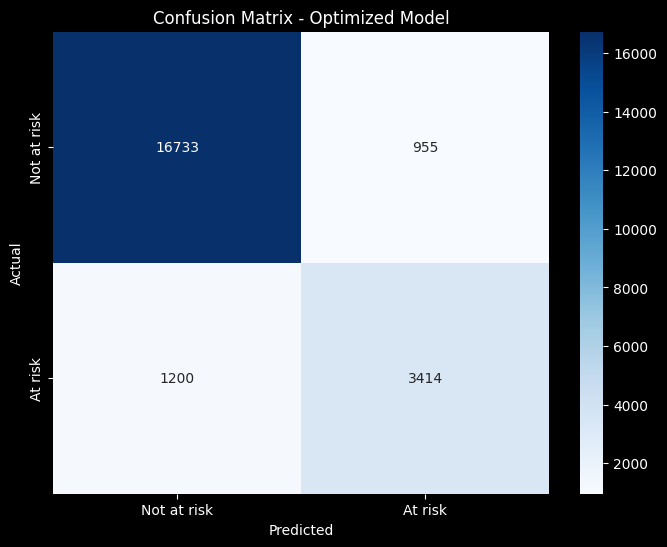

In [8]:
conf_matrix = confusion_matrix(y_test, y_pred2)
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Not at risk", "At risk"],
    yticklabels=["Not at risk", "At risk"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Optimized Model")
plt.show()
plt.close()
